In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['bmh'])
import statsmodels.api as sm
from scipy import stats
import os
import openpyxl

In [3]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [4]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [5]:
path_figure='/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/figure/'

# DATA Count  OTU

In [4]:
response=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response/yield_per_meter/response_yield_per_meter.csv")

In [5]:
response.rename(columns={'Column1':'Link_ID','Yield_per_meter':'y_con','x1':'y_binary'},inplace=True)

In [6]:
response

Link_ID Variety2      y_con  y_binary
0    MN_10_1_Y1      Red  5220.8557       1.0
1    MN_10_2_Y1      Red  4734.6362       1.0
2    MN_10_3_Y1      Red  2935.8209       0.0
3    MN_11_1_Y1      Red  5488.9654       1.0
4    MN_11_2_Y1      Red  4624.0065       1.0
..          ...      ...        ...       ...
191   WI_8_1_Y1   Russet  3800.0000       1.0
192   WI_8_2_Y1   Russet  6566.0000       1.0
193   WI_8_3_Y1   Russet  5134.0000       1.0
194   WI_9_1_Y1   Russet  4533.0000       1.0
195   WI_9_3_Y1   Russet  4825.5300       1.0

[196 rows x 4 columns]

Text(0, 0.5, 'Sample Label')

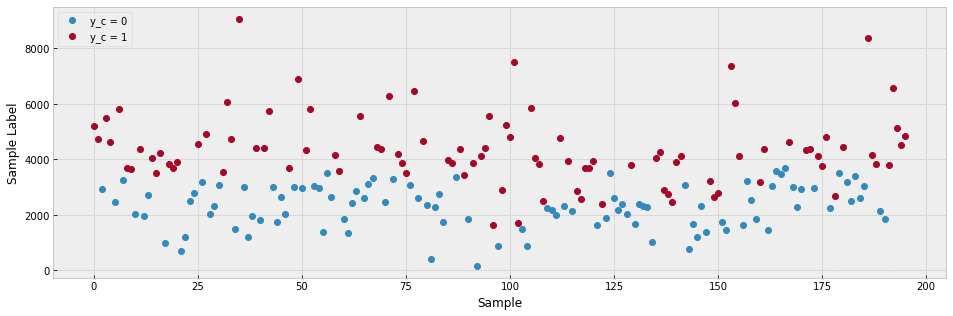

In [7]:
plt.figure(figsize=(16,5))
plt.plot(response['y_con'].loc[response['y_binary']==0],'o')
plt.plot(response['y_con'].loc[response['y_binary']==1],'o')
plt.legend(['y_c = 0', 'y_c = 1'])
plt.xlabel('Sample')
plt.ylabel('Sample Label')


<AxesSubplot:ylabel='Count'>

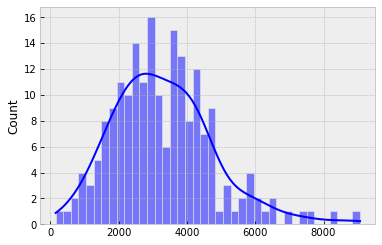

In [8]:
sns.histplot(response['y_con'].values,bins=40, kde=True)
#plt.savefig('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/response.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

0.5523983536911291


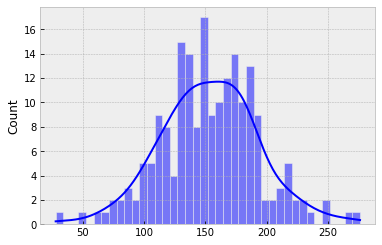

In [9]:
fitted_y, fitted_lambda = stats.boxcox(response['y_con'])
sns.histplot(fitted_y,bins=40, kde=True)
print(fitted_lambda)

In [10]:
response['y_boxcox'] = fitted_y

/Users/rosa/opt/anaconda3/envs/soil_env2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='y_con', ylabel='y_boxcox'>

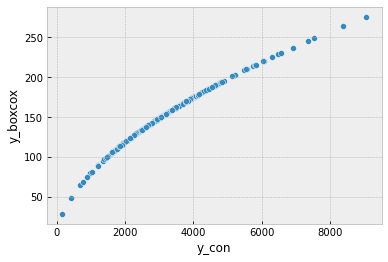

In [11]:
sns.scatterplot(response['y_con'], response['y_boxcox'])

# Data without NA

In [12]:
k=0
data_shape1=[]
data_shape2=[]
data_shape3=[]
qt=[]
q=0.3
path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/Compiled_data'
os.chdir(path)

for file in os.listdir(path):
    if (file[-4:] == '.csv')&(file[0] != 'd'):
        print(file)
        data_temp = pd.read_csv(file,header=0,index_col=0)
        data_temp = data_temp.rename(columns={data_temp.columns[0]:'Link_ID'})
        df1=data_temp.set_index('Link_ID').T
        df1=df1.reset_index()
        df1=df1.rename(columns={'index':'Link_ID'})
        data_shape1.append(df1.shape[1]-1)
        data_original = pd.merge(df1, response, on='Link_ID')
        duplicated_columns_list = []
        list_of_all_columns = list(df1.columns)
        for column in list_of_all_columns:
            if list_of_all_columns.count(column) > 1 and not column in duplicated_columns_list:
                duplicated_columns_list.append(column)
        data_original=data_original.drop(columns=duplicated_columns_list)
        data_shape2.append(data_original.shape[1]-5)
        print(data_original.shape[1]-5)
        nsample_OTU=[]
        for col in data_original.drop(columns=response.columns).columns:
            I = data_original[col]>0
            nsample_OTU.append(sum(I))
            
        fr_OTU=pd.DataFrame()
        fr_OTU['OTU'] = data_original.drop(columns=response.columns).columns
        fr_OTU['Fr']  = pd.DataFrame(nsample_OTU)
        fr_OTU['value OTU']=data_original.drop(columns=response.columns).sum(0).values
        fr_OTU=fr_OTU.set_index('OTU')
        fr_OTU=fr_OTU.sort_values('Fr',ascending=False)
        #fr_OTU.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/frequency_OTU'+file)
        qtt=np.quantile(fr_OTU['Fr'],q)
        qt.append(qtt)
        th=max(15,qtt)
        remain_col=fr_OTU[fr_OTU['Fr']>th].index
        remain_col=remain_col.insert(0, 'Link_ID')
        CountOTU=data_original[remain_col]
        CountOTU=CountOTU.set_index('Link_ID')
        #CountOTU.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/filter_data/CountOTU'+file)
        data_shape3.append(CountOTU.shape[1])
        
        

Y1_F_Genus.csv
1322
Y1_F_Family.csv
479
Y1_F_Phylum.csv
60
Y1_F_Class.csv
155
Y1_F_Order.csv
381


In [13]:
list_name=['Y1_F_Genus','Y1_F_Family','Y1_F_Phylum','Y1_F_Class','Y1_F_Order']
df_report=pd.DataFrame()
df_report.index=list_name
df_report['number of OTU with NA']=data_shape1
df_report['number of OTU']=data_shape2
df_report['quantile']=qt
df_report['number of OTU filter']=data_shape3
#df_report.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/df_report.csv')

$\color{red}{\text{Among 219 sample I consider otu with frequency >15. 
If these 15 sample has large values is it imoportant to consider them or not???}}$

In [14]:
df_report

number of OTU with NA  number of OTU  quantile  \
Y1_F_Genus                    2017           1322       1.0   
Y1_F_Family                    855            479       3.0   
Y1_F_Phylum                     63             60      19.7   
Y1_F_Class                     195            155      17.0   
Y1_F_Order                     510            381       6.0   

             number of OTU filter  
Y1_F_Genus                    460  
Y1_F_Family                   251  
Y1_F_Phylum                    42  
Y1_F_Class                    107  
Y1_F_Order                    220

# Data with NA

In [15]:
k=0
data_shape1=[]
data_shape2=[]
data_shape3=[]
qt=[]
q=0.3
path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/Compiled_data'
os.chdir(path)

for file in os.listdir(path):
    if (file[-4:] == '.csv')&(file[0] != 'd'):
        print(file)
        data_temp = pd.read_csv(file,header=0,index_col=0)
        data_temp = data_temp.rename(columns={data_temp.columns[0]:'Link_ID'})
        df1=data_temp.set_index('Link_ID').T
        df1=df1.reset_index()
        df1=df1.rename(columns={'index':'Link_ID'})
        data_shape1.append(df1.shape[1]-1)
        data_original = pd.merge(df1, response, on='Link_ID')
        data_original.to_csv('df1.csv')
        data_original=pd.read_csv('df1.csv')
        data_shape2.append(data_original.shape[1])
        print(data_original.shape[1])
        nsample_OTU=[]
        for col in data_original.drop(columns=response.columns).columns:
            I = data_original[col]>0
            nsample_OTU.append(sum(I))
            
        fr_OTU=pd.DataFrame()
        fr_OTU['OTU'] = data_original.drop(columns=response.columns).columns
        fr_OTU['Fr']  = pd.DataFrame(nsample_OTU)
        fr_OTU['value OTU']=data_original.drop(columns=response.columns).sum(0).values
        fr_OTU=fr_OTU.set_index('OTU')
        fr_OTU=fr_OTU.sort_values('Fr',ascending=False)
        #fr_OTU.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/frequency_OTU'+file)
        qtt=np.quantile(fr_OTU['Fr'],q)
        qt.append(qtt)
        th=max(15,qtt)
        remain_col=fr_OTU[fr_OTU['Fr']>th].index
        remain_col=remain_col.insert(0, 'Link_ID')
        CountOTU=data_original[remain_col]
        CountOTU=CountOTU.set_index('Link_ID')
        #CountOTU.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/filter_data/withNA/CountOTU'+file)
        data_shape3.append(CountOTU.shape[1])
        
        

Y1_F_Genus.csv
2023
Y1_F_Family.csv
861
Y1_F_Phylum.csv
69
Y1_F_Class.csv
201
Y1_F_Order.csv
516


In [16]:
list_name=['Y1_F_Genus','Y1_F_Family','Y1_F_Phylum','Y1_F_Class','Y1_F_Order']
df_report_na=pd.DataFrame()
df_report_na.index=list_name
df_report_na['number of OTU with NA']=data_shape1
df_report_na['quantile']=qt
df_report_na['number of OTU filter']=data_shape3
#df_report_na.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/df_report_withNA.csv')

In [17]:
df_report_na

number of OTU with NA  quantile  number of OTU filter
Y1_F_Genus                    2017       2.0                   824
Y1_F_Family                    855       4.0                   457
Y1_F_Phylum                     63      21.9                    45
Y1_F_Class                     195      11.5                   134
Y1_F_Order                     510       6.0                   302

In [18]:
plot_report = pd.DataFrame()
plot_report['level'] = ['Genus', 'Family', 'Phylum', 'Class', 'Order']
plot_report['No. OTU with NA'] = df_report['number of OTU with NA'].values
plot_report['No. OTU after filtering'] = df_report_na['number of OTU filter'].values
plot_report['No. OTU after removing  NA'] = df_report['number of OTU'].values
plot_report['No. OTU after removing  NA and filtering']=df_report['number of OTU filter'].values


In [19]:
plot_report

level  No. OTU with NA  No. OTU after filtering  \
0   Genus             2017                      824   
1  Family              855                      457   
2  Phylum               63                       45   
3   Class              195                      134   
4   Order              510                      302   

   No. OTU after removing  NA  No. OTU after removing  NA and filtering  
0                        1322                                       460  
1                         479                                       251  
2                          60                                        42  
3                         155                                       107  
4                         381                                       220

In [20]:
main_df = pd.DataFrame(columns=['Data', 'Response'])
for col in plot_report.drop(columns='level'):
    temp_df = pd.DataFrame()
    temp_df['Data'] = plot_report[col].values
    temp_df['Response'] = col
    temp_df['Level'] = plot_report['level']
    main_df = pd.concat([main_df, temp_df])

In [21]:
main_df 

Data                                  Response   Level
0  2017                           No. OTU with NA   Genus
1   855                           No. OTU with NA  Family
2    63                           No. OTU with NA  Phylum
3   195                           No. OTU with NA   Class
4   510                           No. OTU with NA   Order
0   824                   No. OTU after filtering   Genus
1   457                   No. OTU after filtering  Family
2    45                   No. OTU after filtering  Phylum
3   134                   No. OTU after filtering   Class
4   302                   No. OTU after filtering   Order
0  1322                No. OTU after removing  NA   Genus
1   479                No. OTU after removing  NA  Family
2    60                No. OTU after removing  NA  Phylum
3   155                No. OTU after removing  NA   Class
4   381                No. OTU after removing  NA   Order
0   460  No. OTU after removing  NA and filtering   Genus
1   251  No. OTU after removing  NA and filtering  Family
2    42  No. OTU after removing  NA and filtering  Phylum
3   107  No. OTU after removing  NA and filtering   Class
4   220  No. OTU after removing  NA and filtering   Order

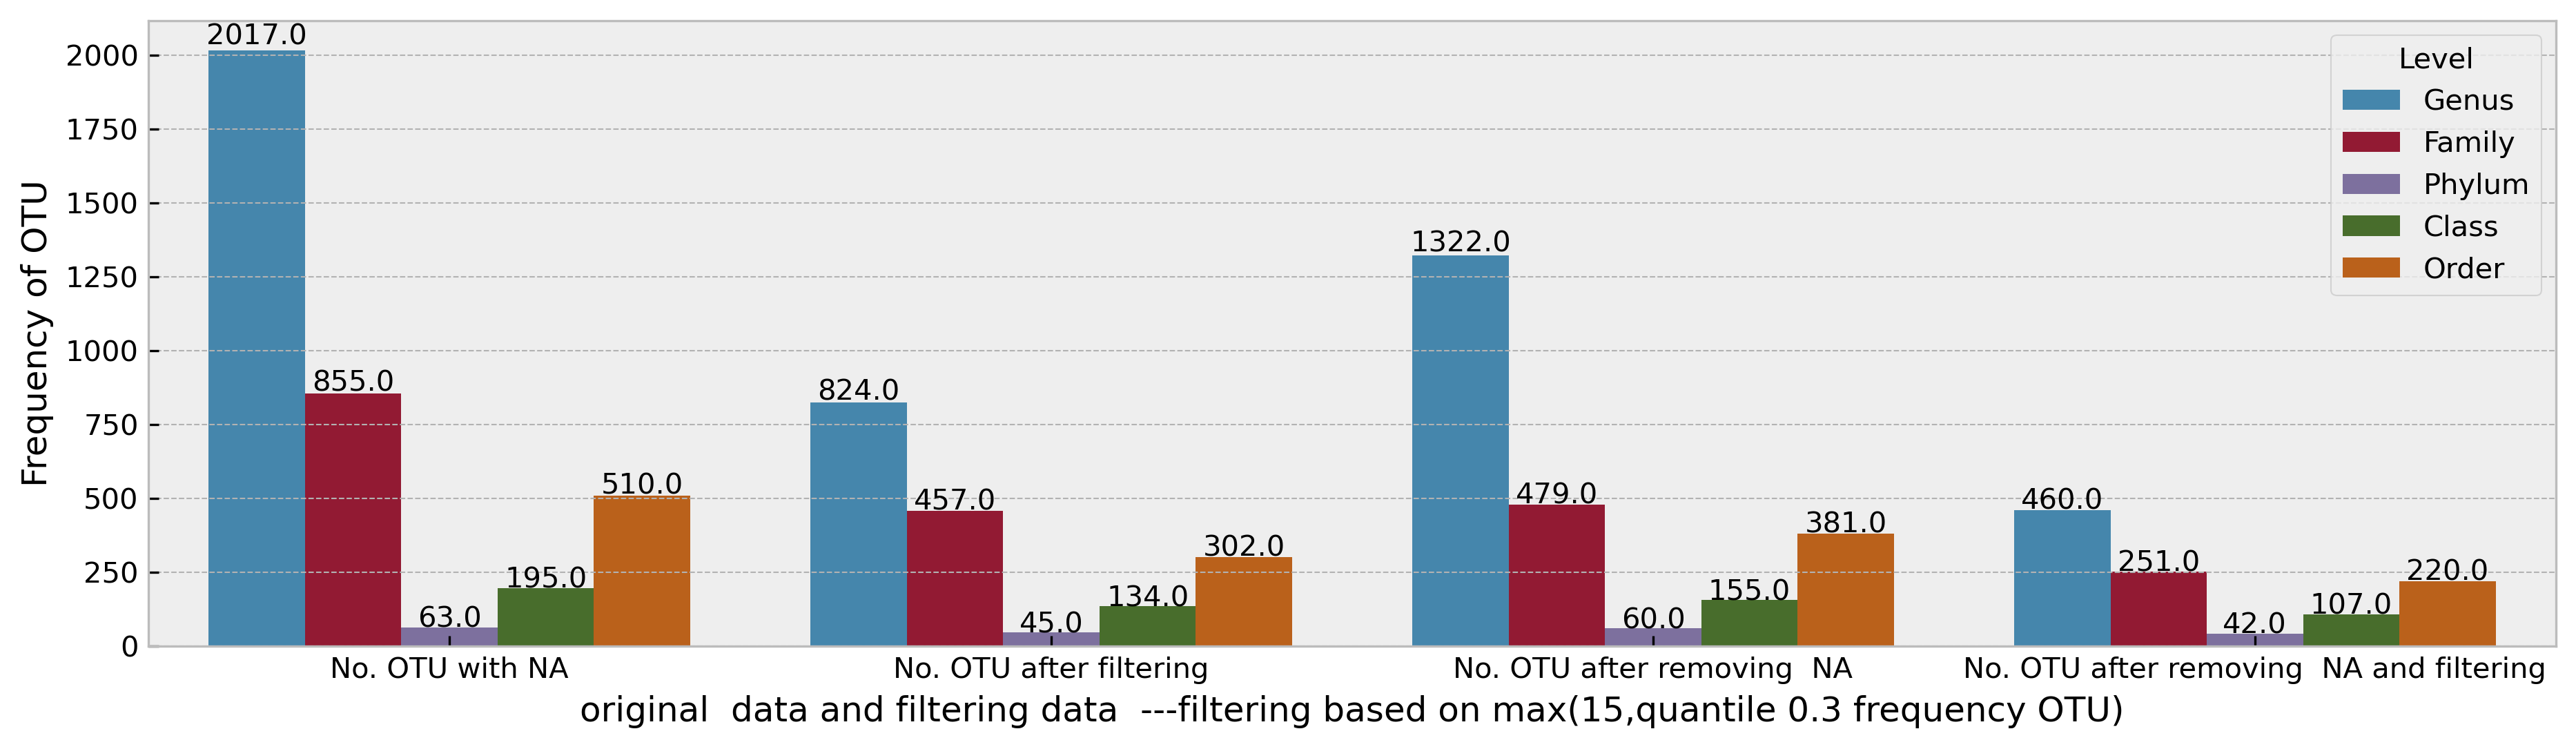

In [22]:
plt.figure(figsize=(15,4), dpi=300)
ax = sns.barplot(data = main_df, x='Response',y='Data',hue='Level')
show_values(ax)
plt.ylabel('Frequency of OTU')
plt.xlabel('original  data and filtering data  ---filtering based on max(15,quantile 0.3 frequency OTU)')
plt.savefig(path_figure+'Frequency_OTU.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

# Responses

In [19]:
path_response='/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response_sklearn_na/' 
plot_response=pd.DataFrame()
k=0
for file_response in os.listdir(path_response): 
    if (file_response != '.DS_Store') & (file_response != 'Icon\r'): 
        print(file_response) 
        path_r= path_response+file_response 
        os.chdir(path_r) 
        for re in os.listdir(path_r): 
            if re[0:8] == 'response': 
                response = pd.read_csv(path_response+file_response+'/'+re) 
                response.rename(columns={'Column1':'Link_ID','x1':'y_b'}, inplace=True) 
                label_1=response['y_b'].sum()
                label_0=response.shape[0]-label_1
                plot_response=pd.concat([plot_response,pd.DataFrame([file_response,label_1, label_0])],axis=1)
                #plot_response=plot_response.transpose()

yield_per_meter
scab_severity
no_tuber_scab
pctg_black_scurf
yield_per_plant
no_tuber_scabpit
no_tuber_hollow
no_tuber
no_tuber_scabsuper


In [20]:
plot_responseT=plot_response.transpose()
plot_responseT.rename(columns={0:'response',1:'label_1', 2:'label_0'},inplace=True)

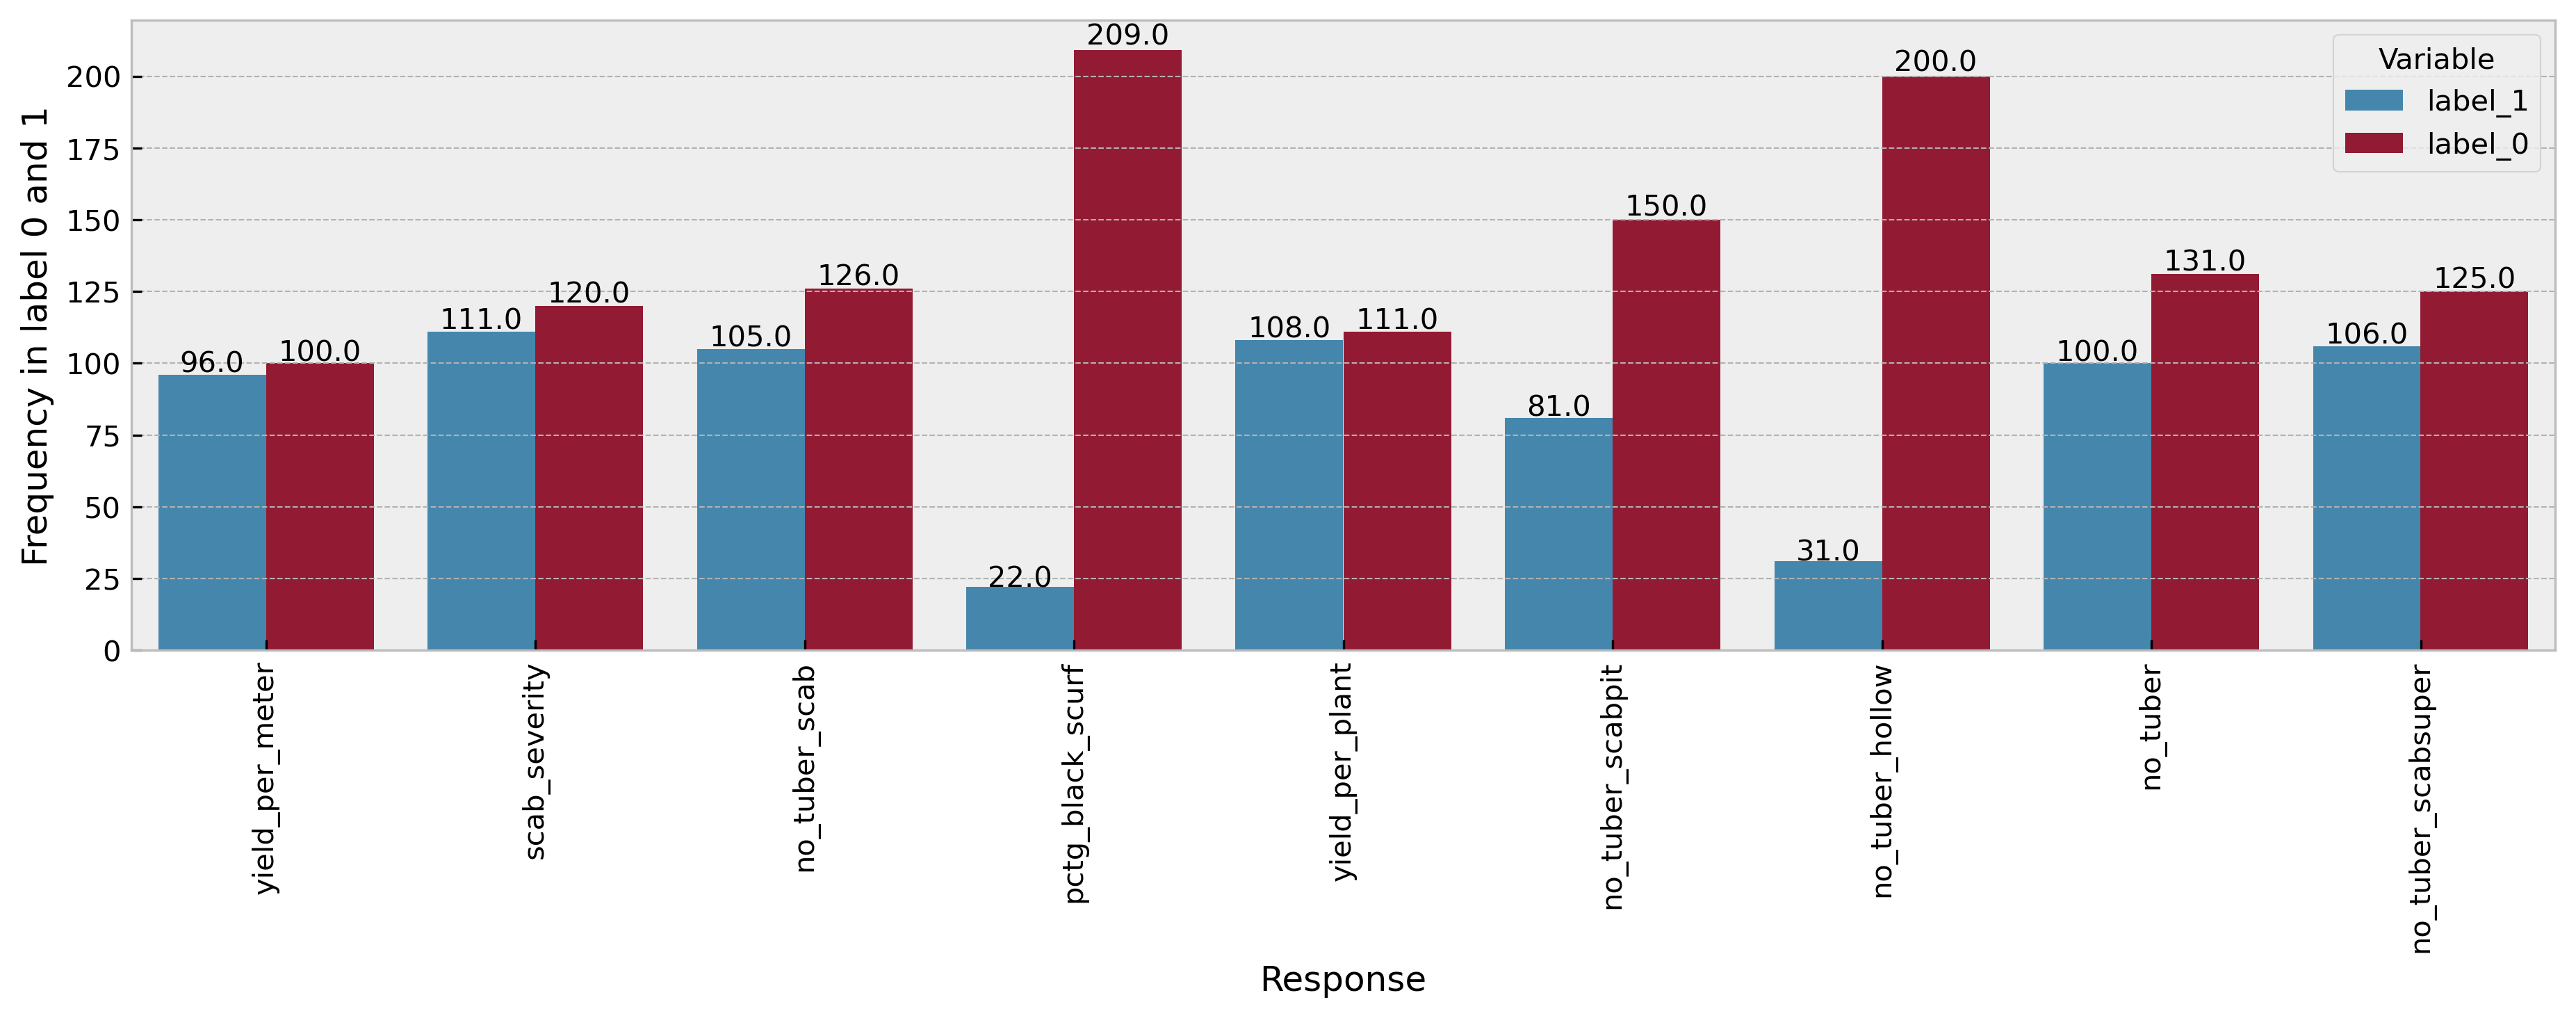

In [21]:
df=plot_responseT.melt(id_vars='response').rename(columns=str.title)
plt.figure(figsize=(15,4), dpi=300)
ax = sns.barplot(data = df, x='Response',y='Value',hue='Variable')
show_values(ax)
plt.xticks(rotation = 90)
plt.ylabel('Frequency in label 0 and 1')
plt.savefig(path_figure+'Frequency in label 0 and label 1.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

In [63]:
data_path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response_sklearn'

In [64]:
path_list = []

for root, dirs, files in os.walk(data_path, topdown=False):
    for path in dirs:
        path_list.append(path)
        
wb = openpyxl.load_workbook(data_path+'/'+path+'/classification_RF_NA.xlsx')
sheet_list = wb.sheetnames

results_dic = dict.fromkeys(sheet_list)

for sheet_name in results_dic.keys():
    temp_df = pd.DataFrame(columns=path_list)
    for folder in path_list:
        data_temp = pd.read_excel(data_path+'/'+folder+'/classification_RF_NA.xlsx', sheet_name=sheet_name)
        temp_df[folder] = data_temp.iloc[4][1:].values

    results_dic[sheet_name] = temp_df

In [65]:
sheet_list

['Order', 'Family', 'Genus', 'Class', 'Phylum']

In [66]:
main_df = pd.DataFrame(columns=['Data', 'Response'])
for key in results_dic.keys():
    for col in results_dic[key]:
        temp_df = pd.DataFrame()
        temp_df['Data'] = results_dic[key][col].values
        temp_df['Response'] = col
        temp_df['Level'] = key
        main_df = pd.concat([main_df, temp_df]) 

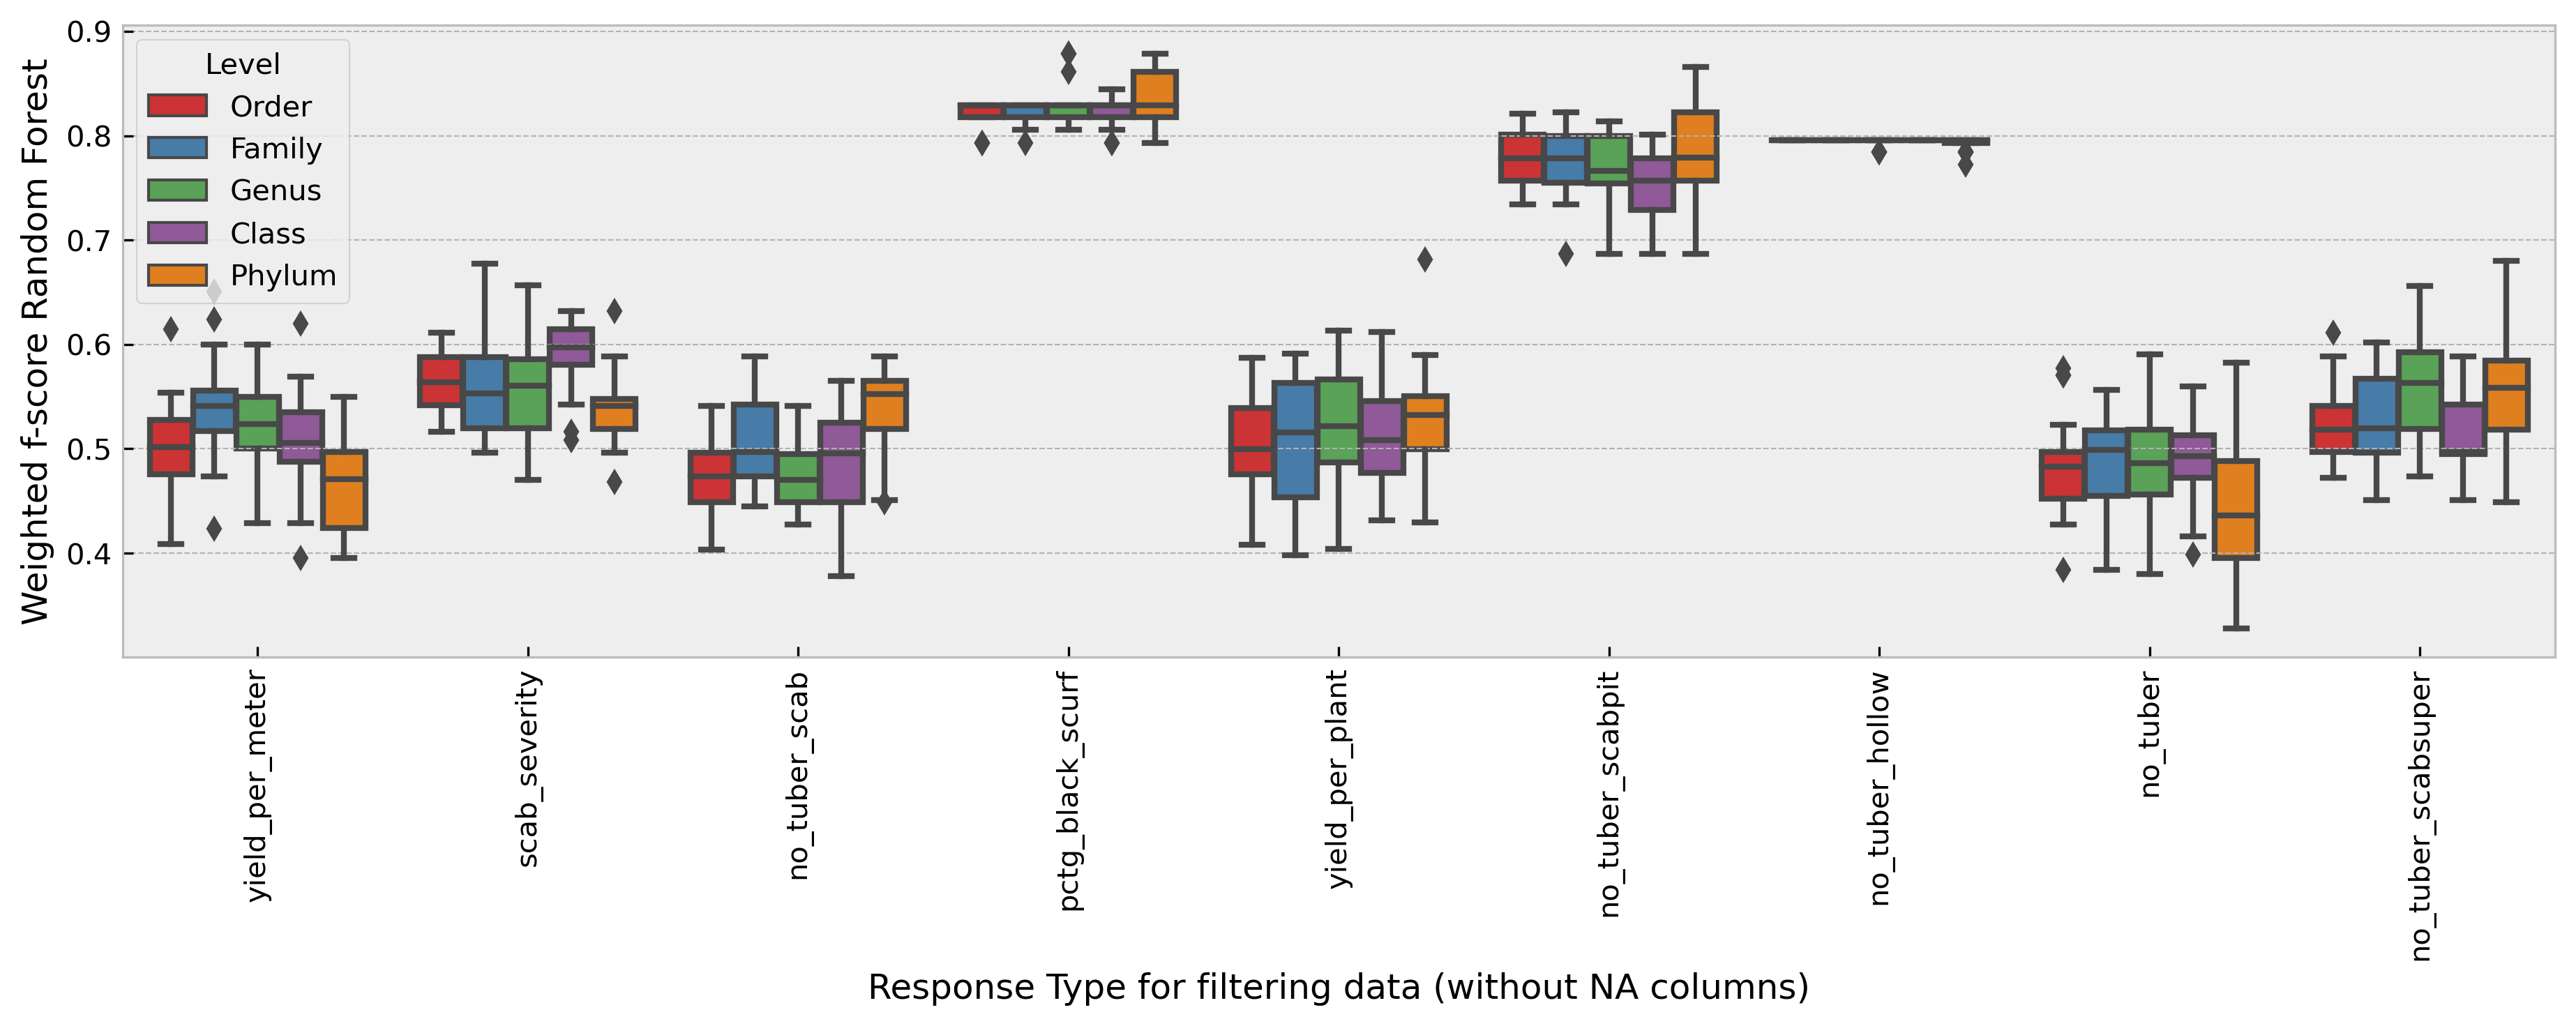

In [67]:
plt.figure(figsize=(15,4), dpi=300)
sns.boxplot(data = main_df, x='Response', y='Data', hue='Level', palette='Set1')
plt.xticks(rotation = 90)
plt.ylabel('Weighted f-score Random Forest')
plt.xlabel('Response Type for filtering data (without NA columns)')
plt.savefig(path_figure+'allresponses-alllevel-sklearn_RF.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

In [68]:
data_path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response_sklearn_na'

In [69]:
path_list = []

for root, dirs, files in os.walk(data_path, topdown=False):
    for path in dirs:
        path_list.append(path)
        
wb = openpyxl.load_workbook(data_path+'/'+path+'/classification_RF_NA.xlsx')
sheet_list = wb.sheetnames

results_dic = dict.fromkeys(sheet_list)

for sheet_name in results_dic.keys():
    temp_df = pd.DataFrame(columns=path_list)
    for folder in path_list:
        data_temp = pd.read_excel(data_path+'/'+folder+'/classification_RF_NA.xlsx', sheet_name=sheet_name)
        temp_df[folder] = data_temp.iloc[4][1:].values

    results_dic[sheet_name] = temp_df

In [70]:
main_df = pd.DataFrame(columns=['Data', 'Response'])
for key in results_dic.keys():
    for col in results_dic[key]:
        temp_df = pd.DataFrame()
        temp_df['Data'] = results_dic[key][col].values
        temp_df['Response'] = col
        temp_df['Level'] = key
        main_df = pd.concat([main_df, temp_df])

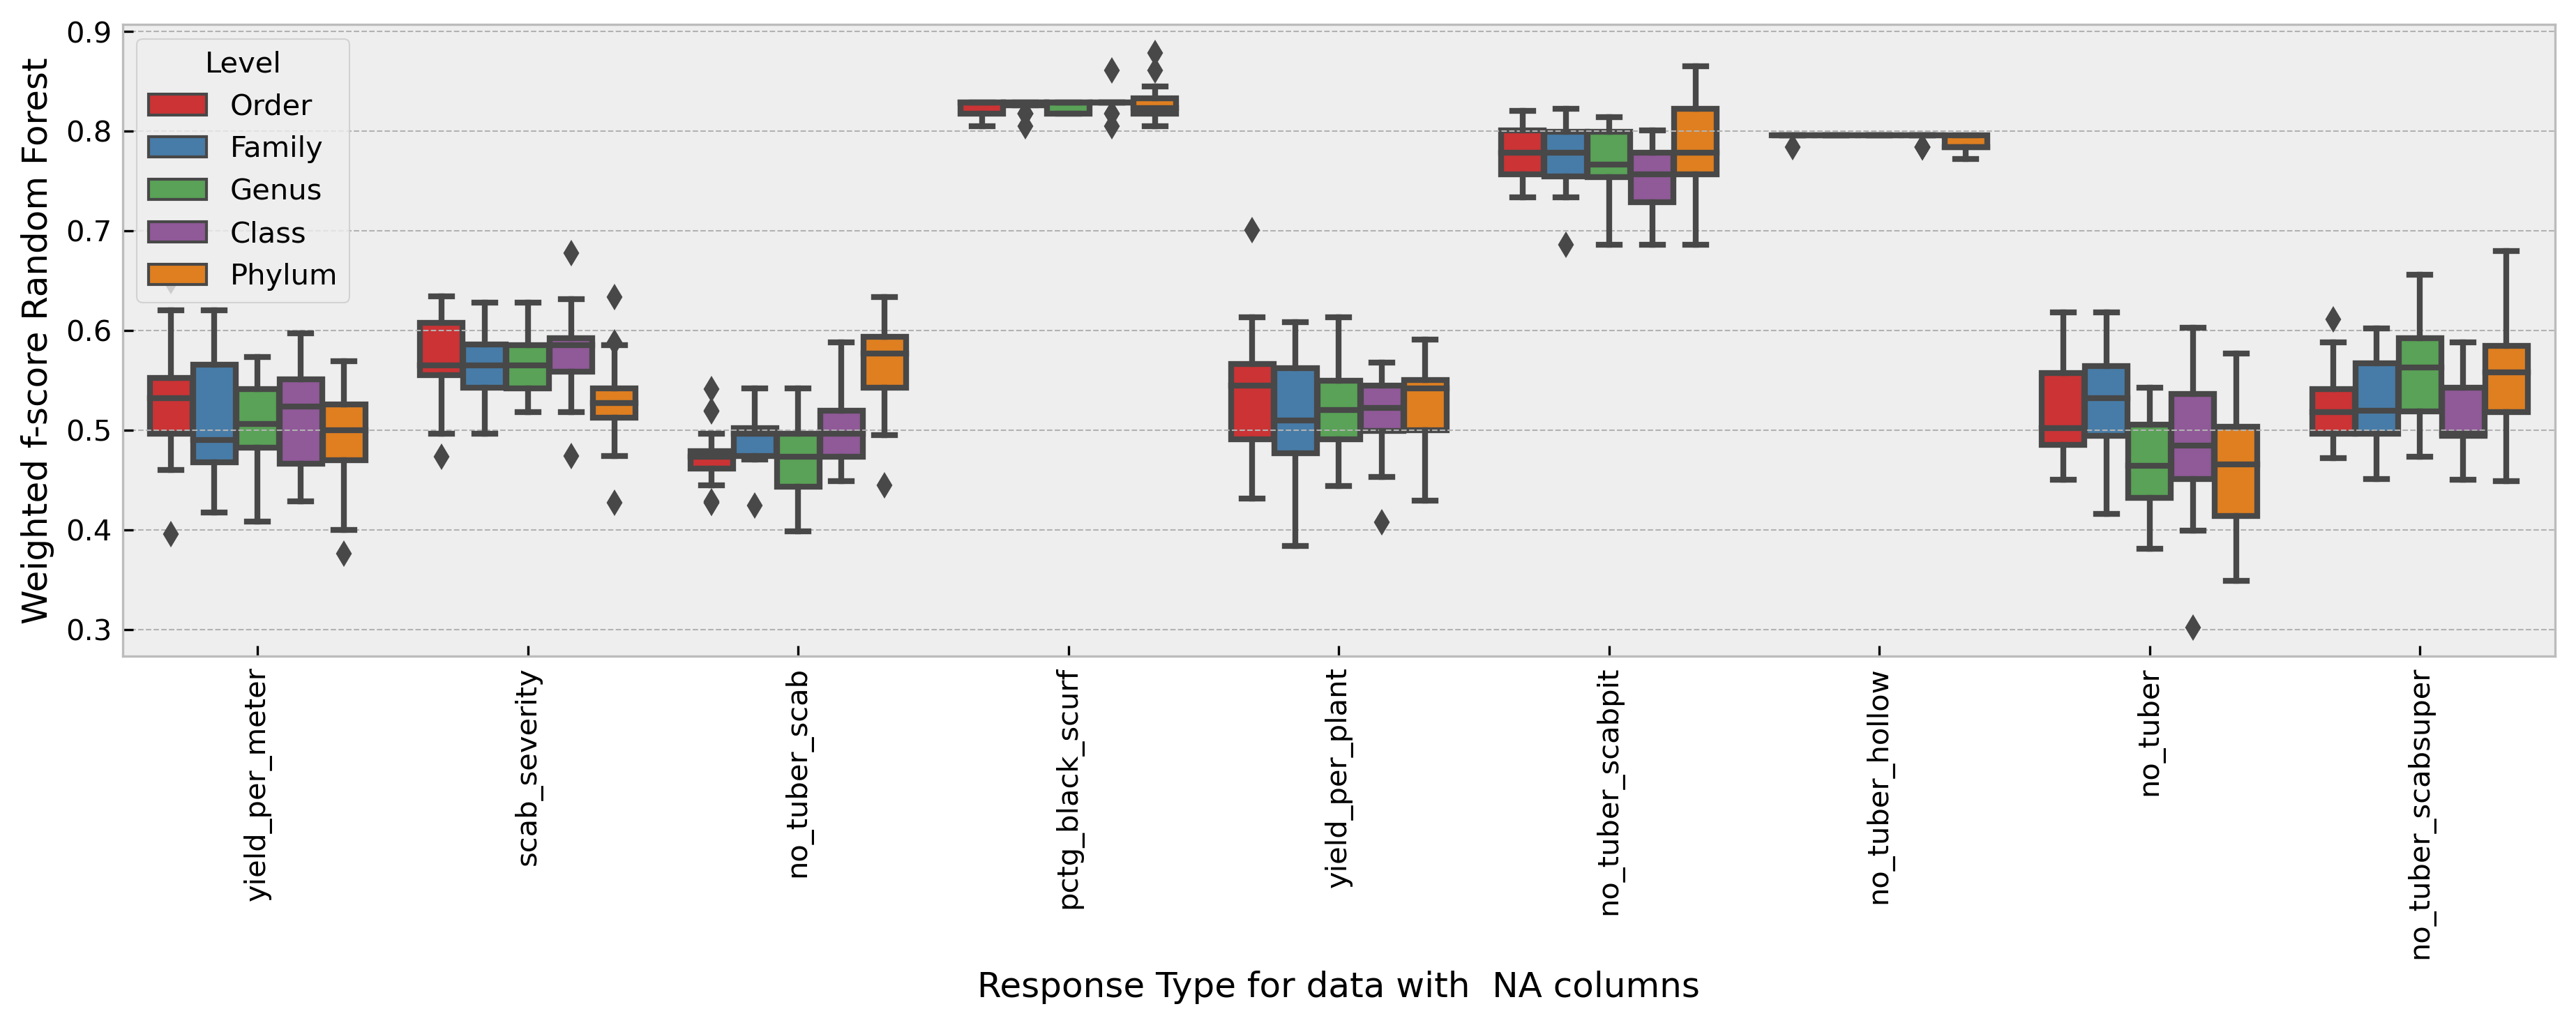

In [71]:
plt.figure(figsize=(15,4), dpi=300)
sns.boxplot(data = main_df, x='Response', y='Data', hue='Level', palette='Set1')
plt.xticks(rotation = 90)
plt.ylabel('Weighted f-score Random Forest')
plt.xlabel('Response Type for data with  NA columns')
plt.savefig(path_figure+'allresponses-alllevel-sklearn-NA_RF.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

# Xudong Result

In [5]:
data_path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response_xudong'

In [7]:
path_list = []

for root, dirs, files in os.walk(data_path, topdown=False):
    for path in dirs:
        path_list.append(path)
        
wb = openpyxl.load_workbook(data_path+'/'+path+'/classification.xlsx')
sheet_list = wb.sheetnames

results_dic = dict.fromkeys(sheet_list)

for sheet_name in results_dic.keys():
    temp_df = pd.DataFrame(columns=path_list)
    for folder in path_list:
        data_temp = pd.read_excel(data_path+'/'+folder+'/classification.xlsx', sheet_name=sheet_name)
        temp_df[folder] = data_temp.iloc[4][1:].values

    results_dic[sheet_name] = temp_df

In [8]:
main_df = pd.DataFrame(columns=['Data', 'Response'])
for key in results_dic.keys():
    for col in results_dic[key]:
        temp_df = pd.DataFrame()
        temp_df['Data'] = results_dic[key][col].values
        temp_df['Response'] = col
        temp_df['Level'] = key
        main_df = pd.concat([main_df, temp_df])

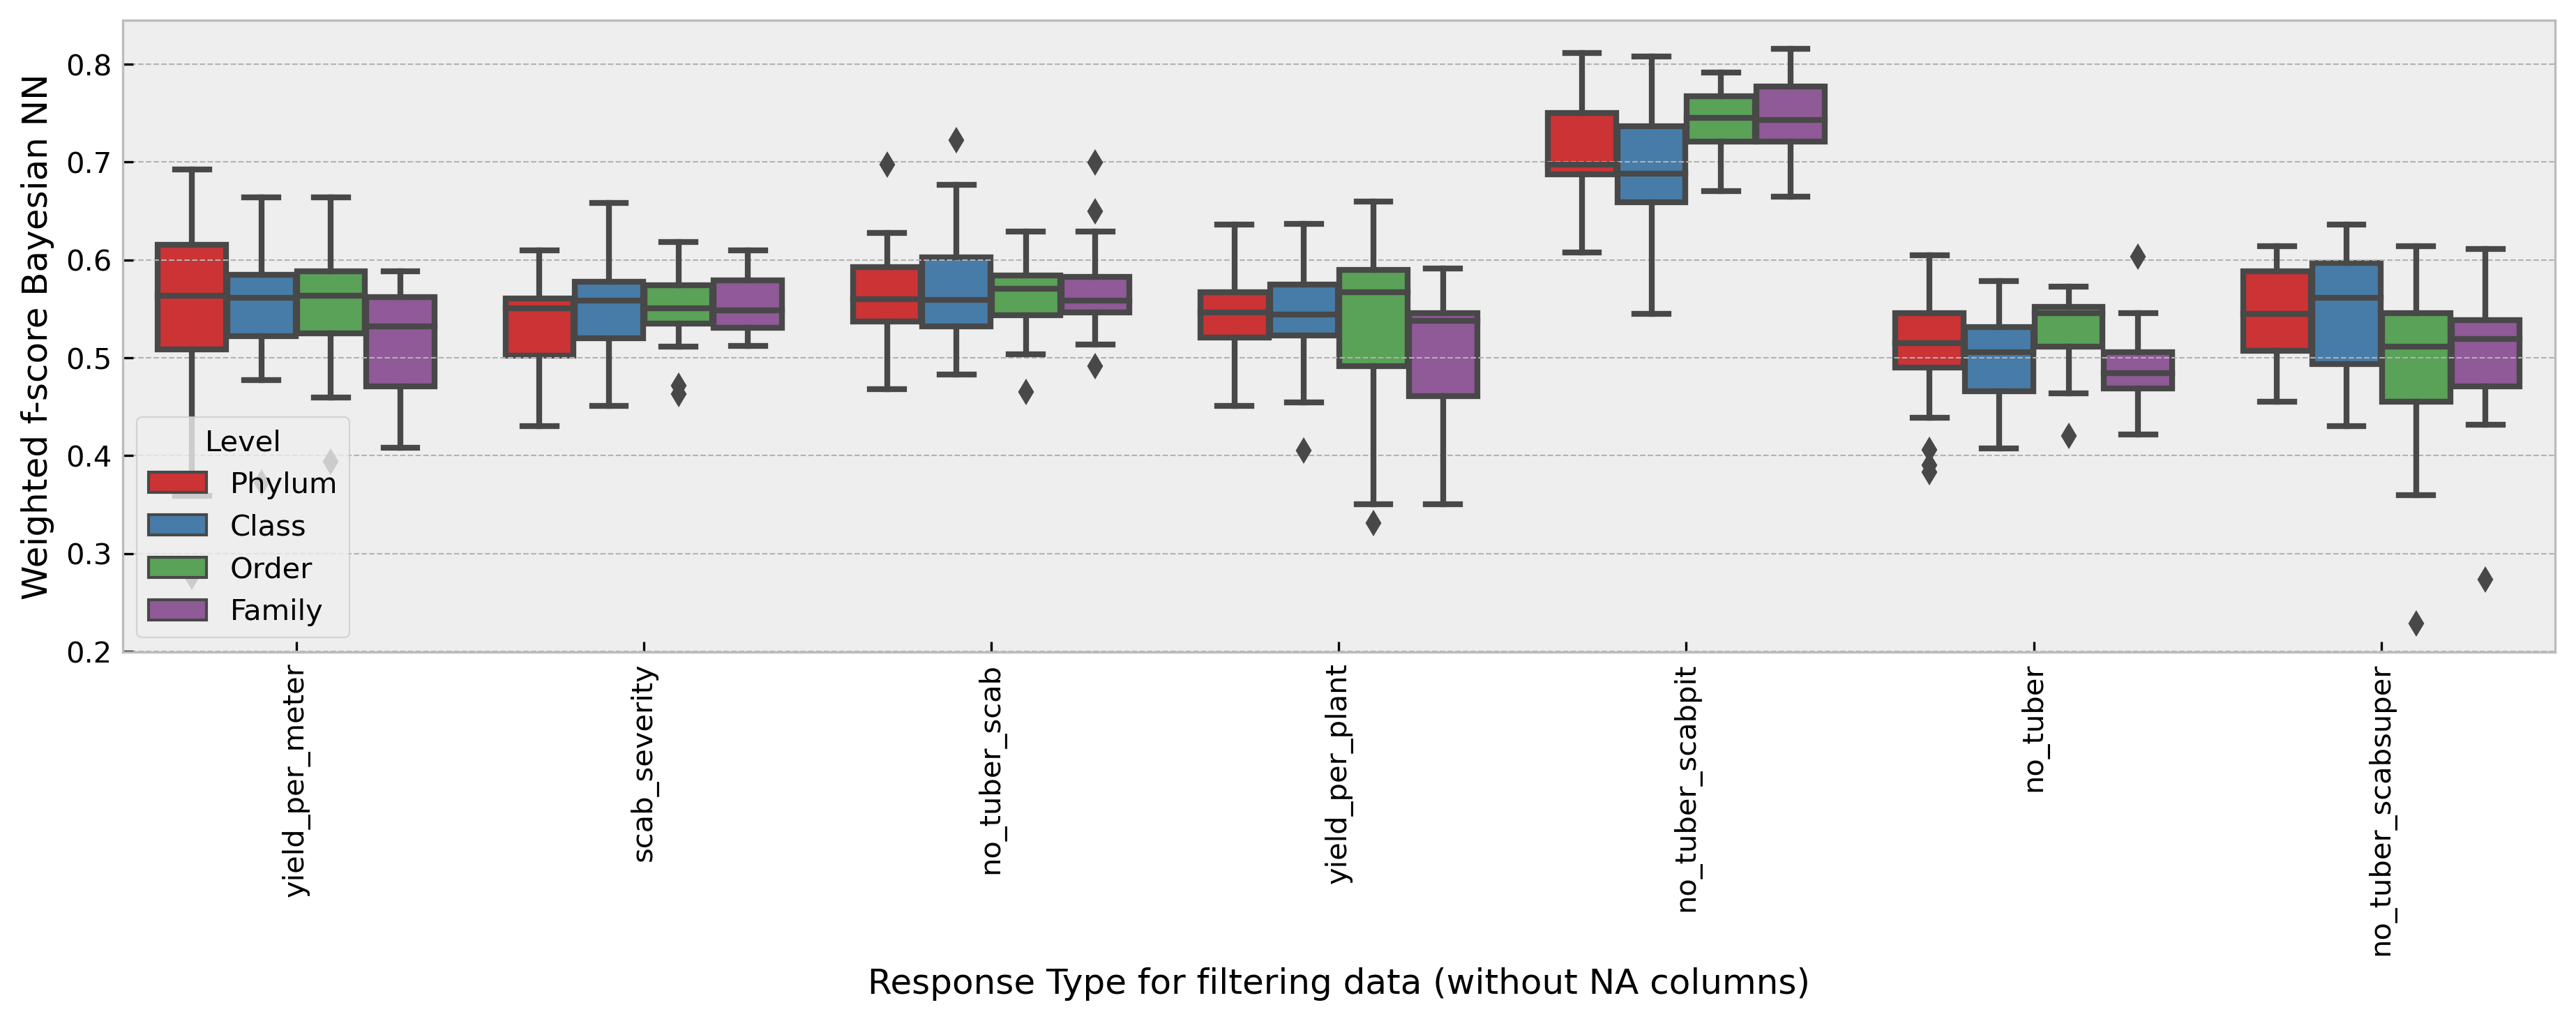

In [9]:
plt.figure(figsize=(15,4), dpi=300)
sns.boxplot(data = main_df, x='Response', y='Data', hue='Level', palette='Set1')
plt.xticks(rotation = 90)
plt.ylabel('Weighted f-score Bayesian NN')
plt.xlabel('Response Type for filtering data (without NA columns)')
plt.savefig(path_figure+'allresponses-alllevel-sklearn-Xudong.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

# Based on feature seleceted

In [76]:
data_path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response_sklearn'

In [77]:
path_list = []

for root, dirs, files in os.walk(data_path, topdown=False):
    for path in dirs:
        path_list.append(path)
        
wb = openpyxl.load_workbook(data_path+'/'+path+'/classification_RF_FS.xlsx')
sheet_list = wb.sheetnames

results_dic = dict.fromkeys(sheet_list)

for sheet_name in results_dic.keys():
    temp_df = pd.DataFrame(columns=path_list)
    for folder in path_list:
        data_temp = pd.read_excel(data_path+'/'+folder+'/classification_RF_FS.xlsx', sheet_name=sheet_name)
        temp_df[folder] = data_temp.iloc[4][1:].values

    results_dic[sheet_name] = temp_df

In [78]:
main_df = pd.DataFrame(columns=['Data', 'Response'])
for key in results_dic.keys():
    for col in results_dic[key]:
        temp_df = pd.DataFrame()
        temp_df['Data'] = results_dic[key][col].values
        temp_df['Response'] = col
        temp_df['Level'] = key
        main_df = pd.concat([main_df, temp_df])

# Based on feature seleceted

In [76]:
data_path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response_sklearn'

In [77]:
path_list = []

for root, dirs, files in os.walk(data_path, topdown=False):
    for path in dirs:
        path_list.append(path)
        
wb = openpyxl.load_workbook(data_path+'/'+path+'/classification_RF_FS.xlsx')
sheet_list = wb.sheetnames

results_dic = dict.fromkeys(sheet_list)

for sheet_name in results_dic.keys():
    temp_df = pd.DataFrame(columns=path_list)
    for folder in path_list:
        data_temp = pd.read_excel(data_path+'/'+folder+'/classification_RF_FS.xlsx', sheet_name=sheet_name)
        temp_df[folder] = data_temp.iloc[4][1:].values

    results_dic[sheet_name] = temp_df

In [78]:
main_df = pd.DataFrame(columns=['Data', 'Response'])
for key in results_dic.keys():
    for col in results_dic[key]:
        temp_df = pd.DataFrame()
        temp_df['Data'] = results_dic[key][col].values
        temp_df['Response'] = col
        temp_df['Level'] = key
        main_df = pd.concat([main_df, temp_df])

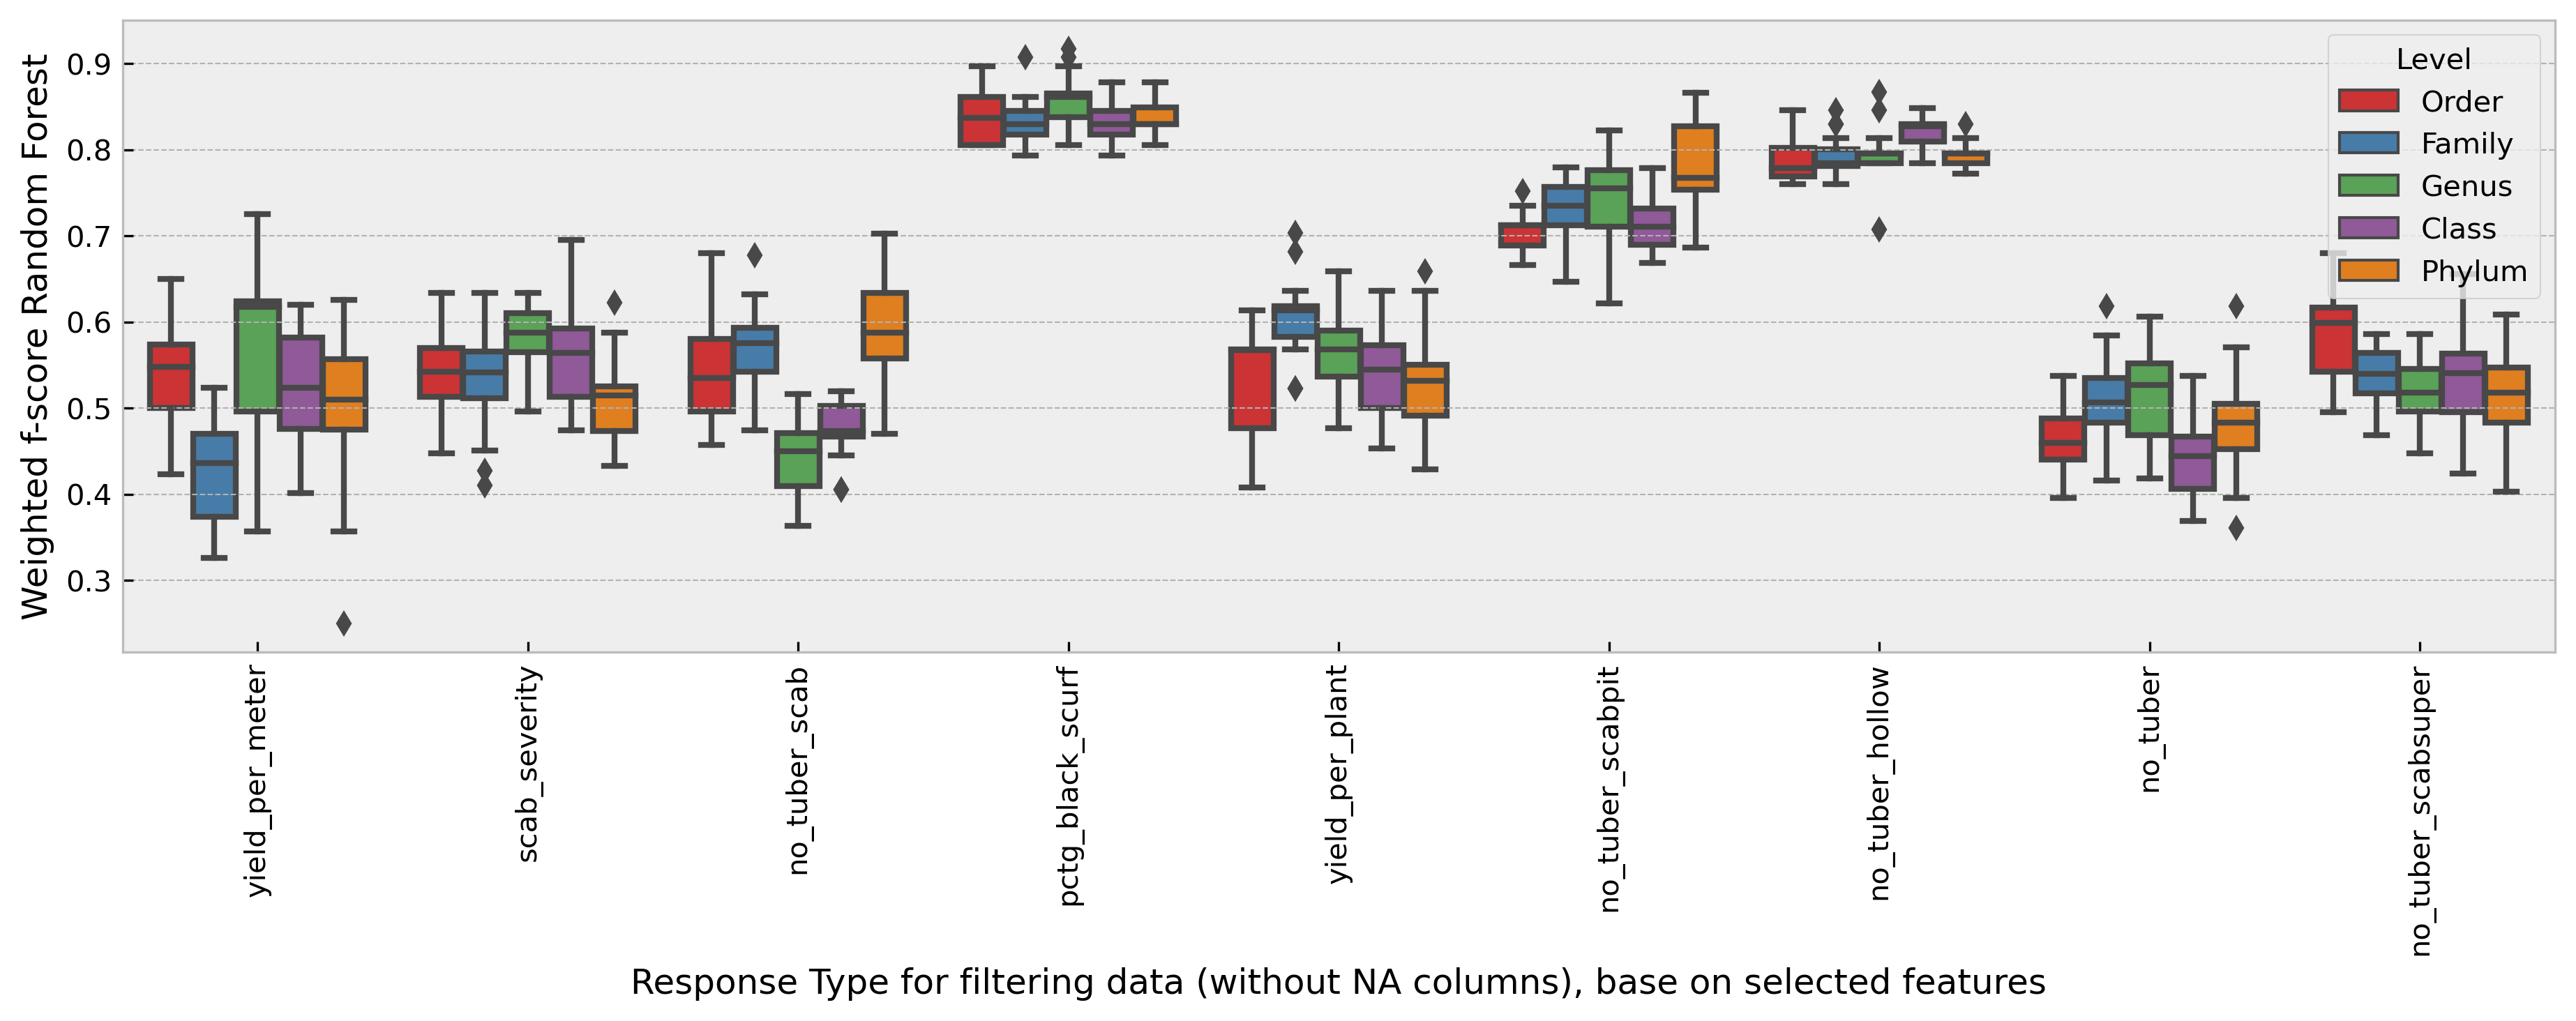

In [79]:
plt.figure(figsize=(15,4), dpi=300)
sns.boxplot(data = main_df, x='Response', y='Data', hue='Level', palette='Set1')
plt.xticks(rotation = 90)
plt.ylabel('Weighted f-score Random Forest' )
plt.xlabel('Response Type for filtering data (without NA columns), base on selected features')
plt.savefig(path_figure+'allresponses-alllevel-sklearn-Feasureselected.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

# Based on feature random scoring 0

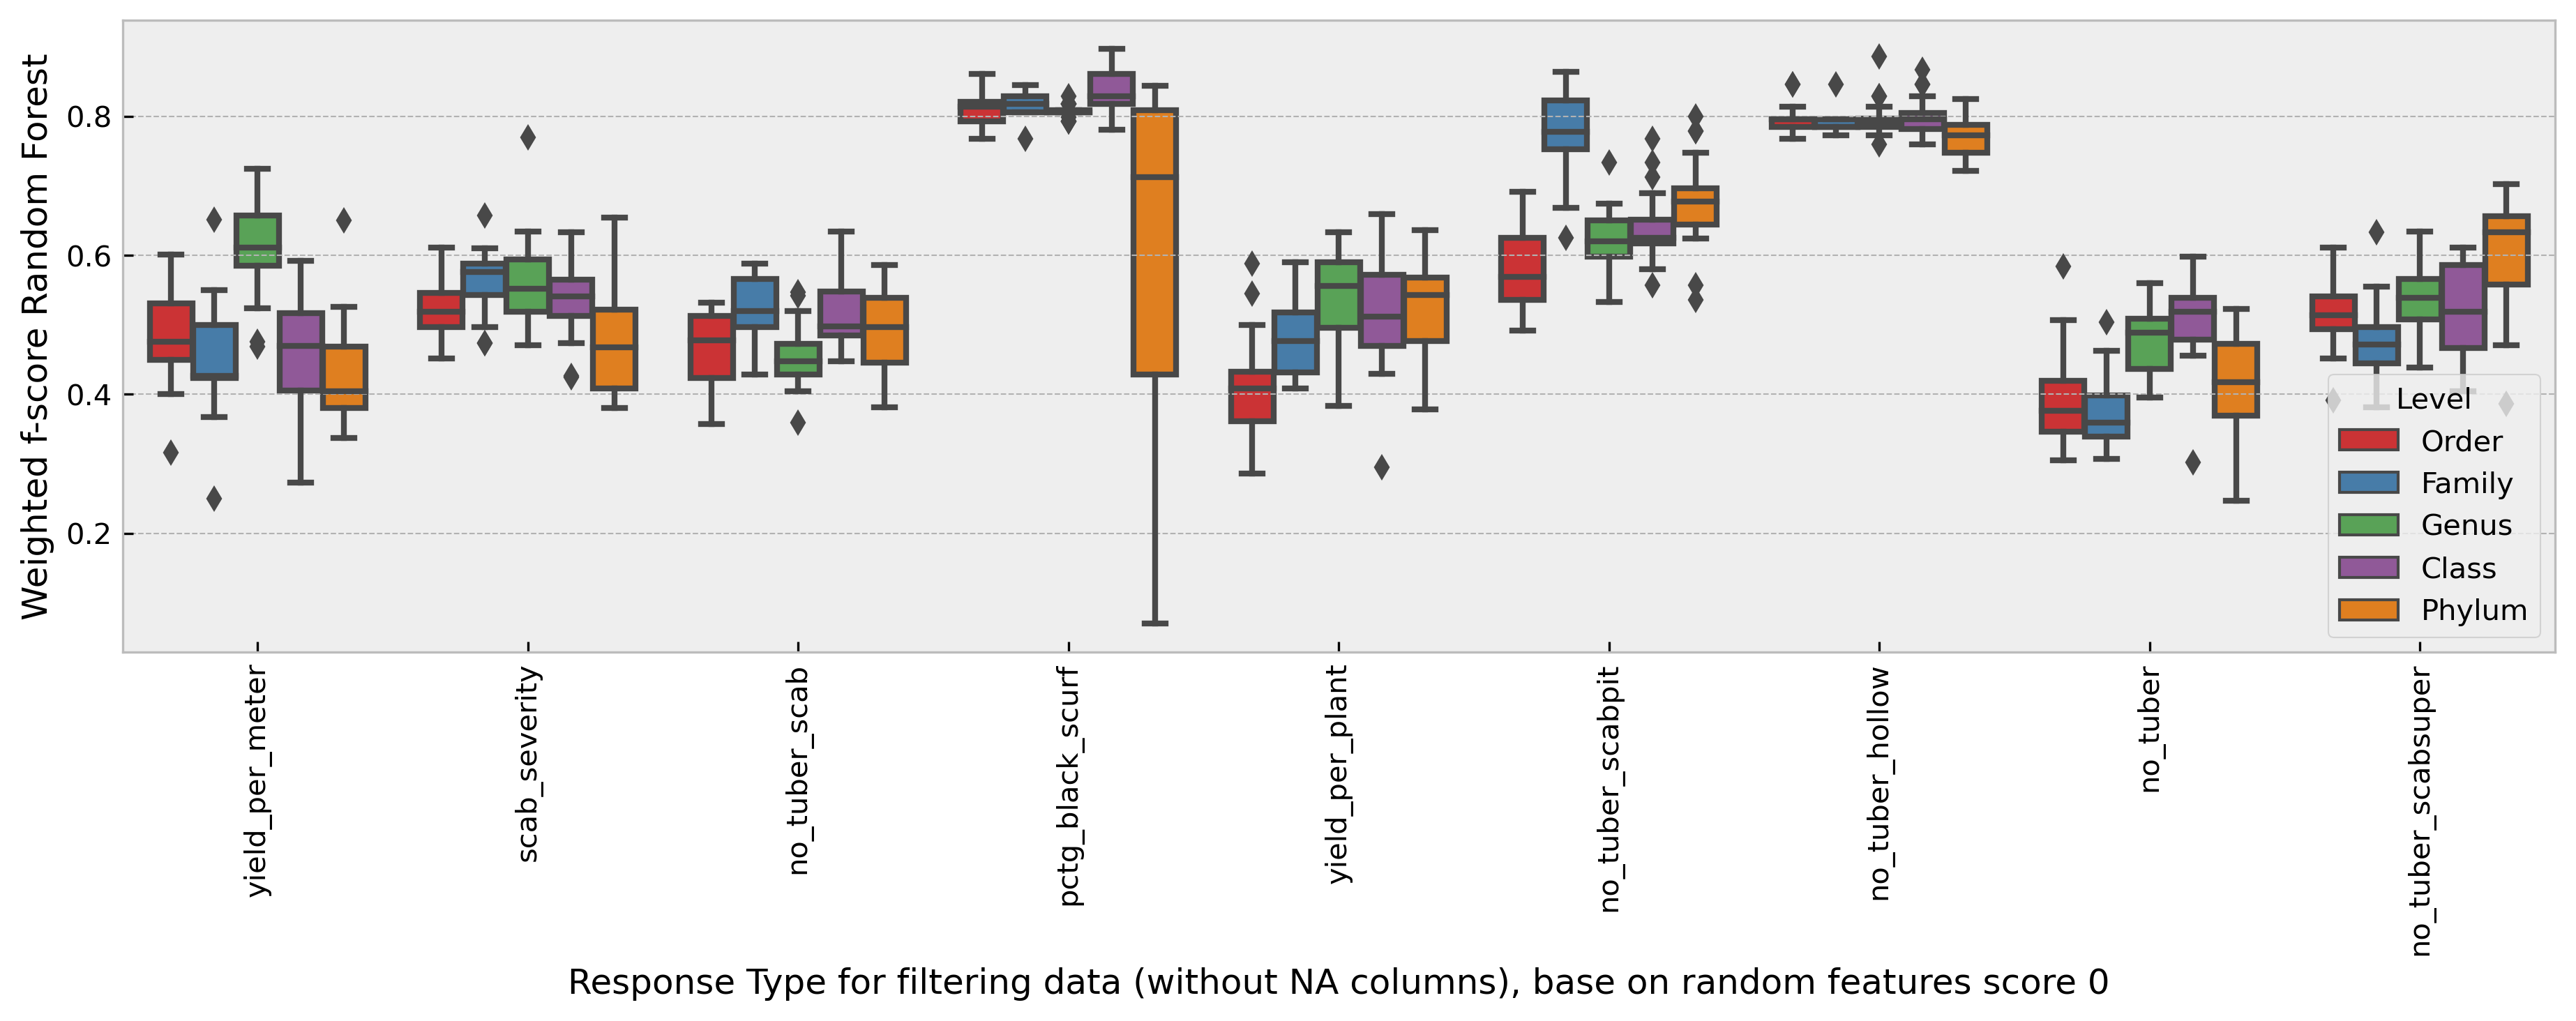

In [12]:
data_path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response_sklearn'
path_list = []

for root, dirs, files in os.walk(data_path, topdown=False):
    for path in dirs:
        path_list.append(path)
        
wb = openpyxl.load_workbook(data_path+'/'+path+'/classification_RF_FS_notImportant.xlsx')
sheet_list = wb.sheetnames

results_dic = dict.fromkeys(sheet_list)

for sheet_name in results_dic.keys():
    temp_df = pd.DataFrame(columns=path_list)
    for folder in path_list:
        data_temp = pd.read_excel(data_path+'/'+folder+'/classification_RF_FS_notImportant.xlsx', sheet_name=sheet_name)
        temp_df[folder] = data_temp.iloc[4][1:].values

    results_dic[sheet_name] = temp_df
main_df = pd.DataFrame(columns=['Data', 'Response'])
for key in results_dic.keys():
    for col in results_dic[key]:
        temp_df = pd.DataFrame()
        temp_df['Data'] = results_dic[key][col].values
        temp_df['Response'] = col
        temp_df['Level'] = key
        main_df = pd.concat([main_df, temp_df])
plt.figure(figsize=(15,4), dpi=300)
sns.boxplot(data = main_df, x='Response', y='Data', hue='Level', palette='Set1')
plt.xticks(rotation = 90)
plt.ylabel('Weighted f-score Random Forest' )
plt.xlabel('Response Type for filtering data (without NA columns), base on random features score 0')
plt.savefig(path_figure+'allresponses-alllevel-sklearn-FeasureNotselected(score0).png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

# Feature Selection

In [41]:
data_path2 = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response_type_compare'

In [42]:
path_list2 = []
#reading files in folder response
for root, dirs, files in os.walk(data_path2, topdown=False):
    for path in dirs:
        path_list2.append(path)
#reading sheet name       
wb = openpyxl.load_workbook(data_path2+'/'+path+'/feature_selection.xlsx')
sheet_list = wb.sheetnames

results_dic = dict.fromkeys(sheet_list)

for sheet_name in results_dic.keys():
    temp_df = pd.DataFrame(columns=path_list2, index=range(0,700))
    for folder in path_list2:
        data_temp = pd.read_excel(data_path2+'/'+folder+'/feature_selection.xlsx', sheet_name=sheet_name)
        temp_df[folder].iloc[
            range(0, len(data_temp['Unnamed: 0'].values))] = data_temp['Unnamed: 0'].values

    results_dic[sheet_name] = temp_df
    
for key in results_dic.keys():
    results_dic[key] = results_dic[key].iloc[range(0,max(40, round(len(data_temp)/3)))]

In [43]:
level = 'Family'
response_list = results_dic[level].keys()

feature_list = []
for response in response_list:
    feature_list.append(results_dic[level][response])
    
feature_list = [item for subitem in feature_list for item in subitem]
feature_list = np.unique(feature_list)
print(len(feature_list))

139


In [44]:
matrix_df = pd.DataFrame(columns = response_list, index = feature_list)

In [45]:
for response in response_list:
    for feature in feature_list:
        if feature in results_dic[level][response].values:
            matrix_df[response].loc[feature] = 1
        else:
            matrix_df[response].loc[feature] = 0

matrix_df['Sum'] = 0
for index in matrix_df.index:
    matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)
#     print(index, )
    
matrix_df.sort_values(by='Sum', ascending=False, inplace=True)

/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_3790/236619354.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)


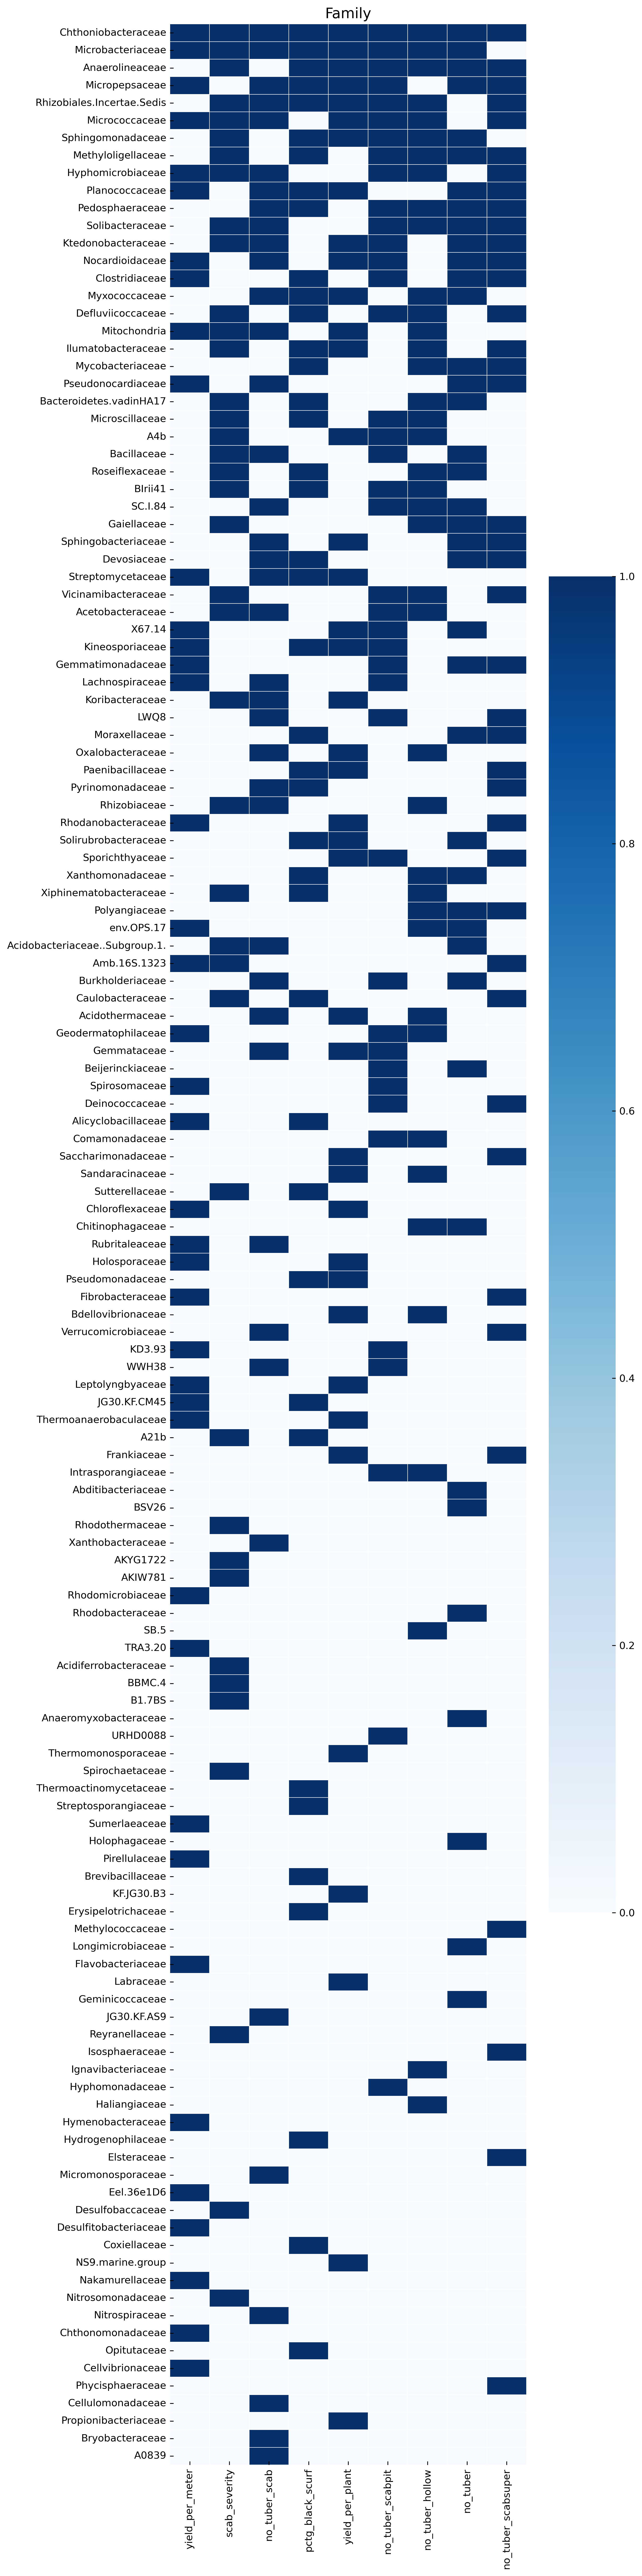

In [46]:
plt.figure(figsize=(8,45), dpi=300)
sns.heatmap(matrix_df.drop(columns='Sum').astype('float'),
           linewidths=.1,cmap="Blues", vmin=0, vmax=1)
plt.title(level)
plt.savefig(path_figure+'FrequencyFeauture.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

Class
88


/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_3790/1814607156.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)


Family
139


/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_3790/1814607156.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)


Genus
157


/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_3790/1814607156.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)


Order
124


/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_3790/1814607156.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)


Phylum
43


/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_3790/1814607156.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)


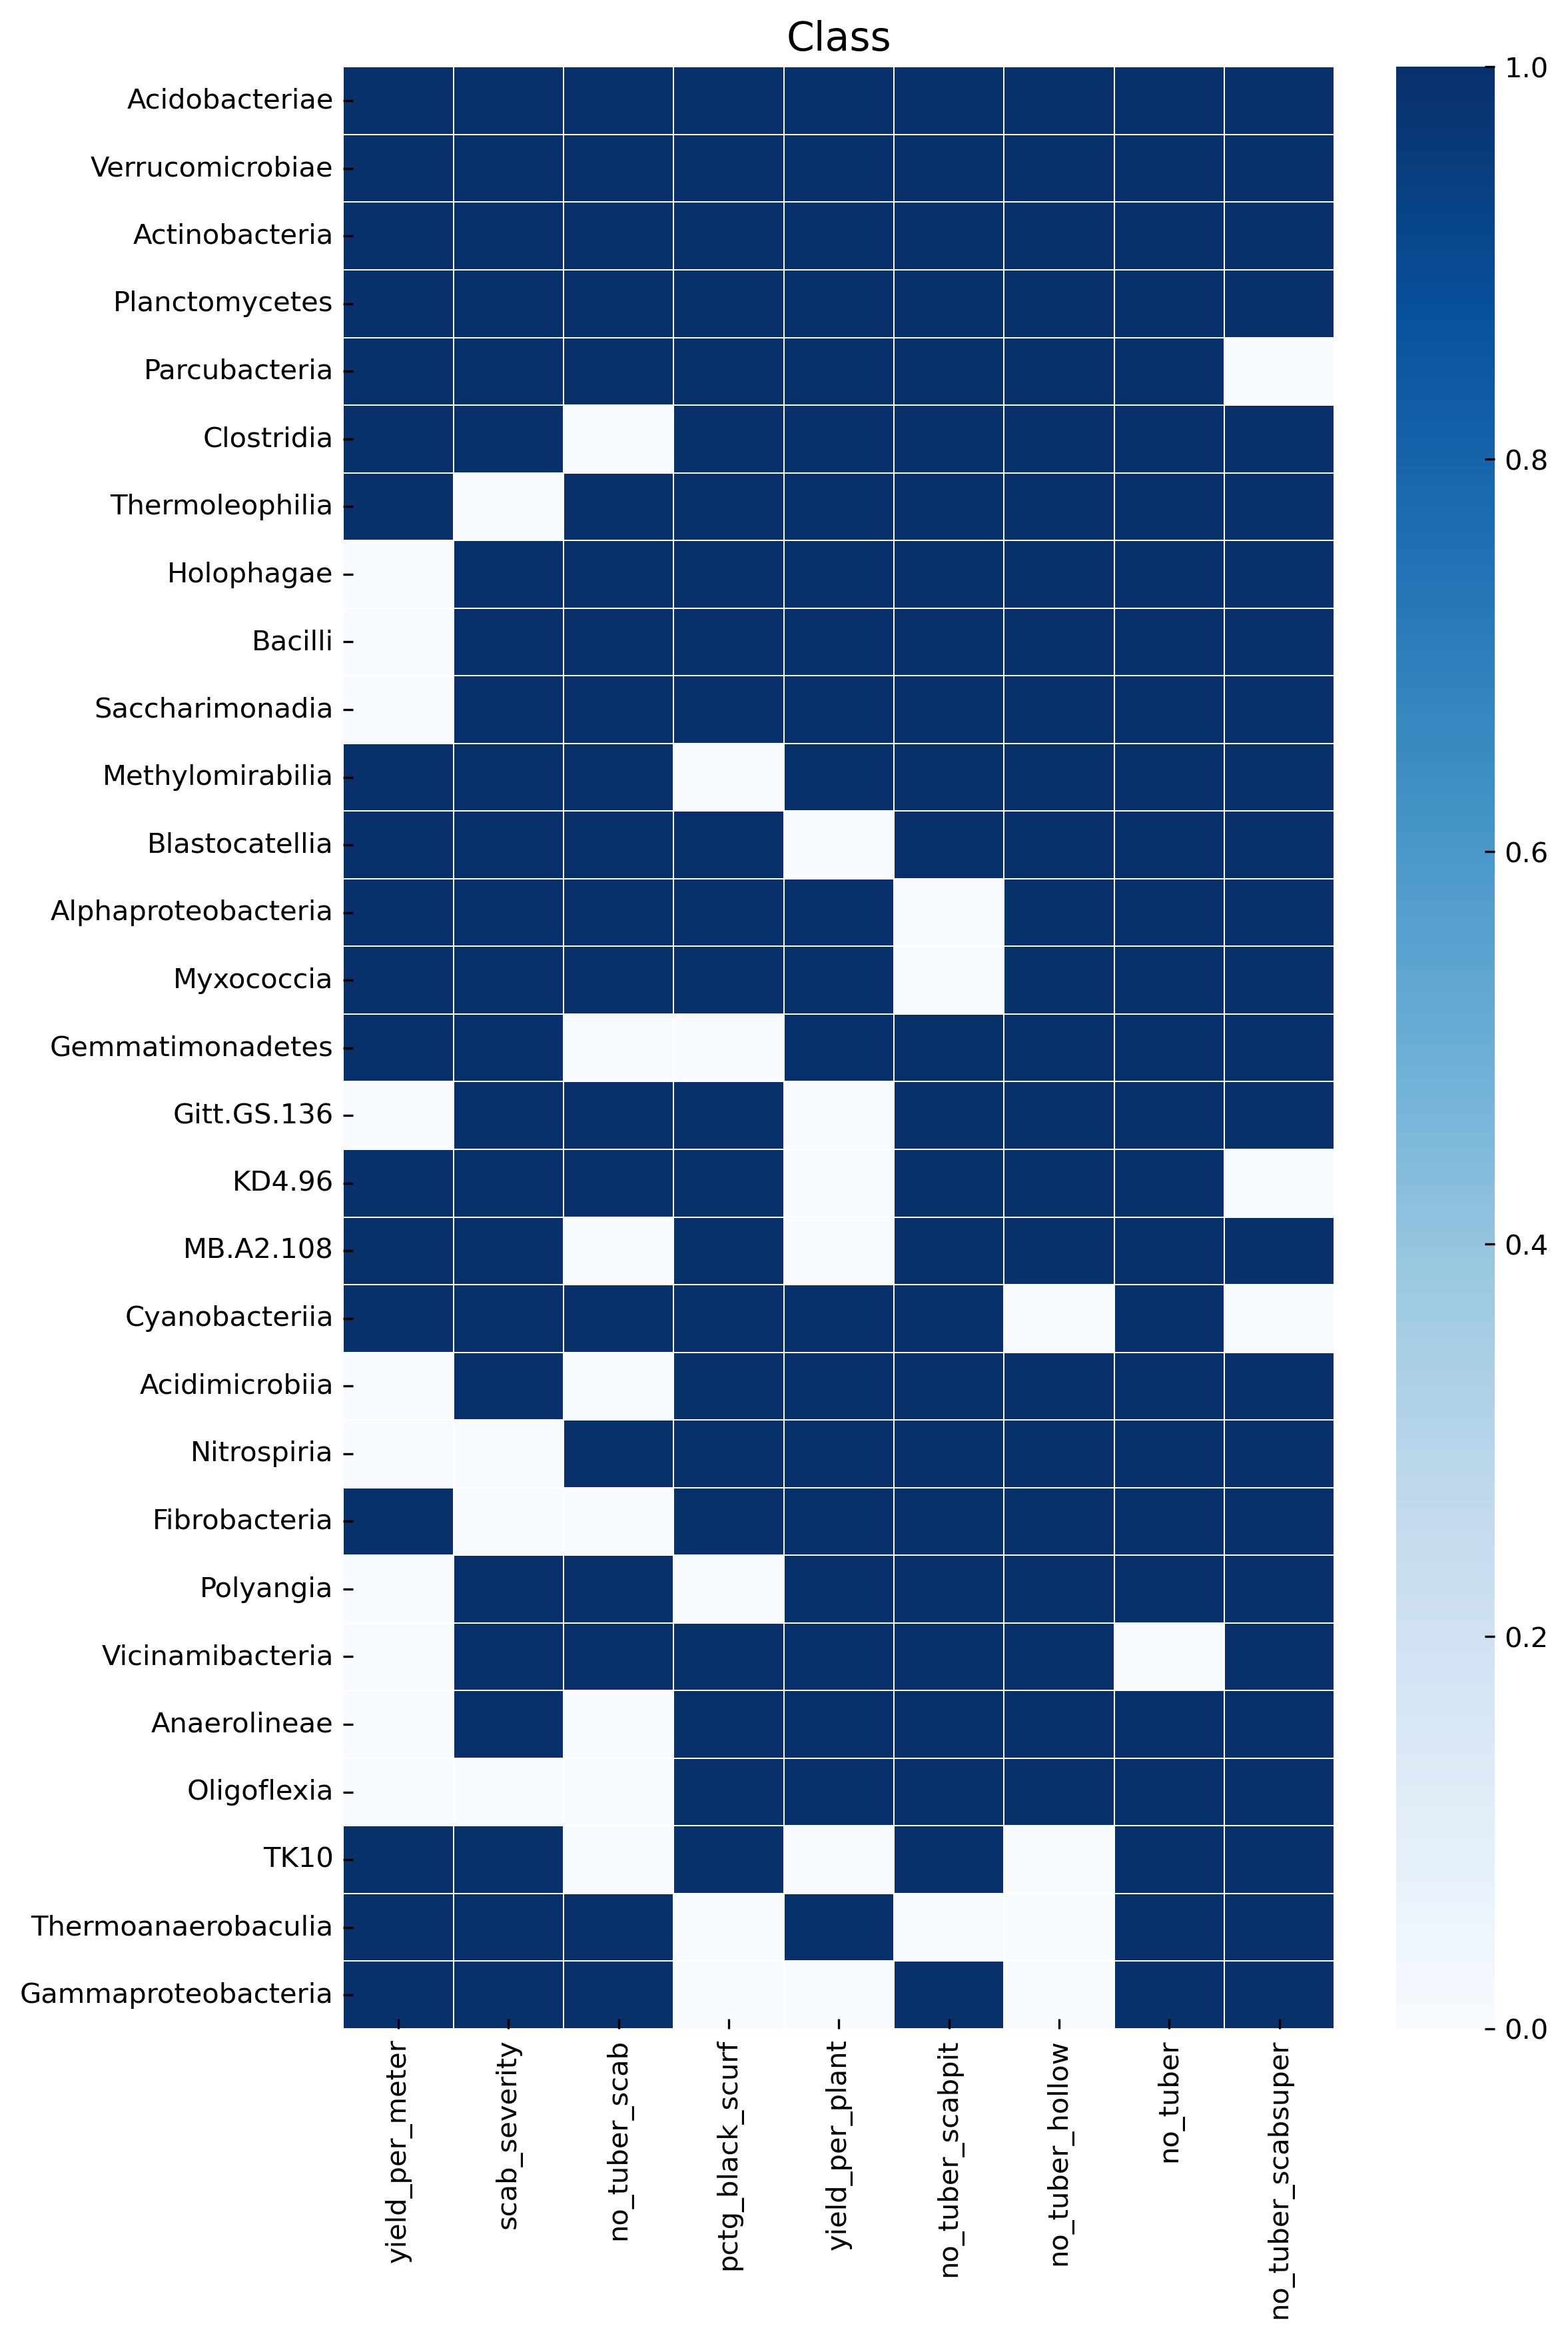

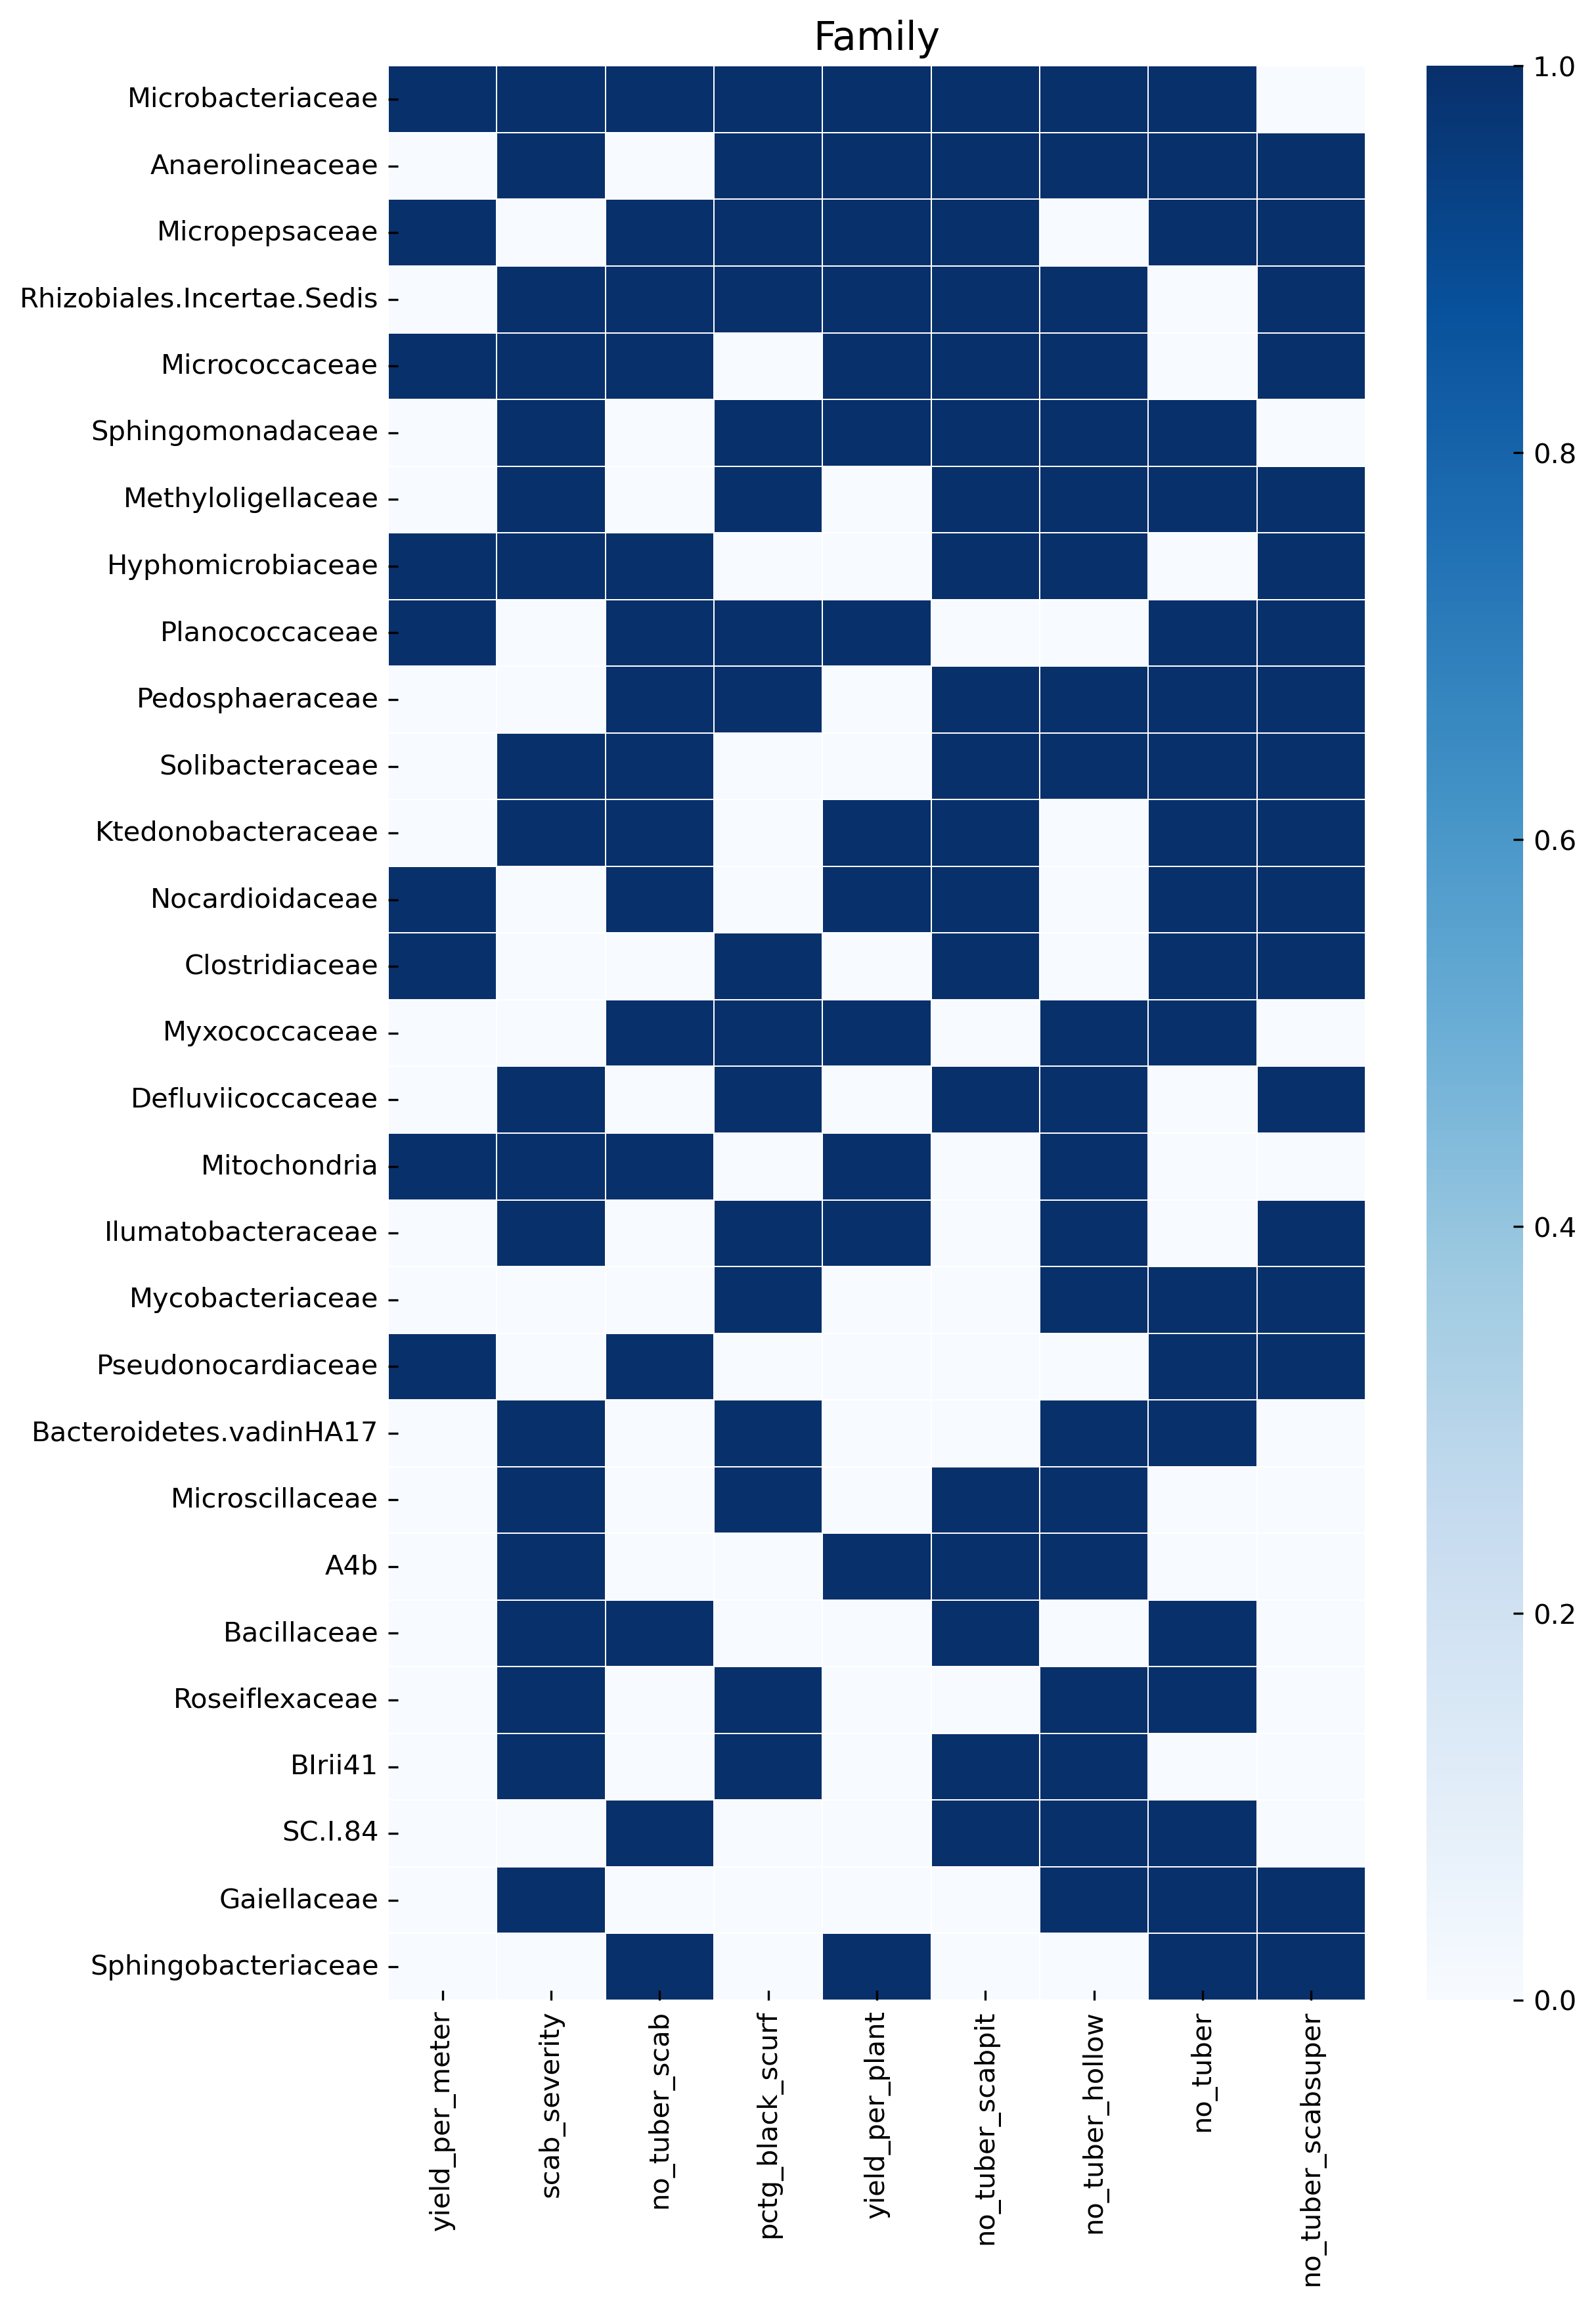

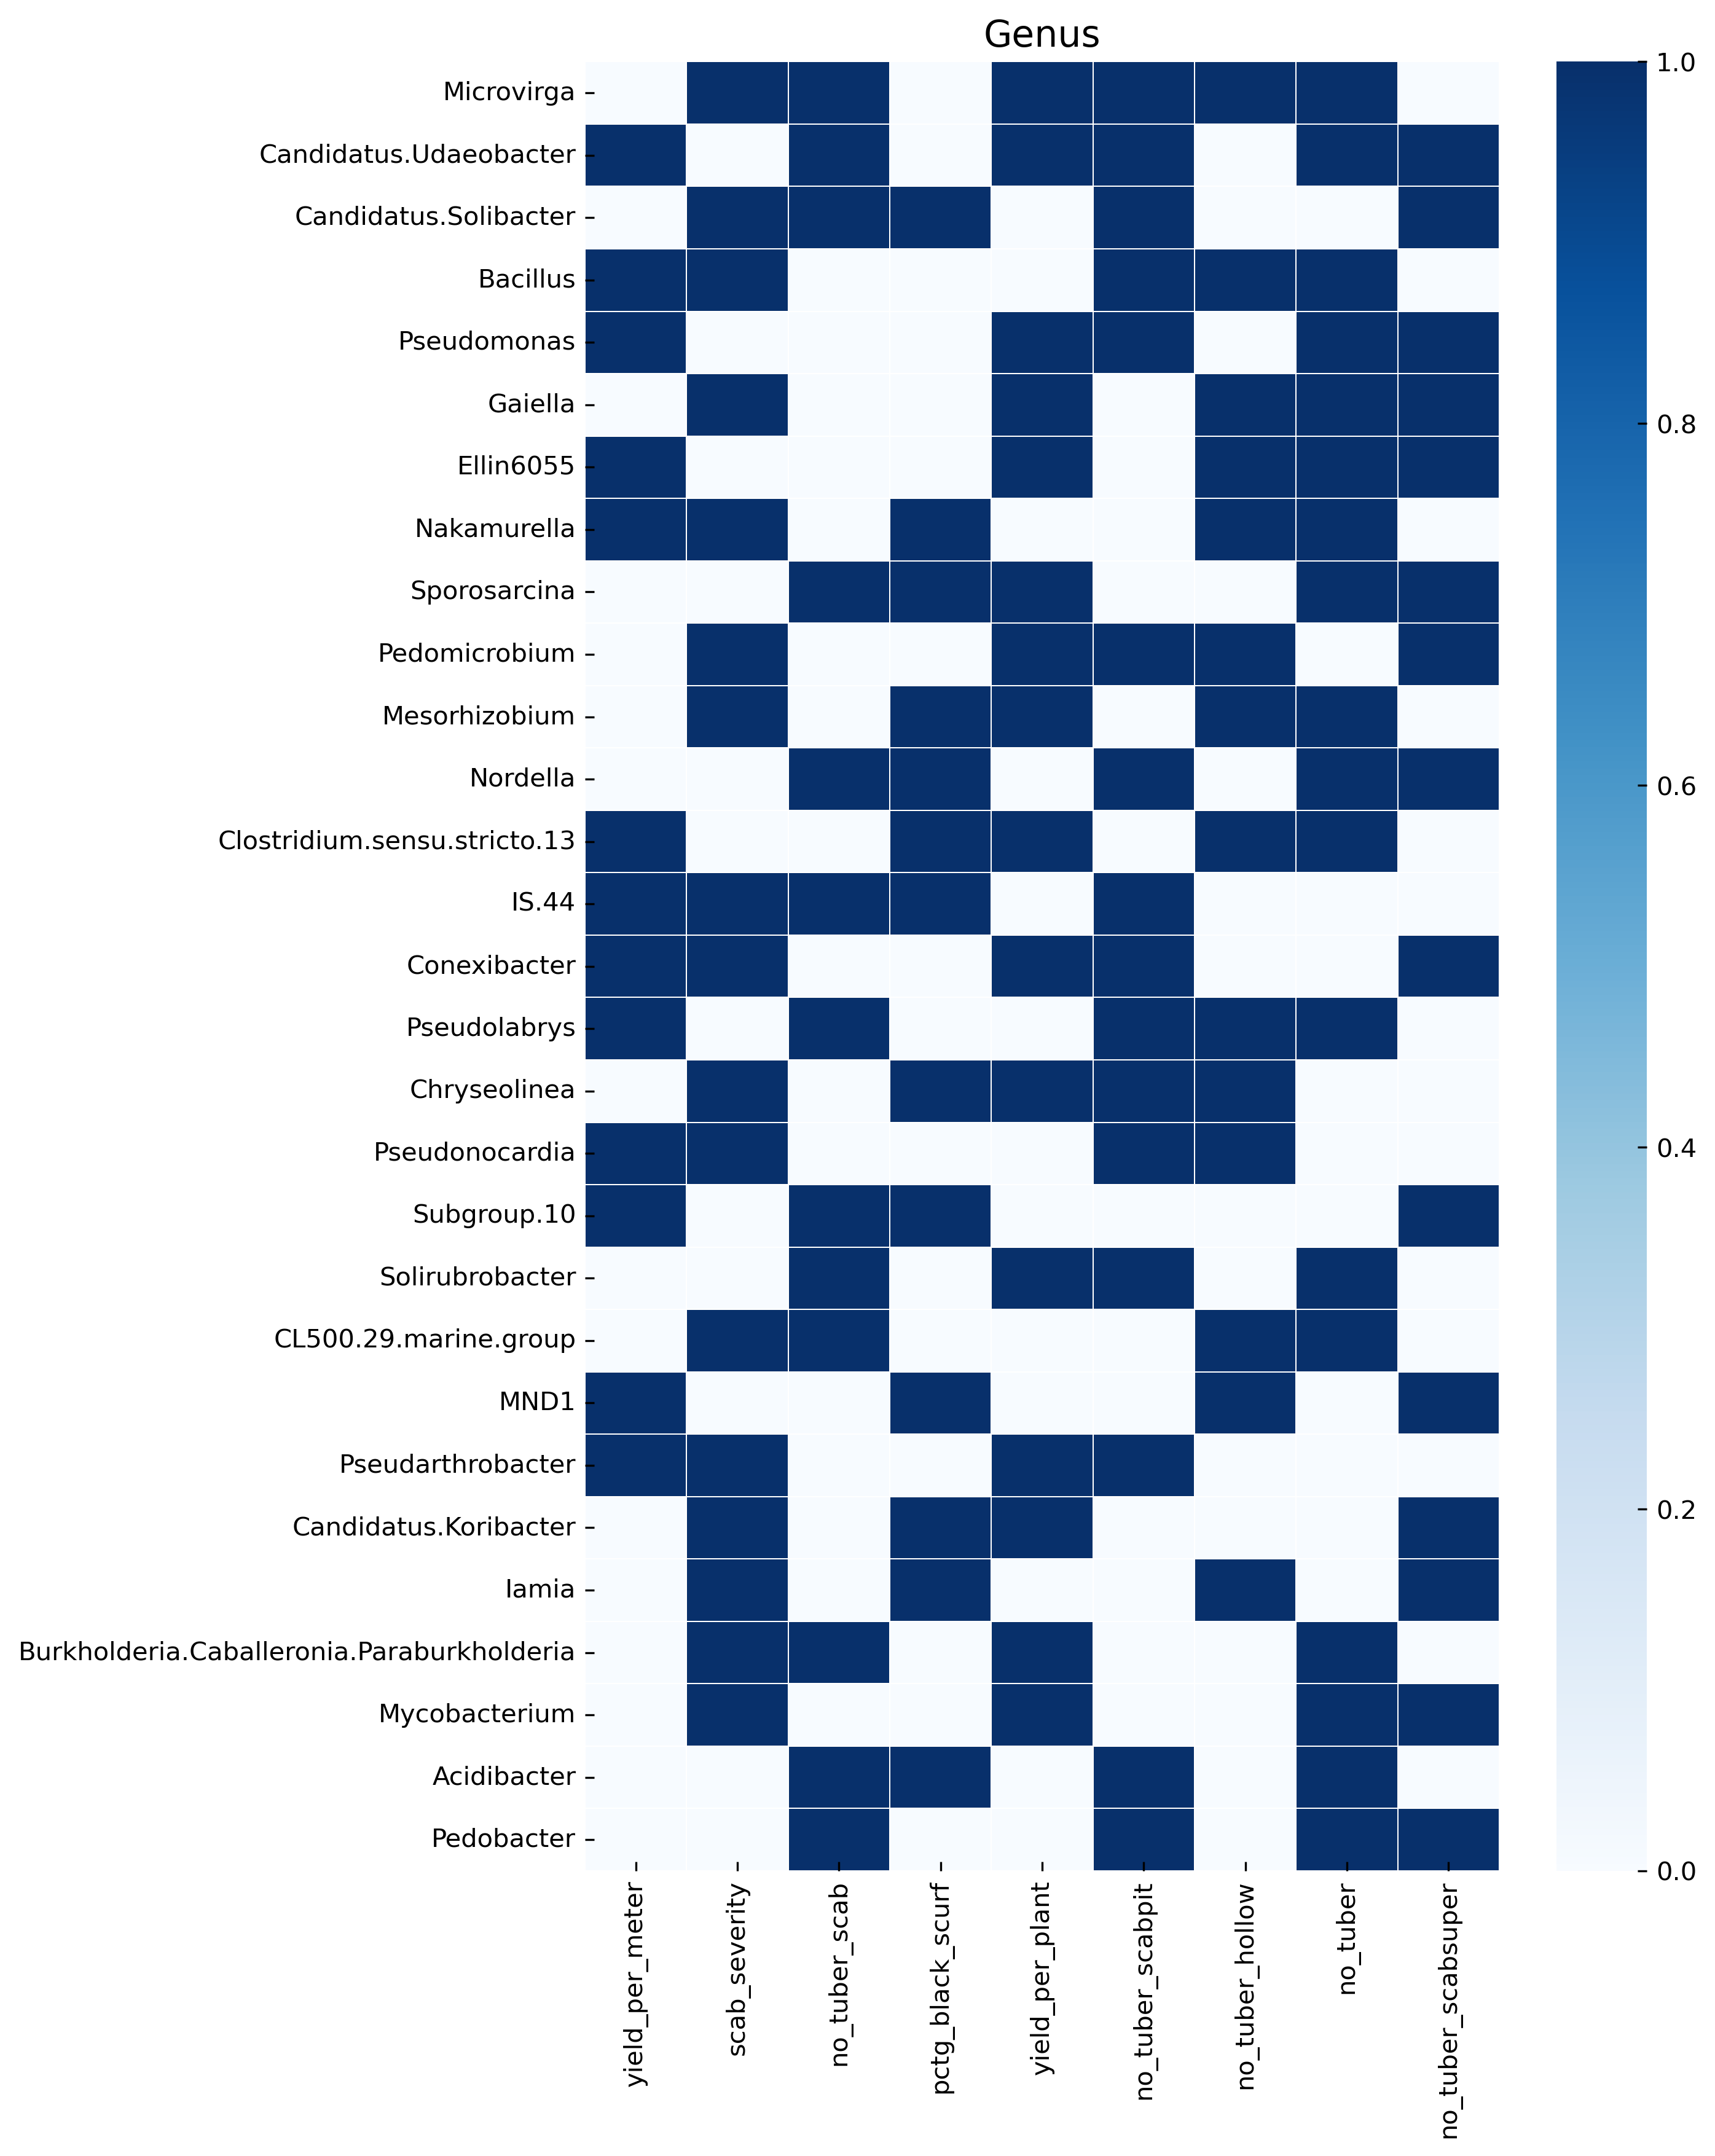

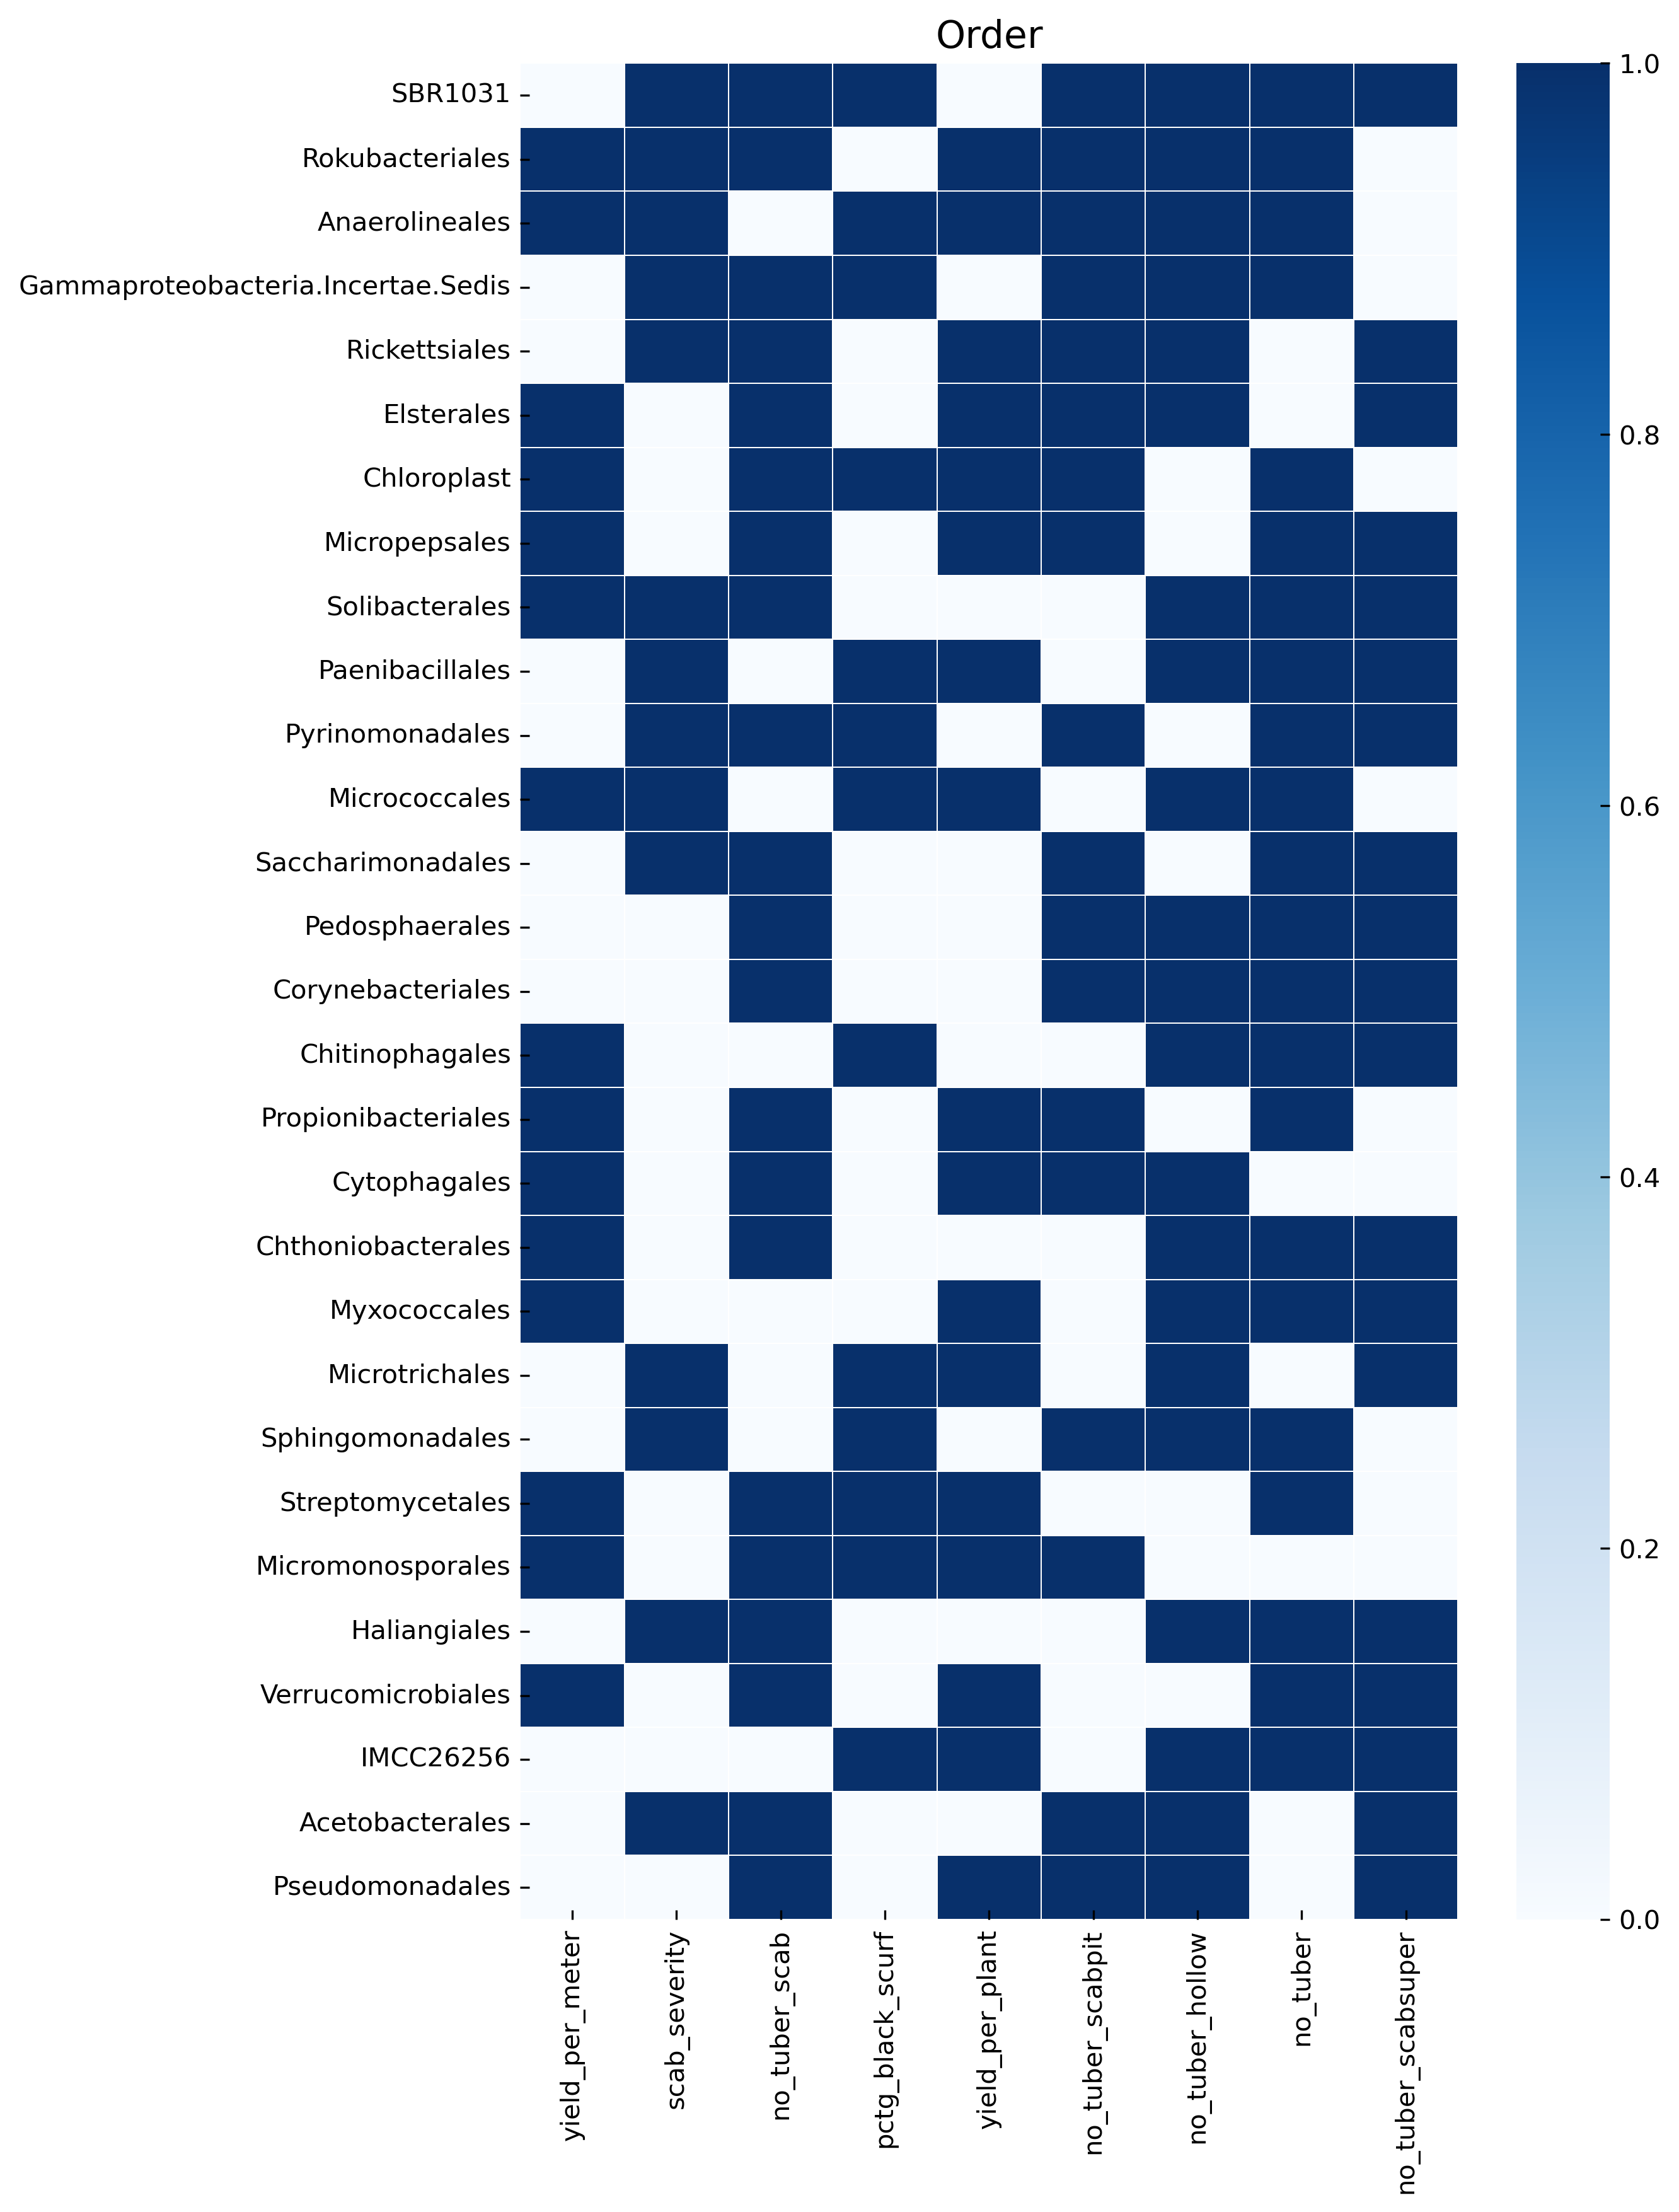

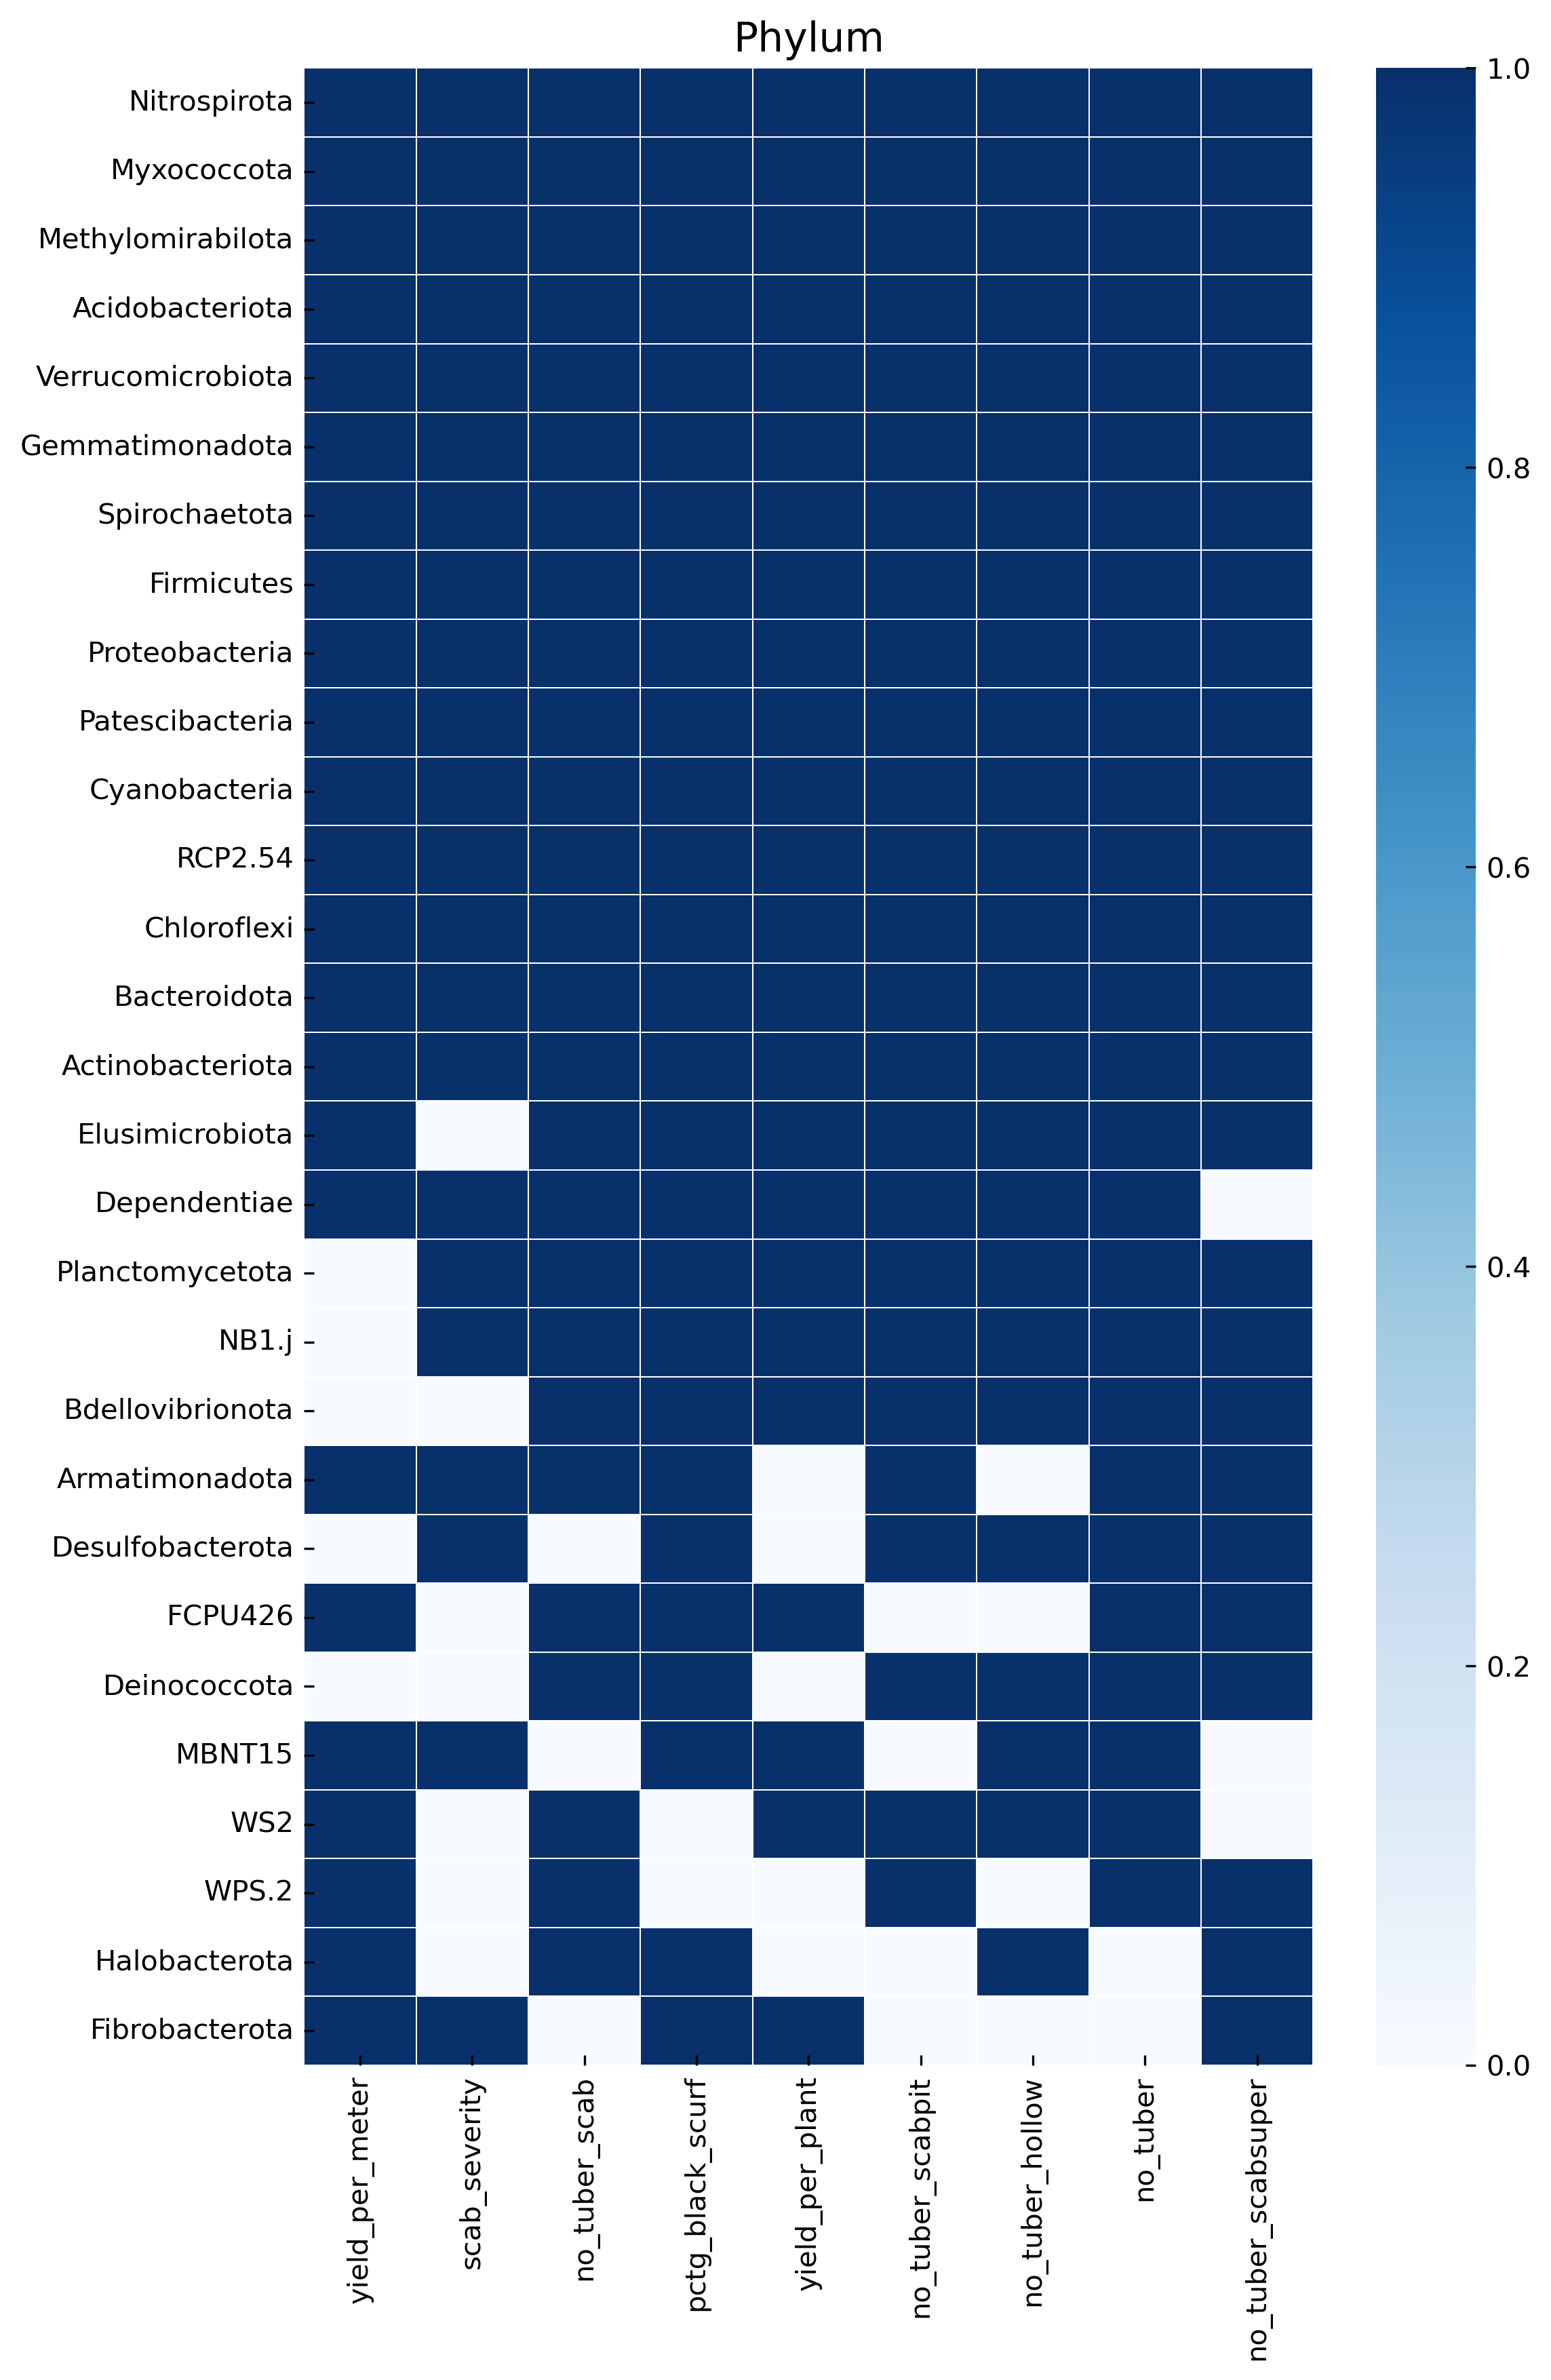

In [47]:
list_level = ['Class','Family', 'Genus', 'Order', 'Phylum']
for col in range(0,len(list_level)):
    level = list_level[col]
    print(level)
    response_list = results_dic[level].keys()
    feature_list = []
    for response in response_list:
        feature_list.append(results_dic[level][response])
    feature_list = [item for subitem in feature_list for item in subitem]
    feature_list = np.unique(feature_list)
    print(len(feature_list))
    matrix_df = pd.DataFrame(columns = response_list, index = feature_list)
    for response in response_list:
        for feature in feature_list:
            if feature in results_dic[level][response].values:
                matrix_df[response].loc[feature] = 1
            else:
                matrix_df[response].loc[feature] = 0

    matrix_df['Sum'] = 0
    for index in matrix_df.index:
        matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)
    
    matrix_df.sort_values(by='Sum', ascending=False, inplace=True)
    matrix_df=matrix_df.iloc[1:30,:]
    plt.figure(figsize=(8,13), dpi=300)
    sns.heatmap(matrix_df.drop(columns='Sum').astype('float'),
           linewidths=.1,cmap="Blues", vmin=0, vmax=1)
    plt.title(level)
    plt.savefig(path_figure+level+'Feauture.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

# Feature Selection Netcomi

In [48]:
data_path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response_netcomi_compare'

path_list = []

for root, dirs, files in os.walk(data_path, topdown=False):
    for path in dirs:
        path_list.append(path)

In [80]:
list_level = ['Class', 'Family', 'Genus', 'Order', 'Phylum']

all_data = dict.fromkeys(dirs)

for folder in path_list:
    
    all_data[folder] = dict.fromkeys(list_level)
    temp_path = data_path+'/'+folder
    temp_file_list = os.listdir(temp_path)
    for file in temp_file_list:
        if 'Count' in file:
            level = file.split('_')[-1][:-4]
            data_temp = pd.read_csv(data_path+'/'+folder+'/'+file,delim_whitespace=True)
            data_temp.sort_values(by='dif_close', ascending=False, inplace=True)
            #all_data[folder][level] = data_temp.iloc[range(0,max(40, round(len(data_temp)/3)))]
            all_data[folder][level] = data_temp.iloc[range(0,min(50, round(len(data_temp)/2)))]

print('Done.')

Done.


In [ ]:
list_level = ['Class','Family', 'Genus', 'Order', 'Phylum']
for col in range(0,len(list_level)):
    level = list_level[col]
    print(level)
    response_list = path_list
    feature_list = []
    for response in response_list:
        feature_list.append(all_data[folder][level].index)
    feature_list = [item for subitem in feature_list for item in subitem]
    feature_list = np.unique(feature_list)
    print(len(feature_list))
    matrix_df = pd.DataFrame(columns = response_list, index = feature_list)
    for response in response_list:
        for feature in feature_list:
            if feature in all_data[response][level].index:
                matrix_df[response].loc[feature] = 1
            else:
                matrix_df[response].loc[feature] = 0

    matrix_df['Sum'] = 0
    for index in matrix_df.index:
        matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)
    
    matrix_df.sort_values(by='Sum', ascending=False, inplace=True)
    matrix_df=matrix_df.iloc[1:30,:]
    plt.figure(figsize=(8,13), dpi=300)
    sns.heatmap(matrix_df.drop(columns='Sum').astype('float'),
           linewidths=.1,cmap="Blues", vmin=0, vmax=1)
    plt.title(level)
    plt.savefig(path_figure+level+'FeautureNetcomi.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

# Intersection between ML and Netcomi

In [54]:
data_path2 = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response_type_compare'

In [55]:
path_list2 = []
#reading files in folder response
for root, dirs, files in os.walk(data_path2, topdown=False):
    for path in dirs:
        path_list2.append(path)
#reading sheet name       
wb = openpyxl.load_workbook(data_path2+'/'+path+'/feature_selection.xlsx')
sheet_list = wb.sheetnames

results_dic = dict.fromkeys(sheet_list)

for sheet_name in results_dic.keys():
    temp_df = pd.DataFrame(columns=path_list2, index=range(0,700))
    for folder in path_list2:
        data_temp = pd.read_excel(data_path2+'/'+folder+'/feature_selection.xlsx', sheet_name=sheet_name)
        temp_df[folder].iloc[
            range(0, len(data_temp['Unnamed: 0'].values))] = data_temp['Unnamed: 0'].values

    results_dic[sheet_name] = temp_df
    
for key in results_dic.keys():
    results_dic[key] = results_dic[key].iloc[range(0,max(30, round(len(data_temp)/3)))]

In [56]:
data_path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response_netcomi_compare'

path_list = []

for root, dirs, files in os.walk(data_path, topdown=False):
    for path in dirs:
        path_list.append(path)

In [57]:
list_level = ['Class', 'Family', 'Genus', 'Order', 'Phylum']

all_data = dict.fromkeys(dirs)

for folder in path_list:
    
    all_data[folder] = dict.fromkeys(list_level)
    temp_path = data_path+'/'+folder
    temp_file_list = os.listdir(temp_path)
    for file in temp_file_list:
        if 'Count' in file:
            level = file.split('_')[-1][:-4]
            data_temp = pd.read_csv(data_path+'/'+folder+'/'+file,index_col=0)
            data_temp.sort_values(by='dif_close', ascending=False, inplace=True)
            #all_data[folder][level] = data_temp.iloc[range(0,max(40, round(len(data_temp)/3)))]
            all_data[folder][level] = data_temp.iloc[range(0,max(30, round(len(data_temp)/3)))]
            #print(level,":",max(30 ,round(len(data_temp)/3)))

print('Done.')

Done.


Class
93


/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_3790/4025514878.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)


Family
186


/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_3790/4025514878.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)


Genus
306


/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_3790/4025514878.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)


Order
168


/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_3790/4025514878.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)


Phylum
42


/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_3790/4025514878.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)


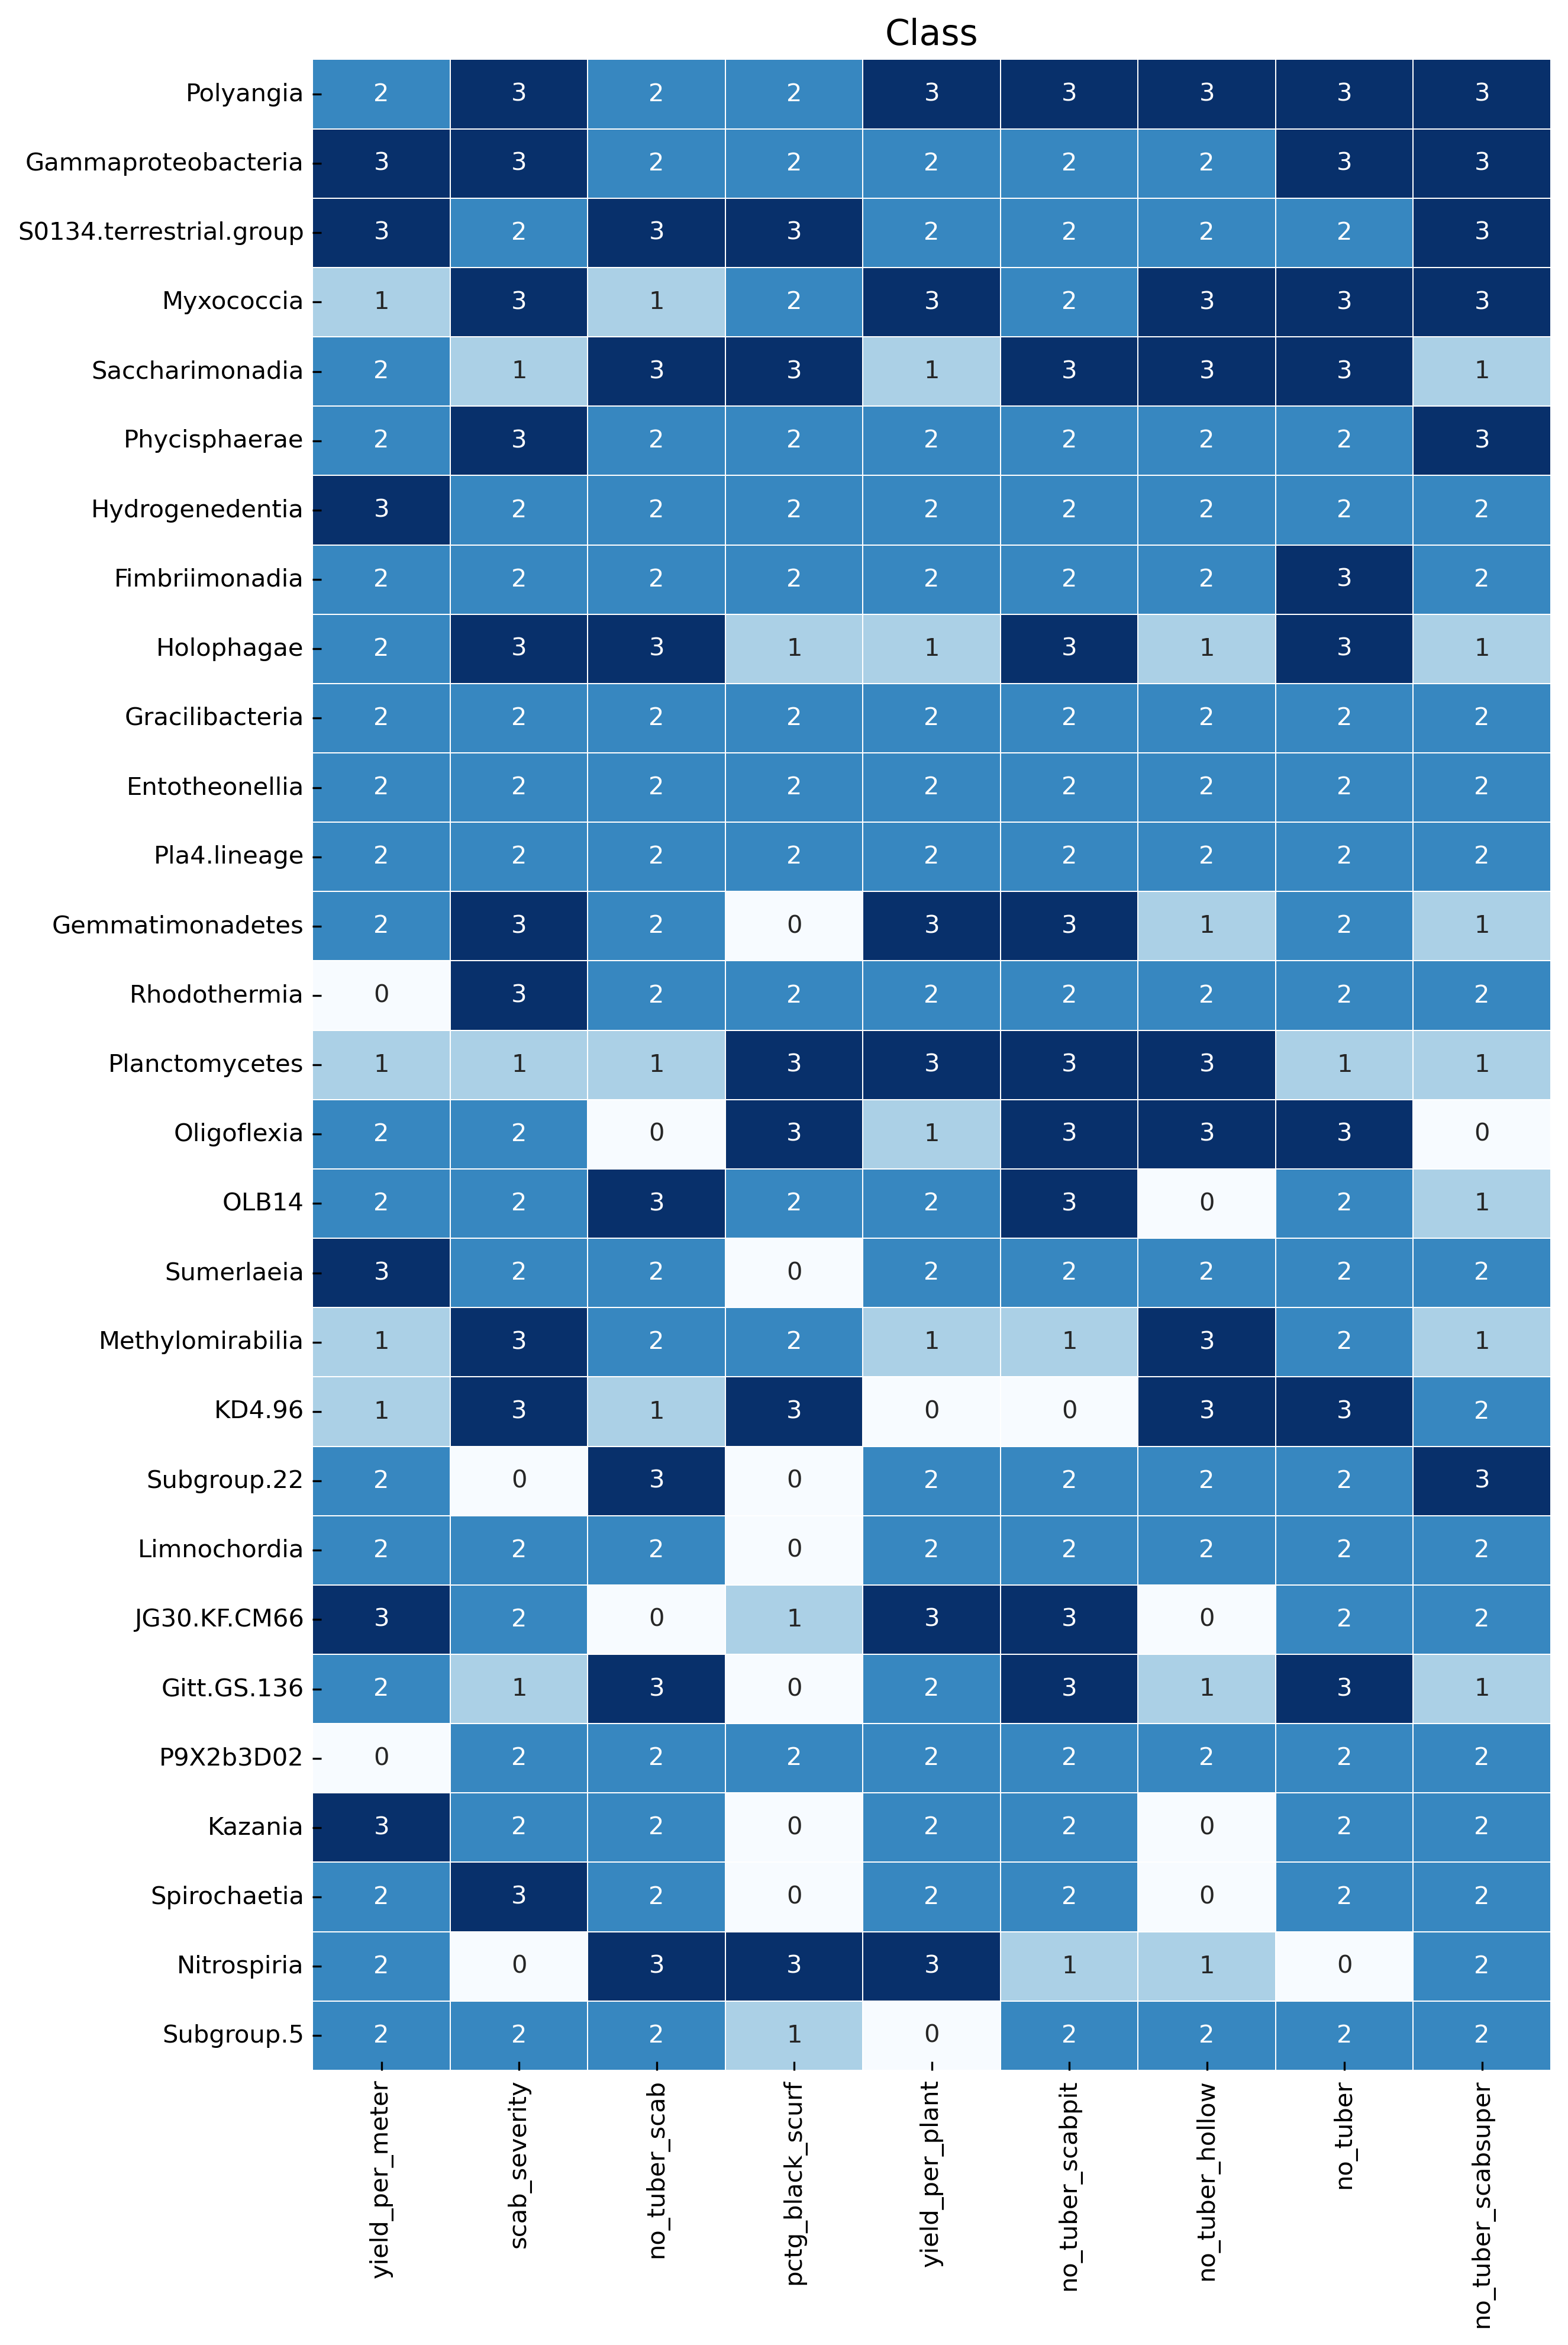

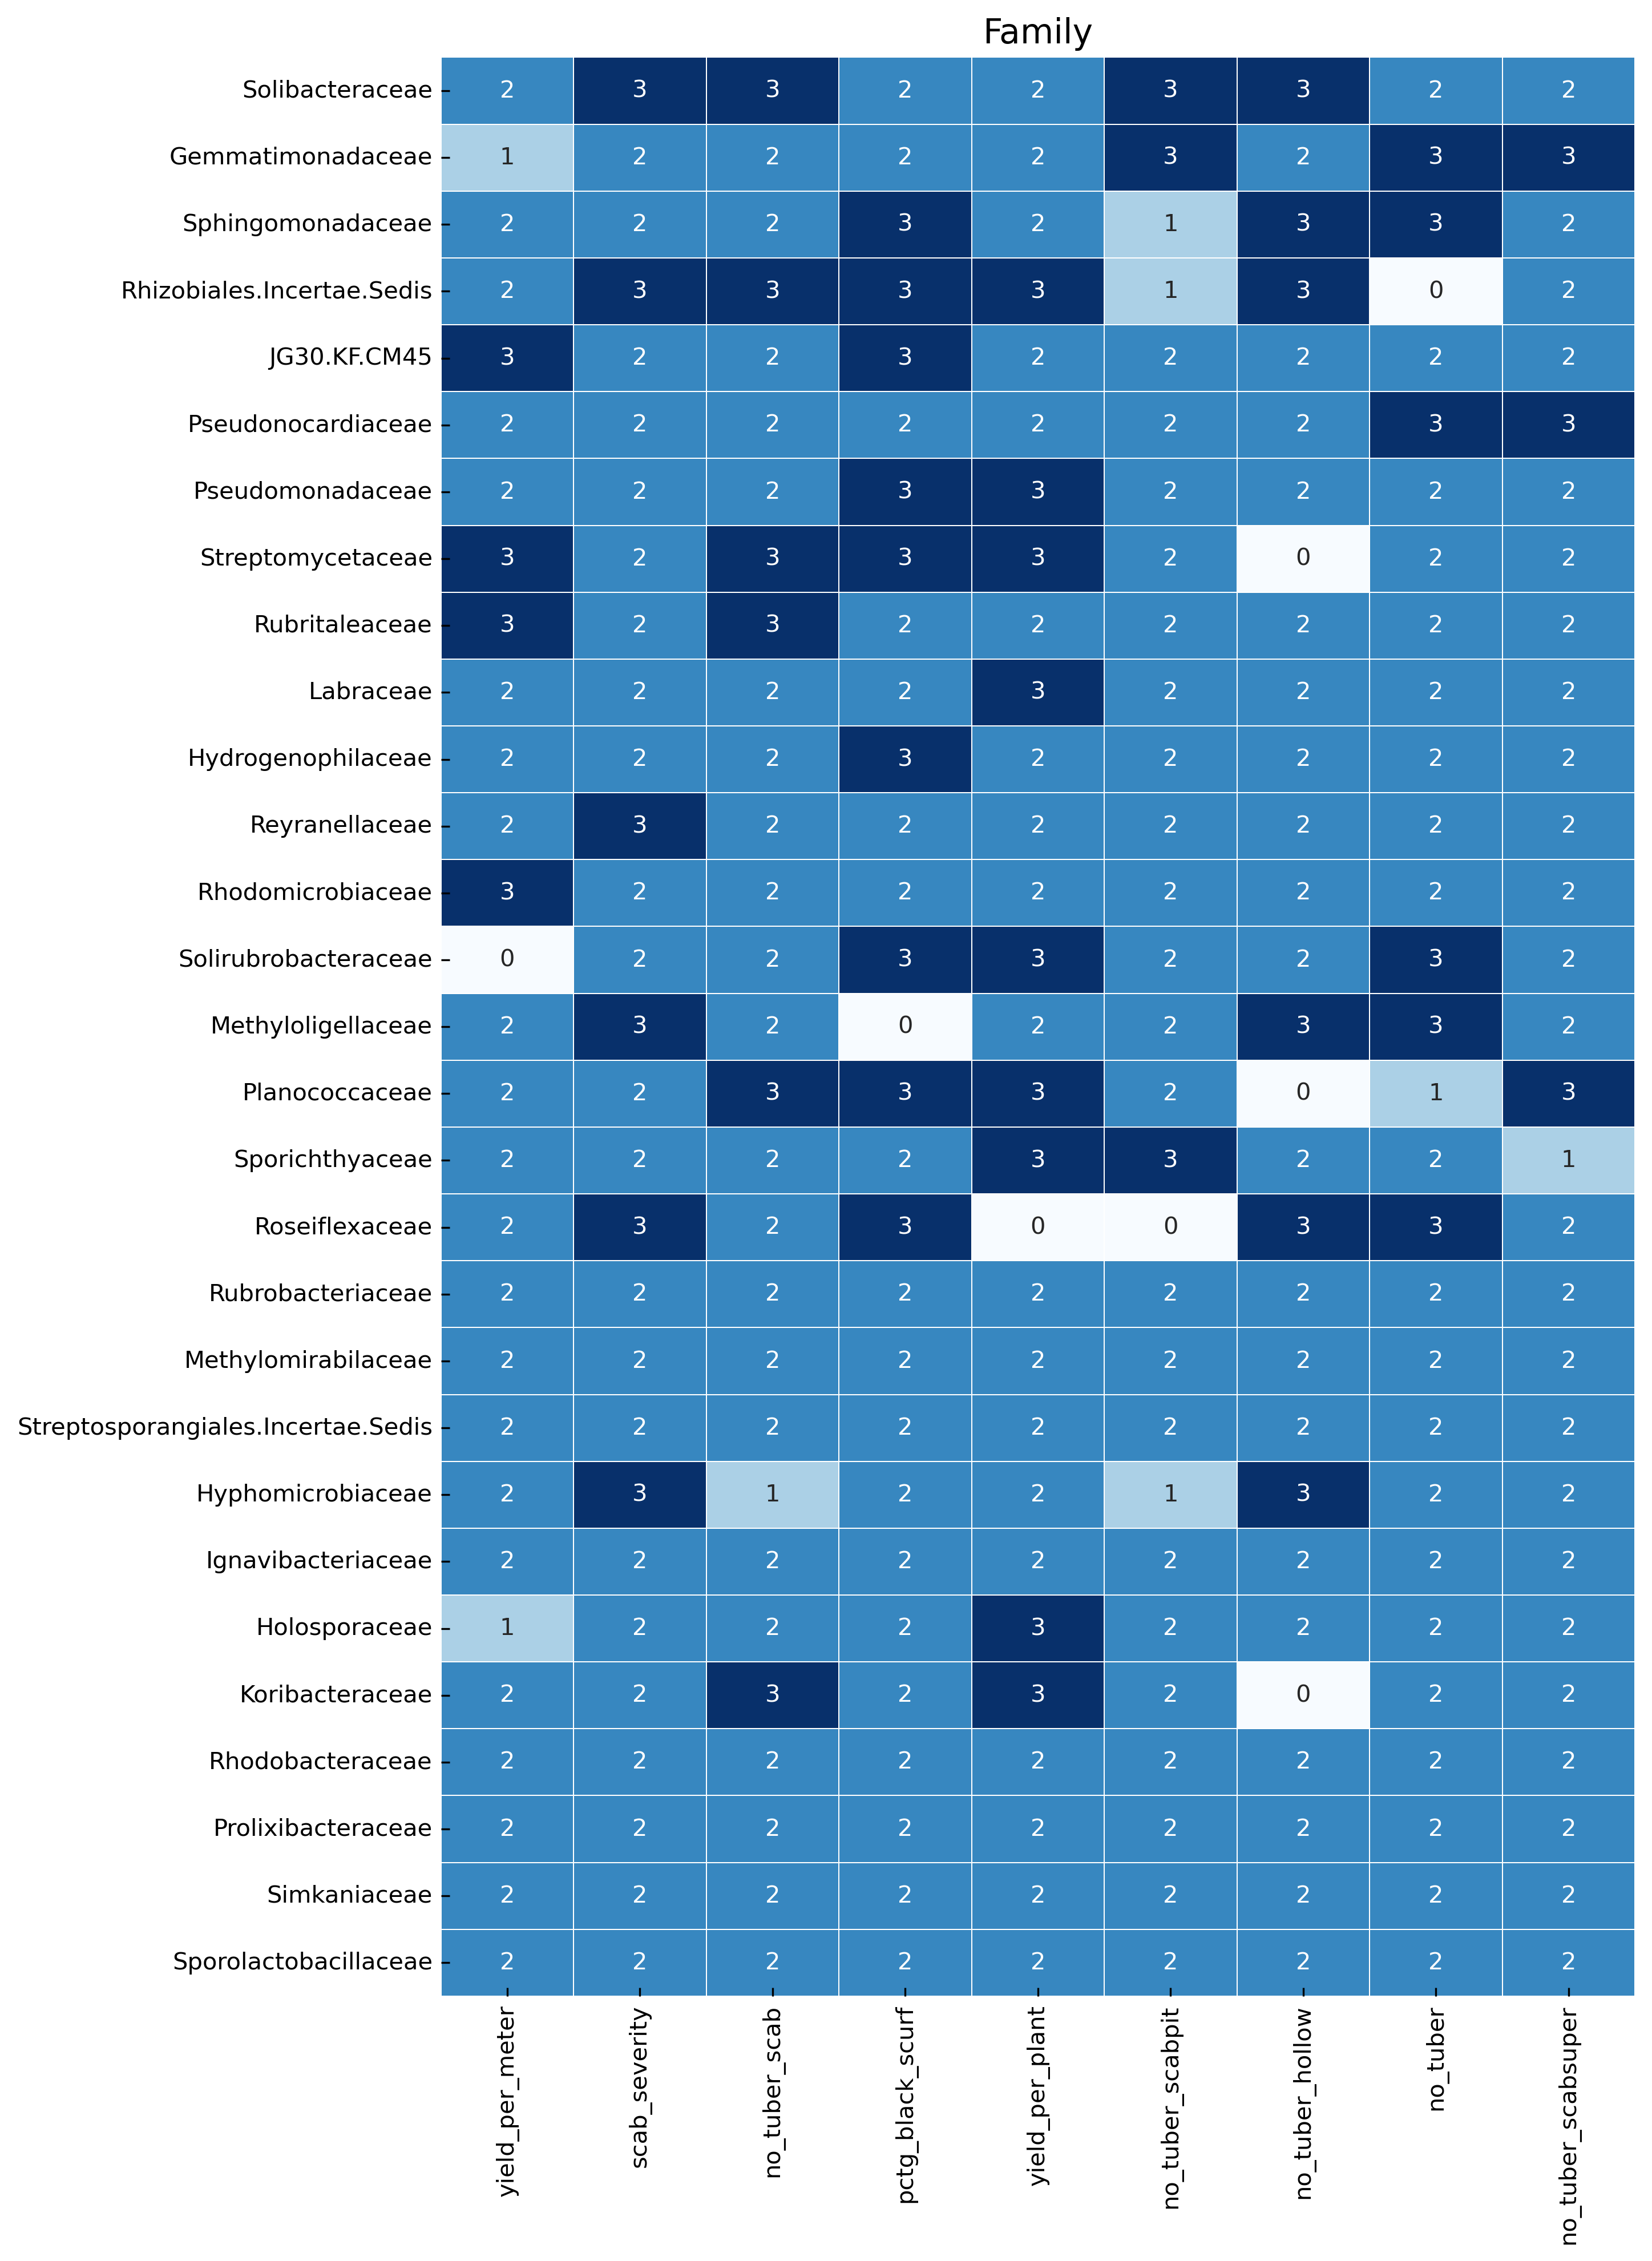

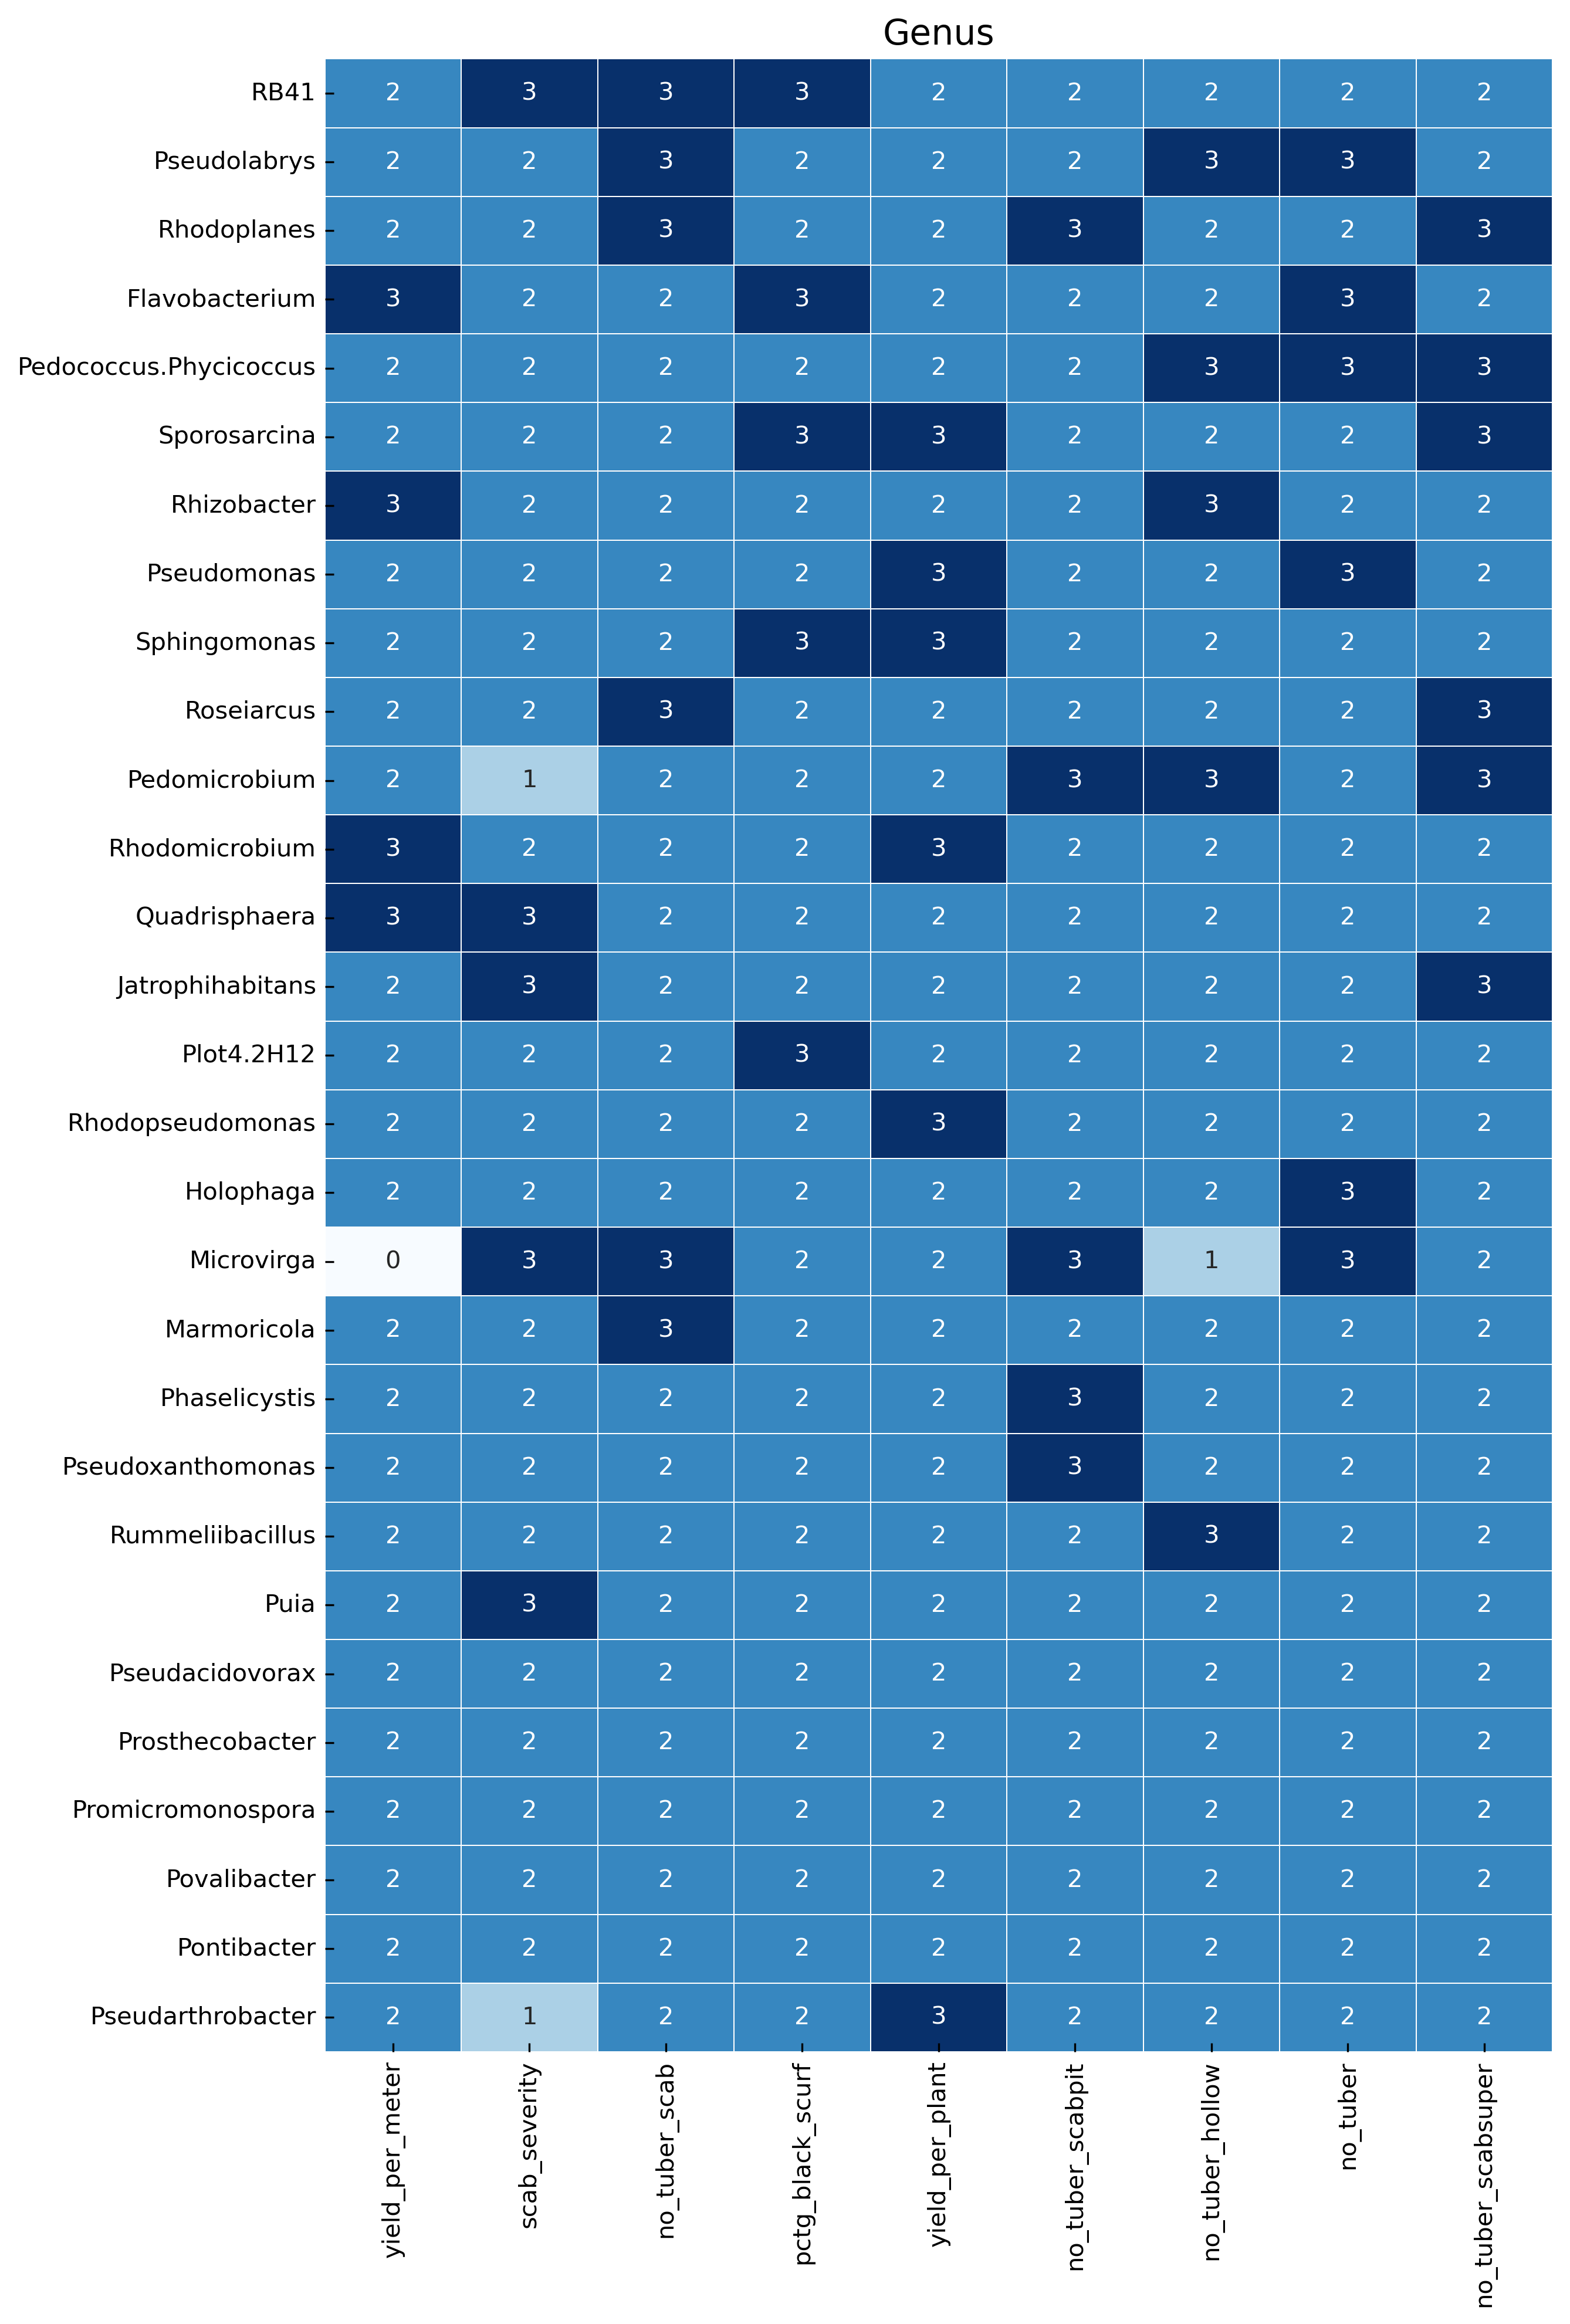

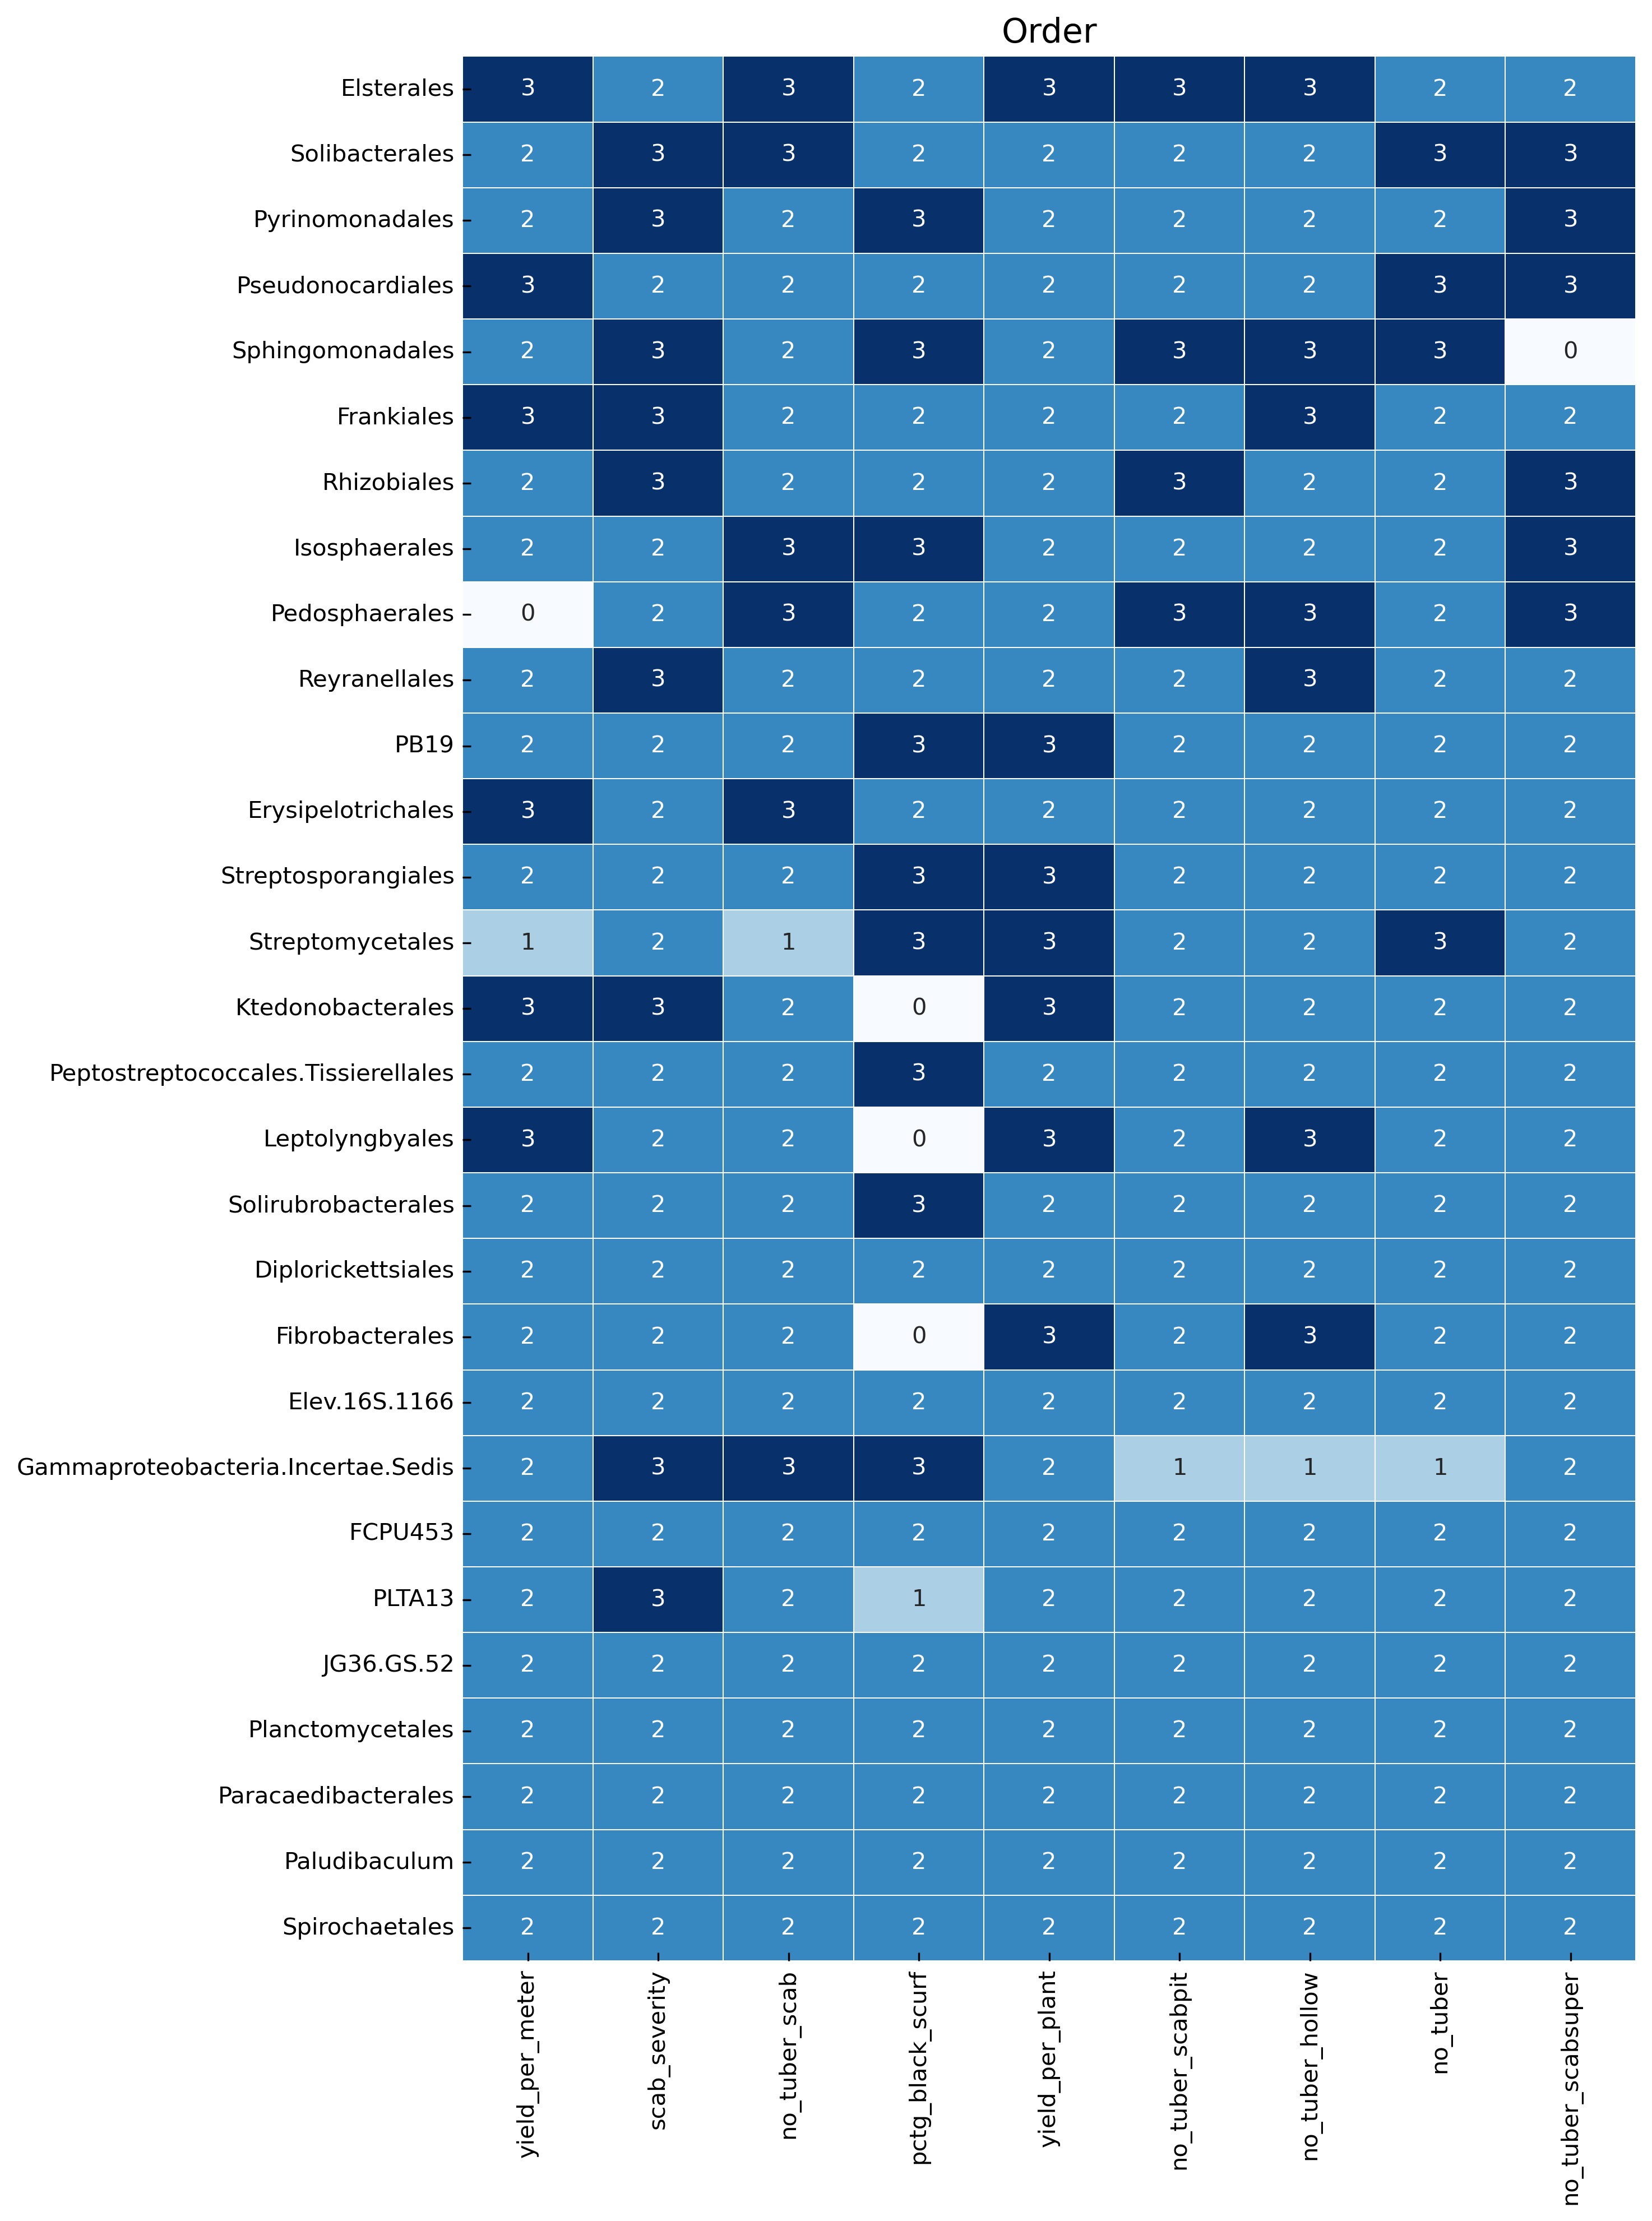

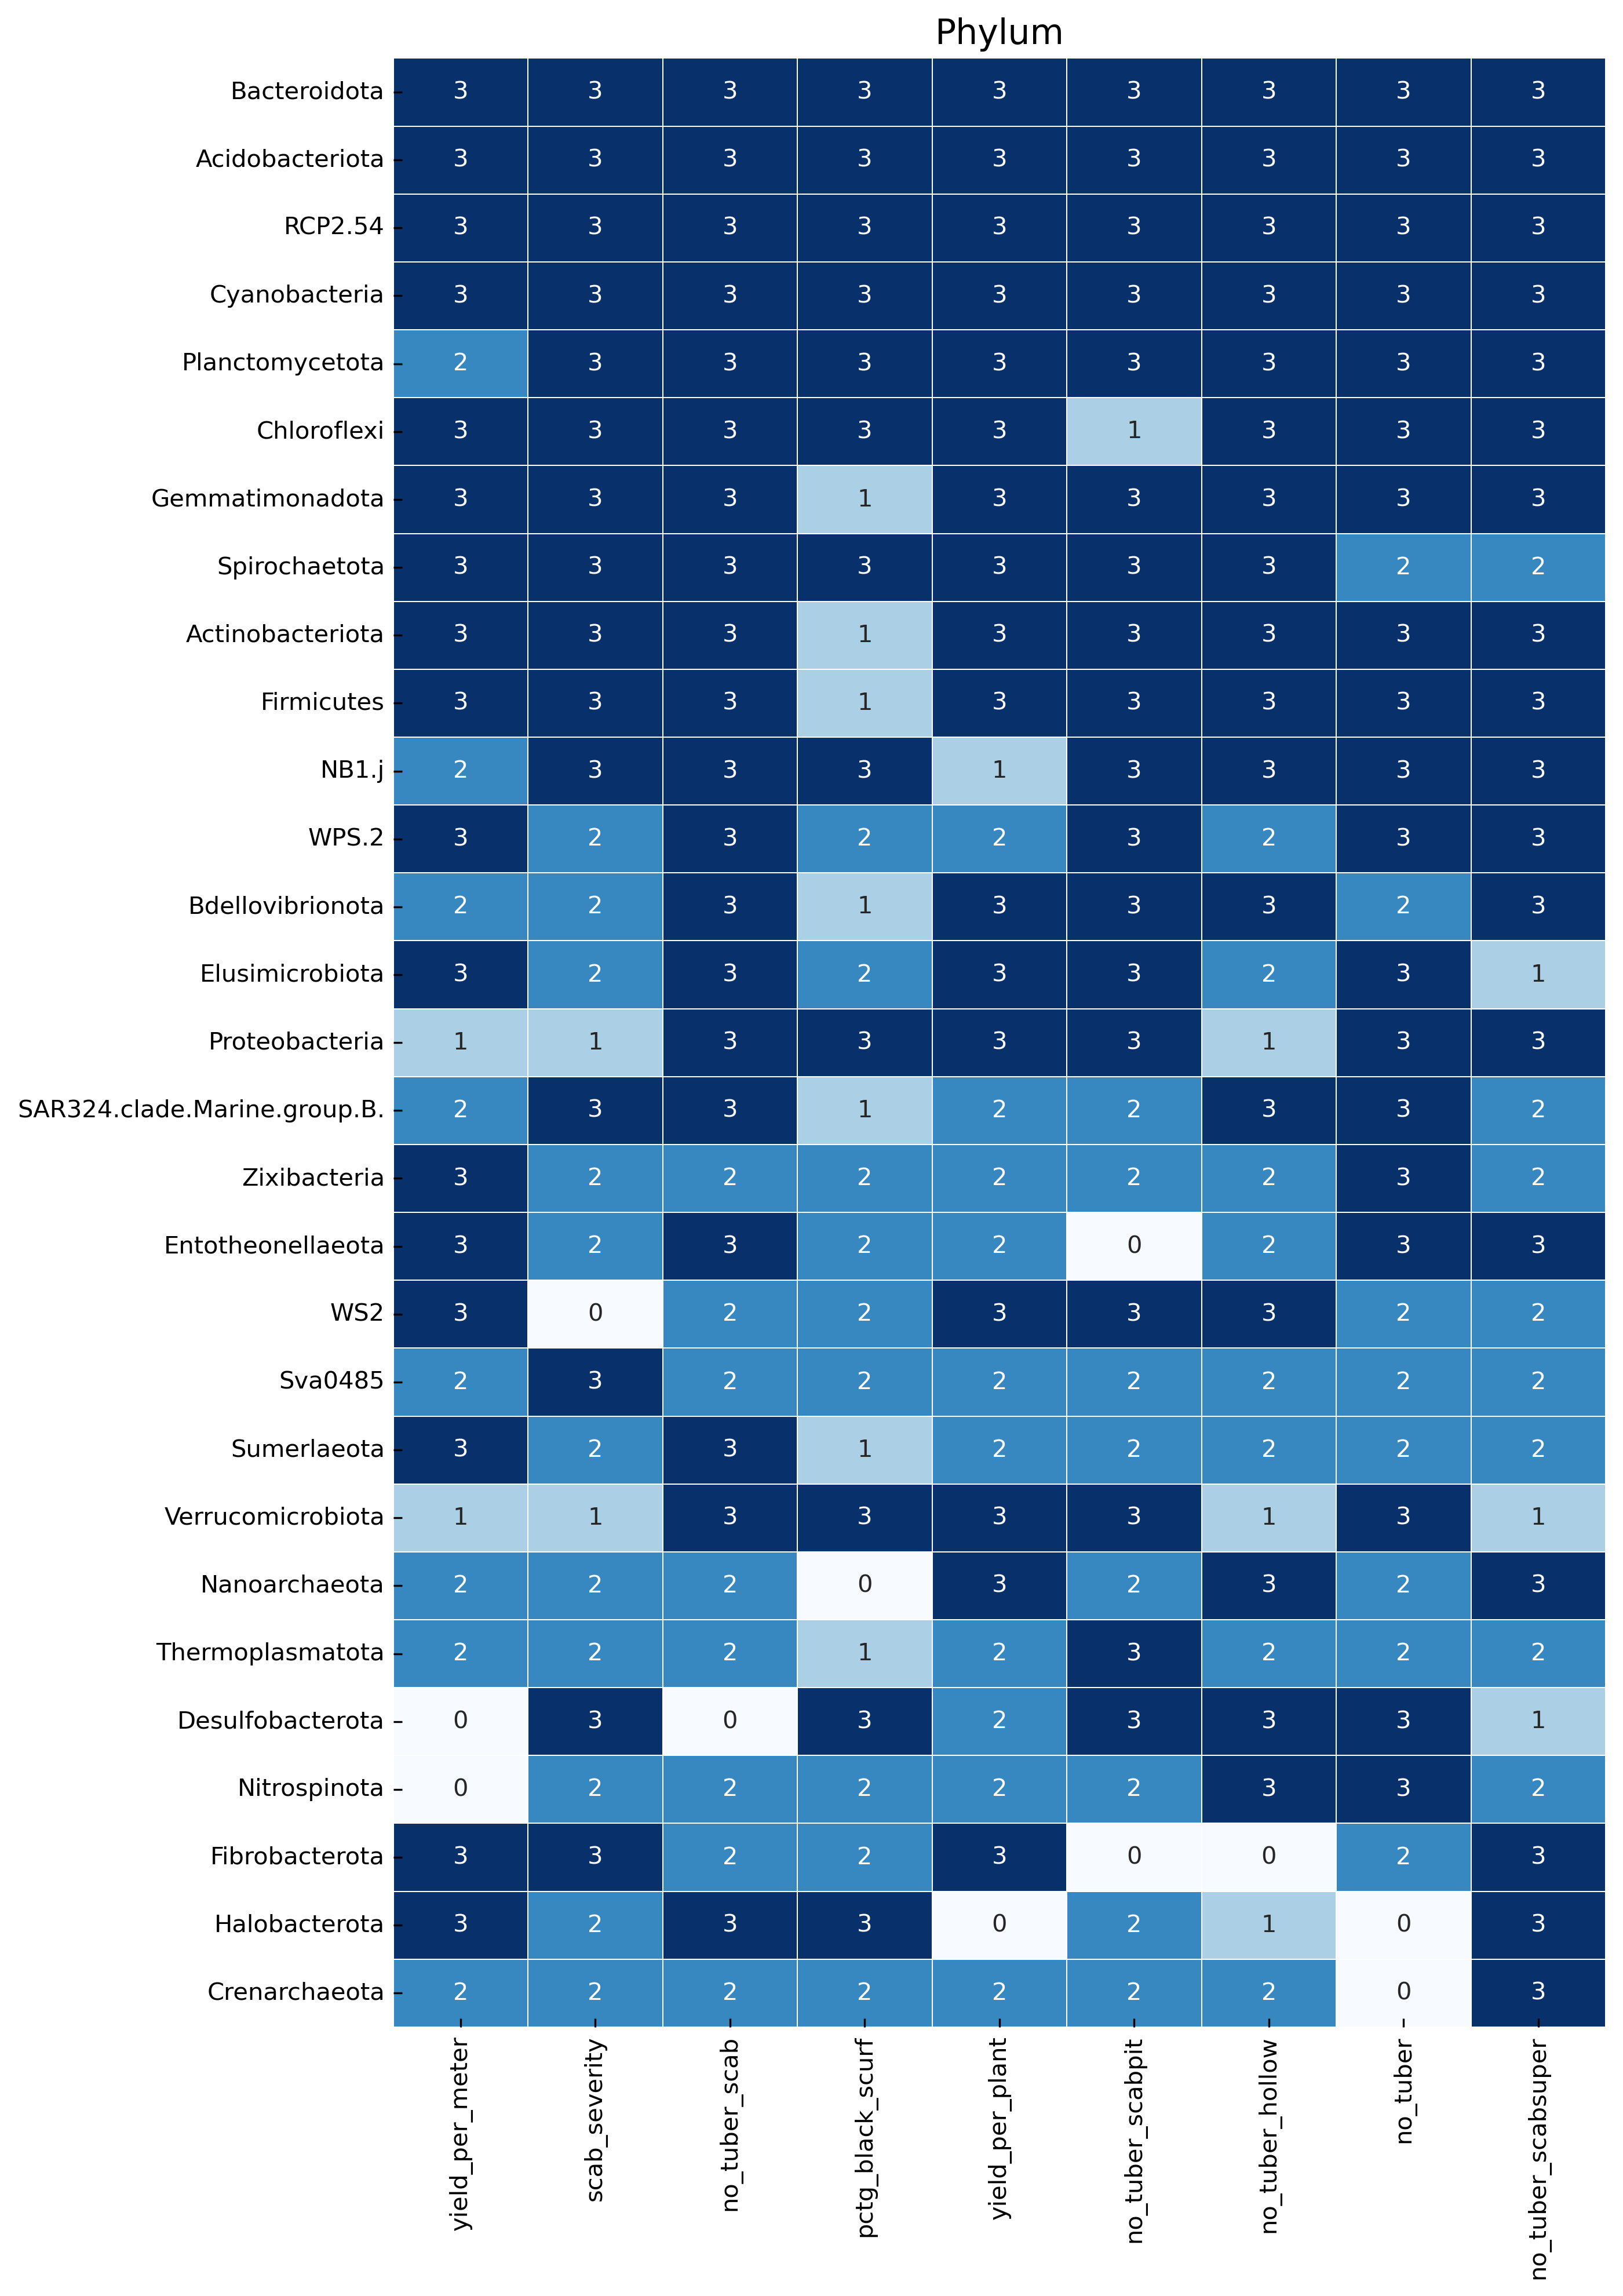

In [58]:
list_level = ['Class', 'Family', 'Genus', 'Order', 'Phylum']
for col in range(0,len(list_level)):
    level = list_level[col]
    print(level)
    response_list = path_list
    feature_list = []
    for response in response_list:
        #print(response)
        feature_list.append(all_data[response][level].index.union(results_dic[level][response][results_dic[level][response].notnull()].values))
    feature_list = [item for subitem in feature_list for item in subitem]
    feature_list = np.unique(feature_list)
    print(len(feature_list))
    matrix_df = pd.DataFrame(columns = response_list, index = feature_list)
    for response in response_list:
        for feature in feature_list:
                if (feature in all_data[response][level].index) & (feature in results_dic[level][response].values):
                    matrix_df[response].loc[feature] = 3
                elif(feature in all_data[response][level].index) &(feature not in results_dic[level][response].values):
                    matrix_df[response].loc[feature] = 2##NetComi
                elif (feature not in all_data[response][level].index) &(feature in results_dic[level][response].values):
                    matrix_df[response].loc[feature] = 1##ML
                else:
                    matrix_df[response].loc[feature] = 0##NotMLnotNetcomi
    matrix_df['Sum'] = 0
    for index in matrix_df.index:
        matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)
    
    matrix_df.sort_values(by='Sum', ascending=False, inplace=True)
    matrix_df=matrix_df.iloc[1:30,:]
    plt.figure(figsize=(9,15), dpi=300)
    sns.heatmap(matrix_df.drop(columns='Sum').astype('float'),
           linewidths=.1, vmin=0, vmax=3,annot=True, cbar=False,cmap="Blues")#cmap="Blues"
    plt.title(level)
    plt.savefig(path_figure+level+'FeautureNetcomi_withoutNA.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

In [81]:
# list_level = ['Class', 'Family', 'Genus', 'Order', 'Phylum']
# for col in range(0,len(list_level)):
#     level = list_level[col]
#     print(level)
#     SELECTED_FEATURE[level]=dict.fromkeys(dirs)
#     response_list = path_list
#     feature_list = []
#     for response in response_list:
#         feature_list.append(all_data[response][level].index.union(results_dic[level][response][results_dic[level][response].notnull()].values))
#     feature_list = [item for subitem in feature_list for item in subitem]
#     feature_list = np.unique(feature_list)
#     print(len(feature_list))
#     matrix_df = pd.DataFrame(columns = response_list, index = feature_list)
#     for response in response_list:
#         for feature in feature_list:
#                 if (feature in all_data[response][level].index) & (feature in results_dic[level][response].values):
#                     matrix_df[response].loc[feature] = 3
#                 elif(feature in all_data[response][level].index) &(feature not in results_dic[level][response].values):
#                     matrix_df[response].loc[feature] = 2##NetComi
#                 elif (feature not in all_data[response][level].index) &(feature in results_dic[level][response].values):
#                     matrix_df[response].loc[feature] = 1##ML
#                 else:
#                     matrix_df[response].loc[feature] = 0##NotMLnotNetcomi
            
#         #print(matrix_df[response])
# #         ree=re[matrix_df[response]==3]
# #         print(ree)
# #         SELECTED_FEATURE[response][level]= ree.index     
#         print(matrix_df[response][matrix_df[response]==3].index)
#         SELECTED_FEATURE[level][response]=matrix_df[response][matrix_df[response]==3].index
#     matrix_df['Sum'] = 0
#     for index in matrix_df.index:
#         matrix_df['Sum'].loc[index] = sum(matrix_df.loc[index].values)
    
#     matrix_df.sort_values(by='Sum', ascending=False, inplace=True)
#     matrix_df=matrix_df.iloc[1:30,:]
#     plt.figure(figsize=(9,15), dpi=300)
#     sns.heatmap(matrix_df.drop(columns='Sum').astype('float'),
#            linewidths=.1, vmin=0, vmax=3,annot=True, cbar=False)#cmap="Blues"
#     plt.title(level)
#     plt.savefig(path_figure+level+'FeautureNetcomi_withoutNA.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

# Comparing Normalization methods

In [82]:
data_path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response_sklearn'

path_list = []

for root, dirs, files in os.walk(data_path, topdown=False):
    for path in dirs:
        path_list.append(path)
        
wb = openpyxl.load_workbook(data_path+'/'+path+'/classification_RF_NA.xlsx')
sheet_list = wb.sheetnames

results_dic = dict.fromkeys(sheet_list)
for sheet_name in results_dic.keys():
    temp_df = pd.DataFrame(columns=path_list)
    for folder in path_list:
        data_temp = pd.read_excel(data_path+'/'+folder+'/classification_RF_NA.xlsx', sheet_name=sheet_name)
        temp_df[folder] = data_temp.iloc[4][1:].values

    results_dic[sheet_name] = temp_df

In [83]:
total = pd.concat([results_dic['Class'],results_dic['Family'],results_dic['Genus'],results_dic['Phylum'],results_dic['Order']],axis=1)

In [84]:
total_index = pd.DataFrame(columns=total.columns, index = range(0,20))

for i, col in enumerate(total.columns):
    idx = np.argsort(total.iloc[:,i].values)
    idx = np.argsort(idx)
    total_index.iloc[:,i] = idx+1

In [125]:
counts/45

array([0.15555556, 0.04444444, 0.2       , 0.02222222, 0.08888889,
       0.08888889, 0.02222222, 0.06666667, 0.04444444, 0.04444444,
       0.02222222, 0.04444444, 0.02222222, 0.02222222, 0.02222222,
       0.04444444, 0.04444444])

In [126]:
T

0
0    1
1    2
2    3
3    4
4    5
5    6
6    7
7    8
8    9
9   10
10  11
11  12
12  13
13  14
14  15
15  16
16  17
17  18
18  19
19  20

In [128]:
counts

array([3, 2, 5, 2, 5, 1, 1, 3, 1, 2, 1, 2, 2, 2, 1, 4, 8])

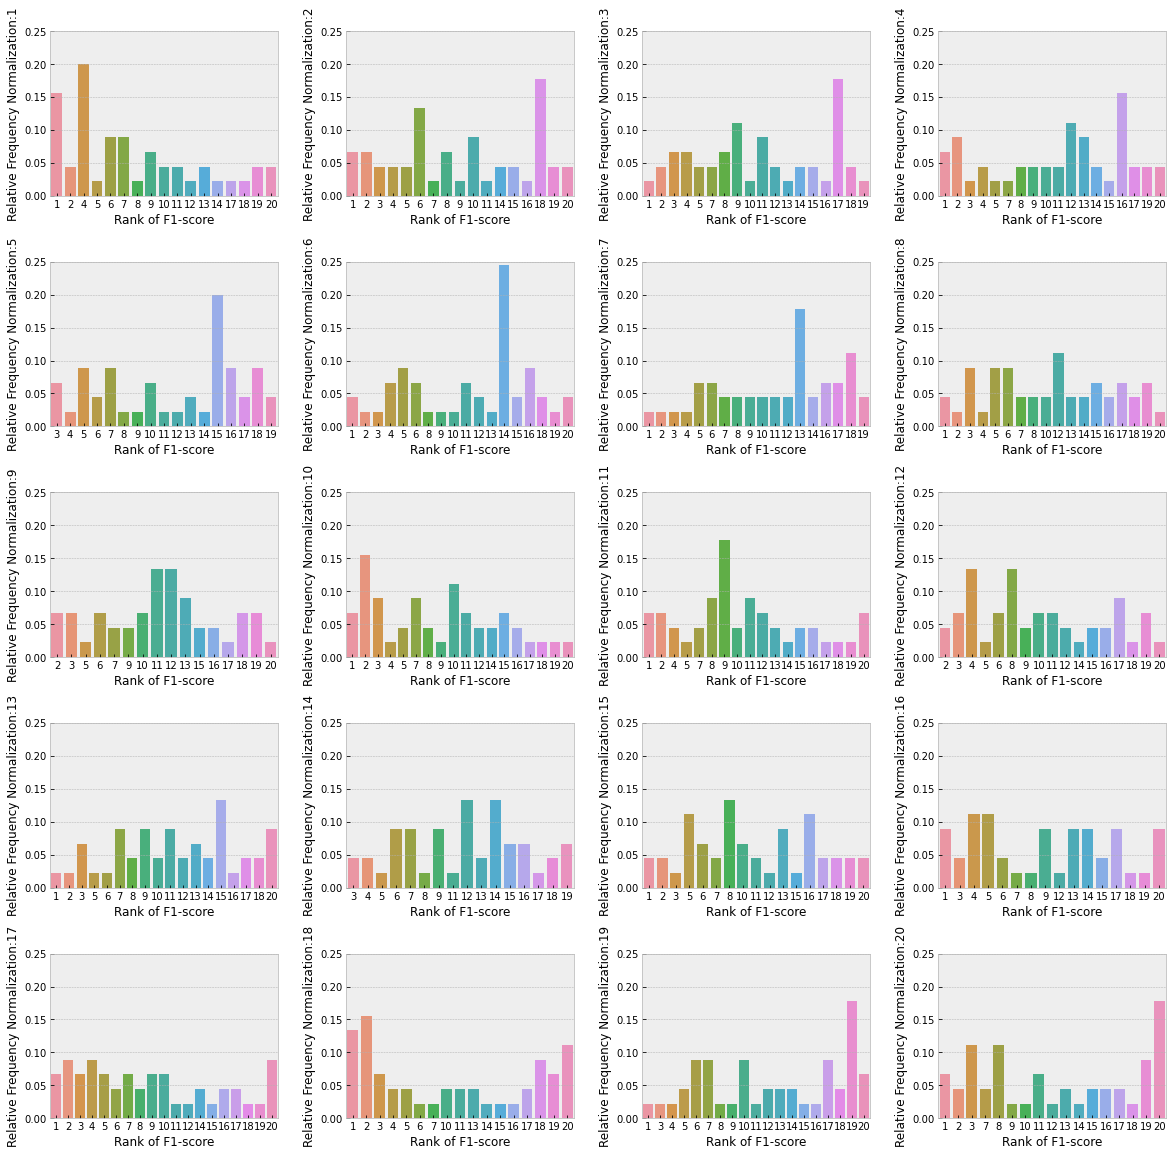

In [156]:
fig, axs = plt.subplots(5,4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =0.4, wspace=0.3)
axs = axs.ravel()
T = pd.DataFrame()
for i in range(0,total.shape[0]):
    T = pd.DataFrame()
    unique, counts = np.unique(total_index.iloc[i,:], return_counts=True)
    #fig, ax = plt.subplots(5,4,i+1)
    #bars = ax.barh(indexes, values)
    T['A']=unique
    T['L']=counts/45
    plt.subplot(5,4,i+1)
    sns.barplot(data=T, x="A", y="L")
    #plt.bar(unique,counts/45)
    plt.ylabel('Relative Frequency Normalization:'+ str(i+1))
    plt.xlabel('Rank of F1-score')
    plt.ylim([0, 0.25])
plt.savefig(path_figure+'comparingNormalizationmethods.png',bbox_inches = 'tight',pad_inches=0,facecolor='white', dpi=400)
plt.show()  


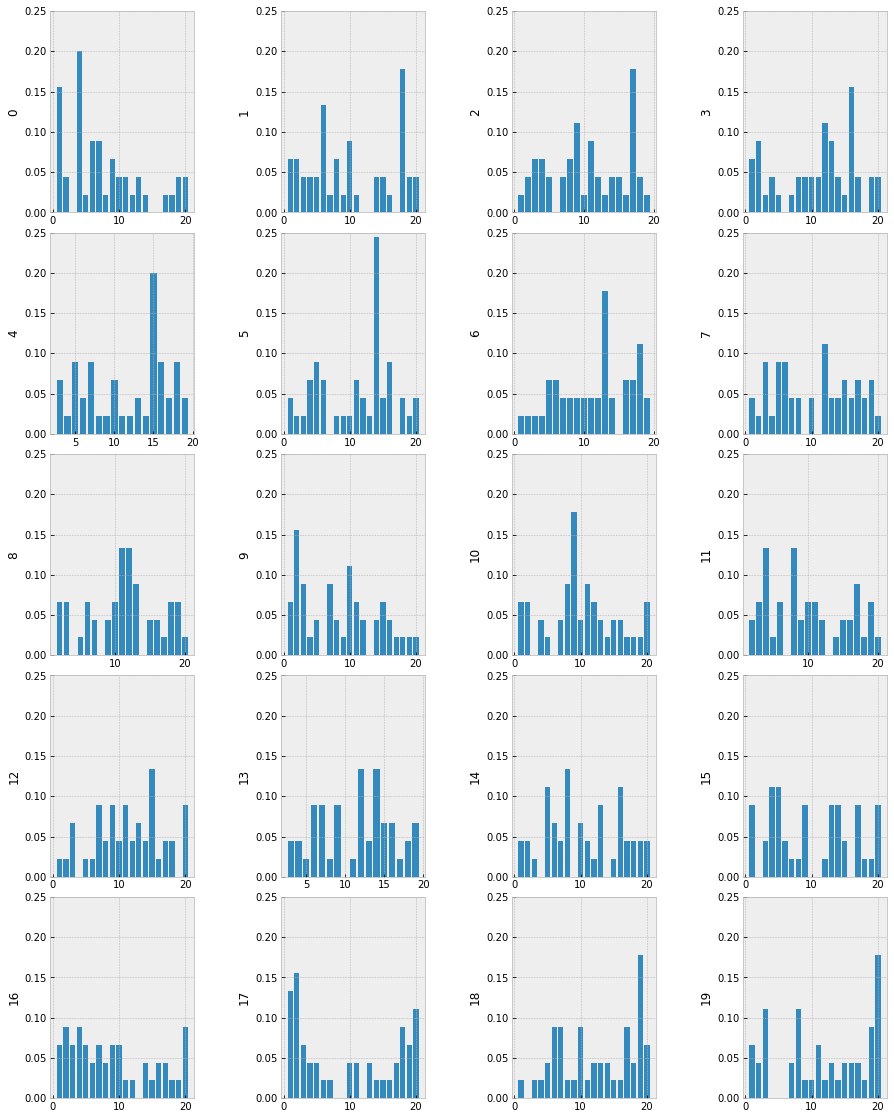

In [127]:
fig, axs = plt.subplots(5,4, figsize=(15, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =0.1, wspace=0.6)

axs = axs.ravel()
for i in range(0,total.shape[0]):
    unique, counts = np.unique(total_index.iloc[i,:], return_counts=True)
    #fig, ax = plt.subplots(5,4,i+1)
    #bars = ax.barh(indexes, values)
    
    plt.subplot(5,4,i+1)
    plt.bar(unique,counts/45)
    plt.ylabel(i)
    plt.ylim([0, 0.25])

plt.savefig(path_figure+'comparingNormalizationmethods.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')
plt.show()   

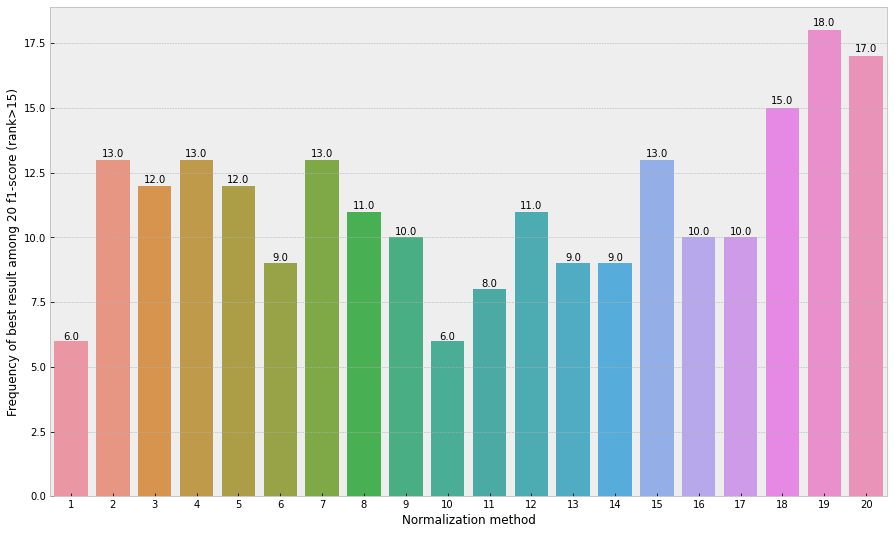

In [122]:
#ax = plt.figure(figsize=(15,9), dpi=300)
fig, ax = plt.subplots(figsize=(15,9))
L=[]
for i in range(0,total.shape[0]):
    unique, counts = np.unique(total_index.iloc[i,:], return_counts=True)
    L.append(counts[unique>15].sum()) 
#T=pd.DataFrame(index = range(1,21))
ls = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
T = pd.DataFrame(ls)
T['L']=L
# plt.bar(ls,T['L'])
# plt.bar(T[0],T['L'])
# show_values(ax)
# plt.tick_params(axis='x', colors='red', direction='out', length=13, width=3)
sns.barplot(data=T, x=0, y="L")
show_values(ax)
plt.xlabel('Normalization method')
plt.ylabel('Frequency of best result among 20 f1-score (rank>15)')
plt.savefig(path_figure+'>15.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

# Xudong

In [5]:
data_path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/python code local/Main Data Files/response_xudong'

path_list = []

for root, dirs, files in os.walk(data_path, topdown=False):
    for path in dirs:
        path_list.append(path)
        
wb = openpyxl.load_workbook(data_path+'/'+path+'/classification.xlsx')
sheet_list = wb.sheetnames

results_dic = dict.fromkeys(sheet_list)
for sheet_name in results_dic.keys():
    temp_df = pd.DataFrame(columns=path_list)
    for folder in path_list:
        data_temp = pd.read_excel(data_path+'/'+folder+'/classification.xlsx', sheet_name=sheet_name)
        temp_df[folder] = data_temp.iloc[4][1:].values

    results_dic[sheet_name] = temp_df

In [6]:
sheet_list

['Phylum', 'Class', 'Order', 'Family']

In [7]:
total = pd.concat([results_dic['Class'],results_dic['Phylum'],results_dic['Order']],axis=1)

In [8]:
total_index = pd.DataFrame(columns=total.columns, index = range(0,20))

for i, col in enumerate(total.columns):
    idx = np.argsort(total.iloc[:,i].values)
    idx = np.argsort(idx)
    total_index.iloc[:,i] = idx+1

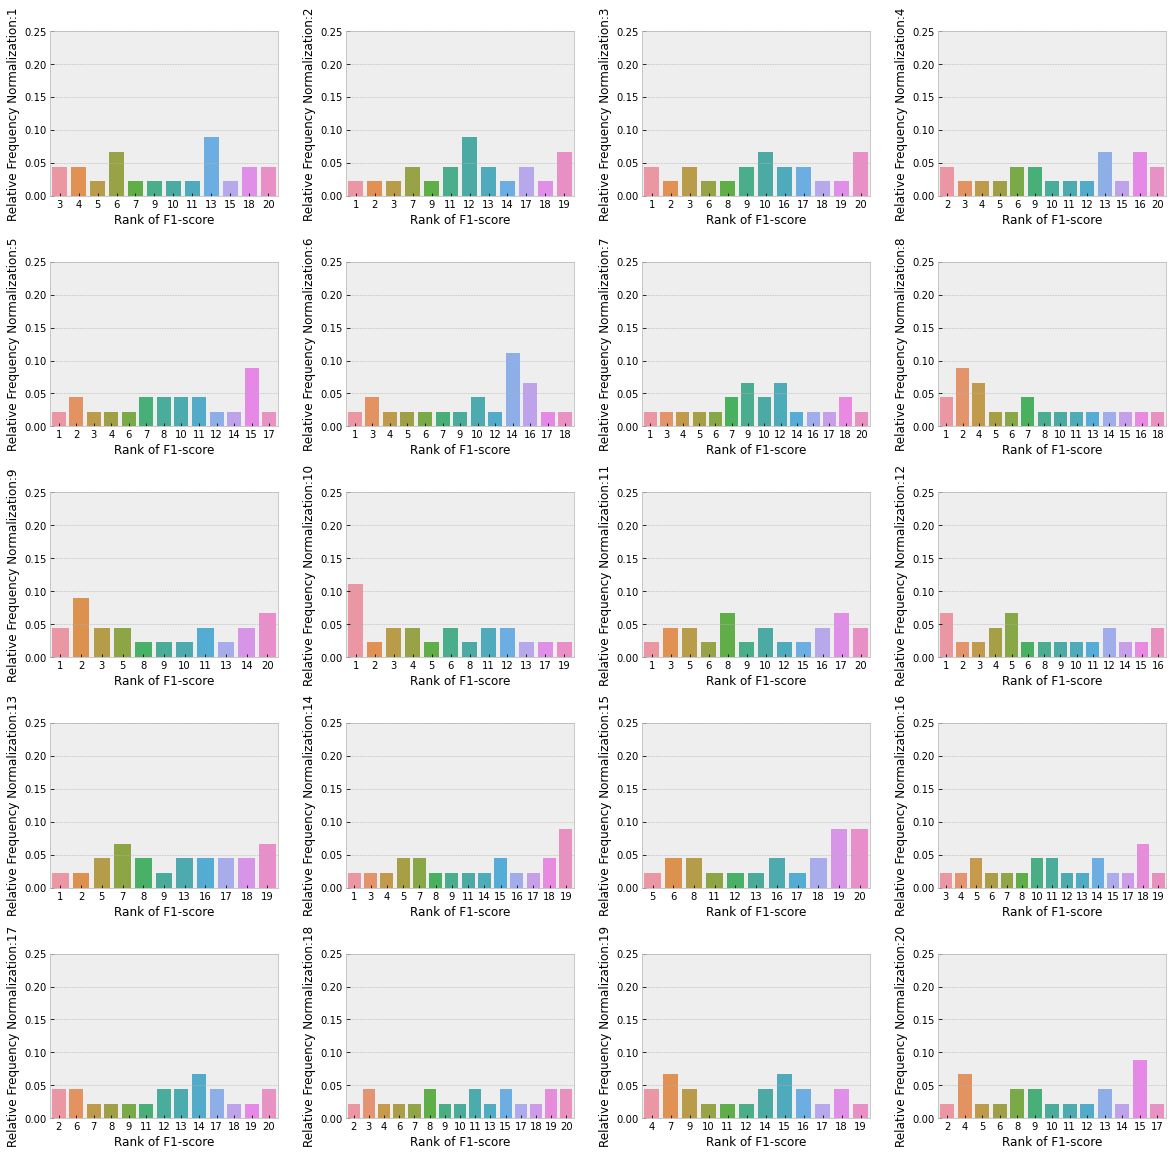

In [9]:
fig, axs = plt.subplots(5,4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =0.4, wspace=0.3)
axs = axs.ravel()
T = pd.DataFrame()
for i in range(0,total.shape[0]):
    T = pd.DataFrame()
    unique, counts = np.unique(total_index.iloc[i,:], return_counts=True)
    #fig, ax = plt.subplots(5,4,i+1)
    #bars = ax.barh(indexes, values)
    T['A']=unique
    T['L']=counts/45
    plt.subplot(5,4,i+1)
    sns.barplot(data=T, x="A", y="L")
    #plt.bar(unique,counts/45)
    plt.ylabel('Relative Frequency Normalization:'+ str(i+1))
    plt.xlabel('Rank of F1-score')
    plt.ylim([0, 0.25])
plt.savefig(path_figure+'comparingNormalizationmethods_xudong.png',bbox_inches = 'tight',pad_inches=0,facecolor='white', dpi=400)
plt.show()   

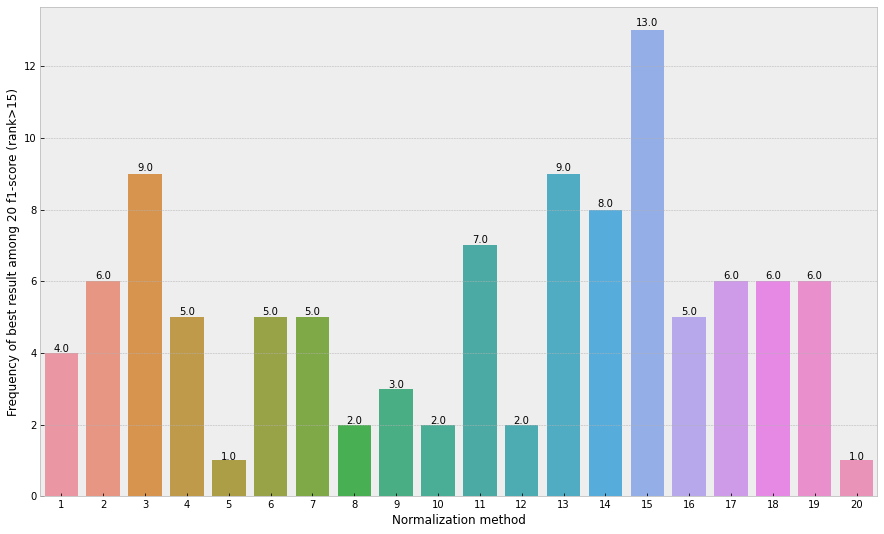

In [10]:
#ax = plt.figure(figsize=(15,9), dpi=300)
fig, ax = plt.subplots(figsize=(15,9))
L=[]
for i in range(0,total.shape[0]):
    unique, counts = np.unique(total_index.iloc[i,:], return_counts=True)
    L.append(counts[unique>15].sum()) 
#T=pd.DataFrame(index = range(1,21))
ls = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
T = pd.DataFrame(ls)
T['L']=L
# plt.bar(ls,T['L'])
# plt.bar(T[0],T['L'])
# show_values(ax)
# plt.tick_params(axis='x', colors='red', direction='out', length=13, width=3)
sns.barplot(data=T, x=0, y="L")
show_values(ax)
plt.xlabel('Normalization method')
plt.ylabel('Frequency of best result among 20 f1-score (rank>15)')
plt.savefig(path_figure+'>15Xudong.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

# Seperetly

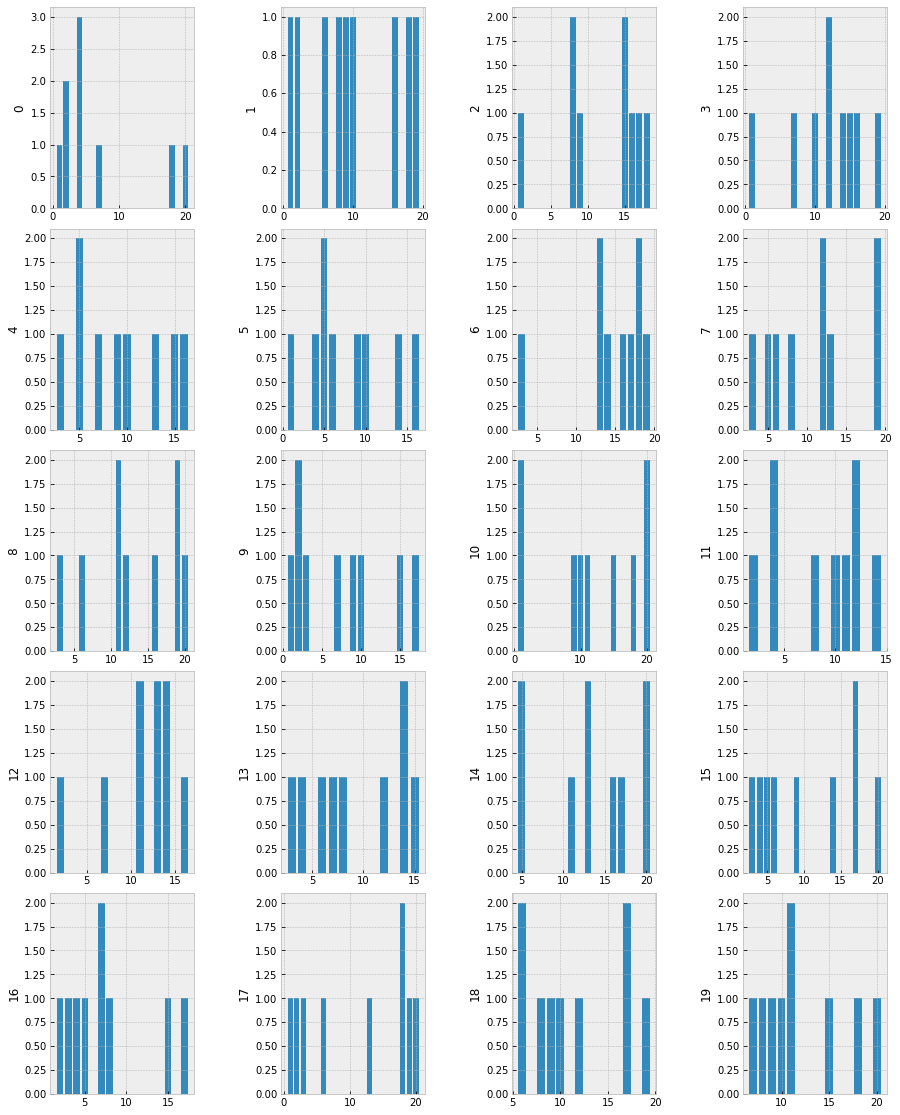

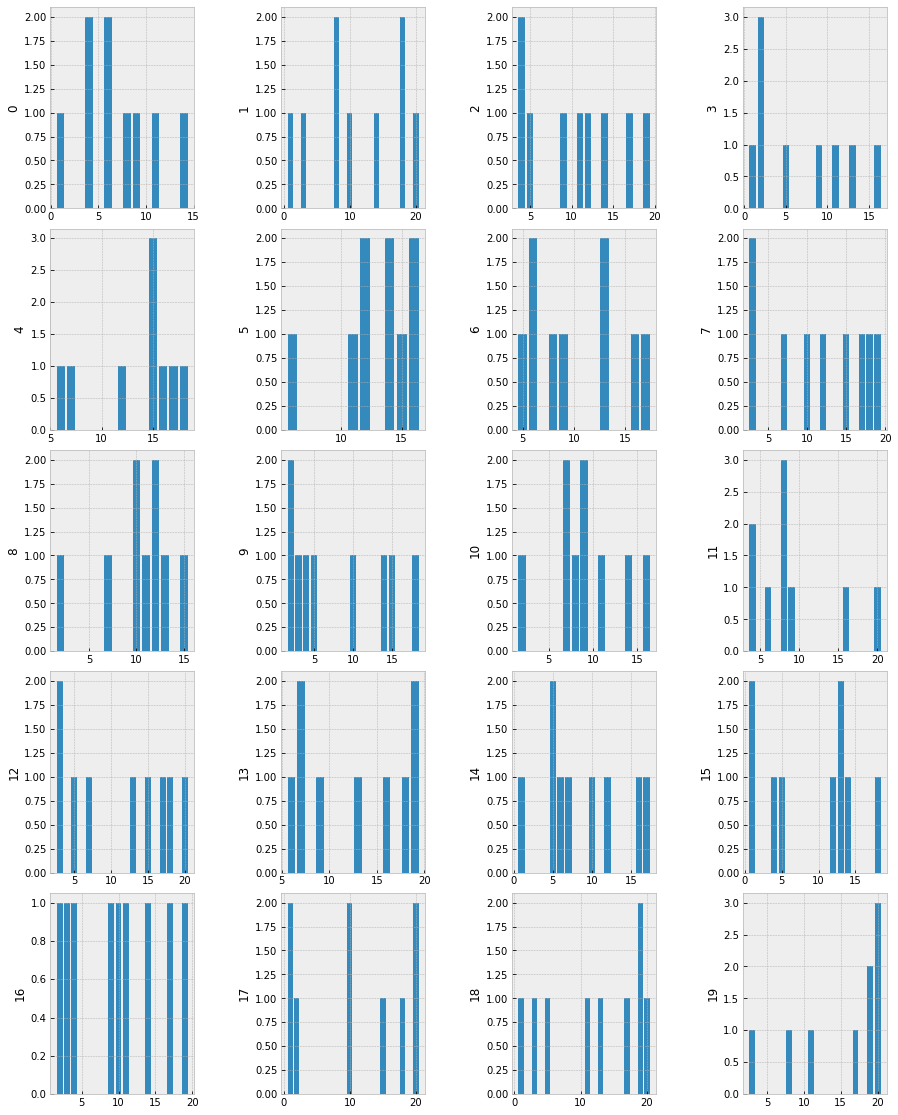

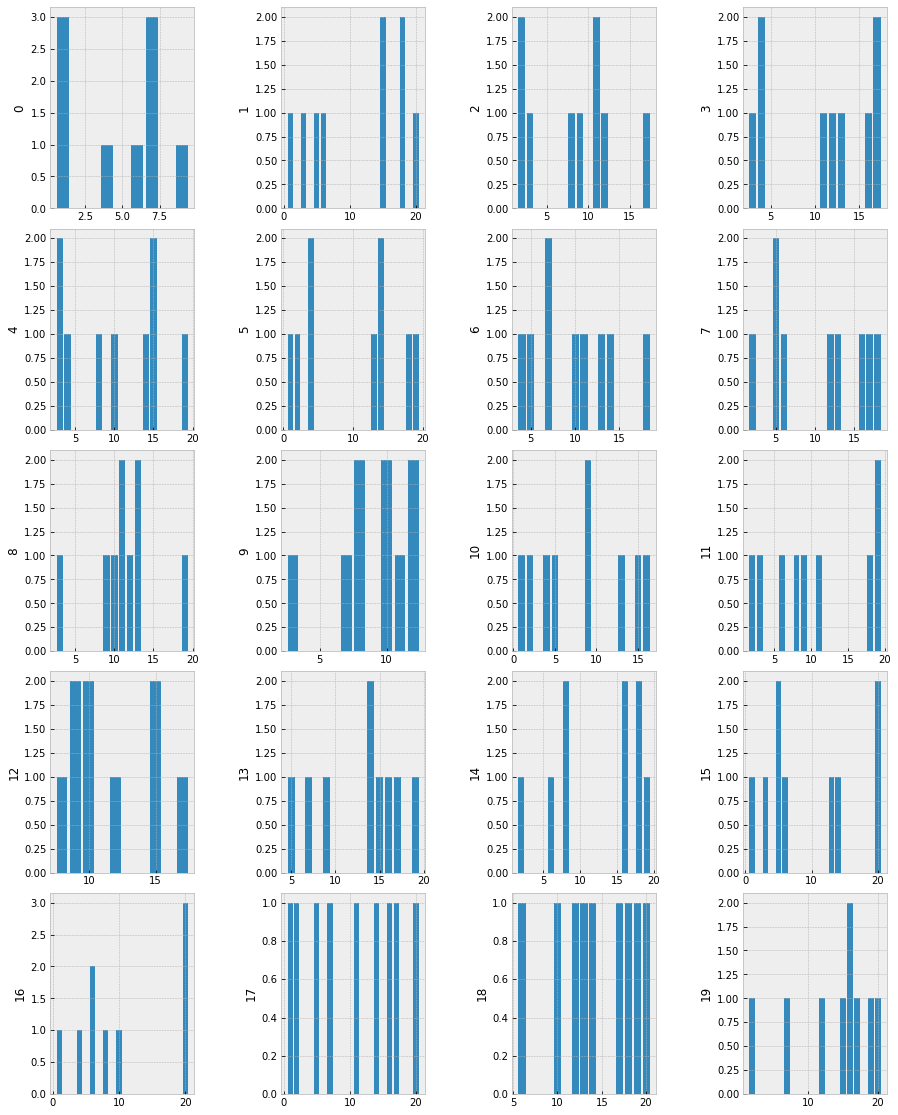

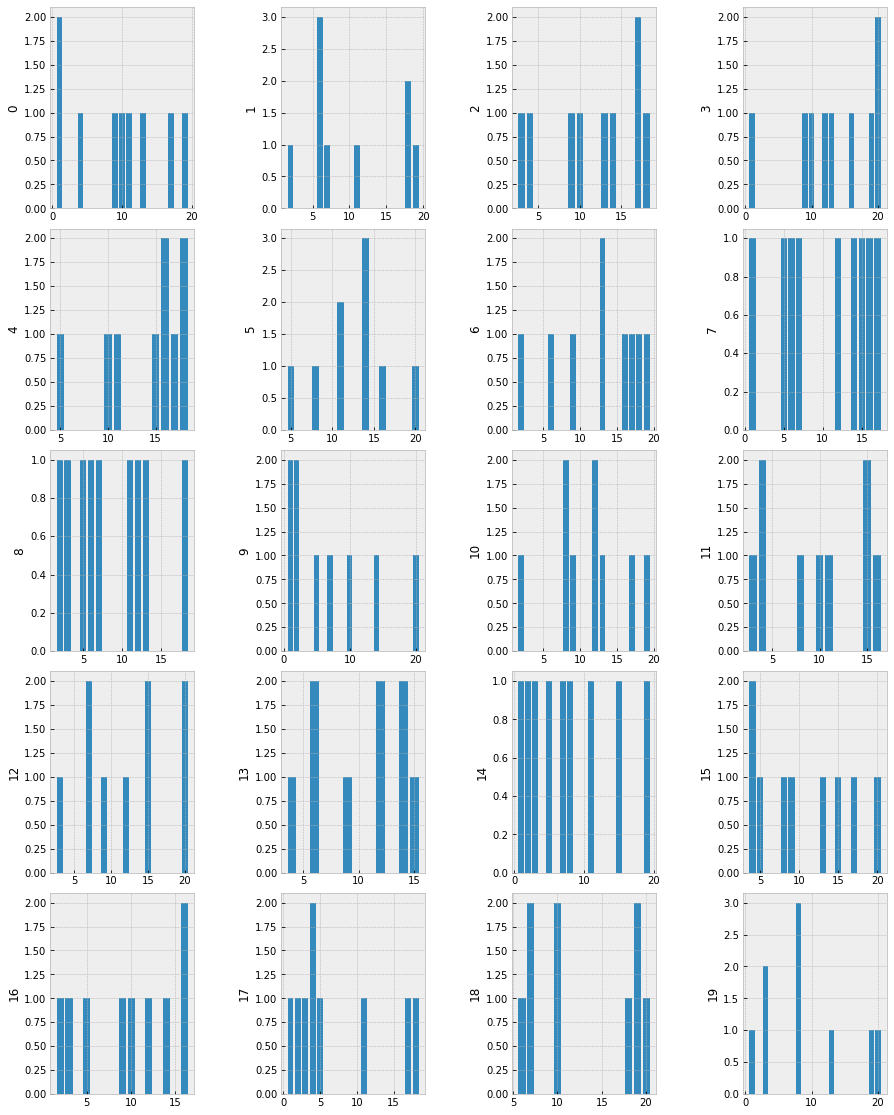

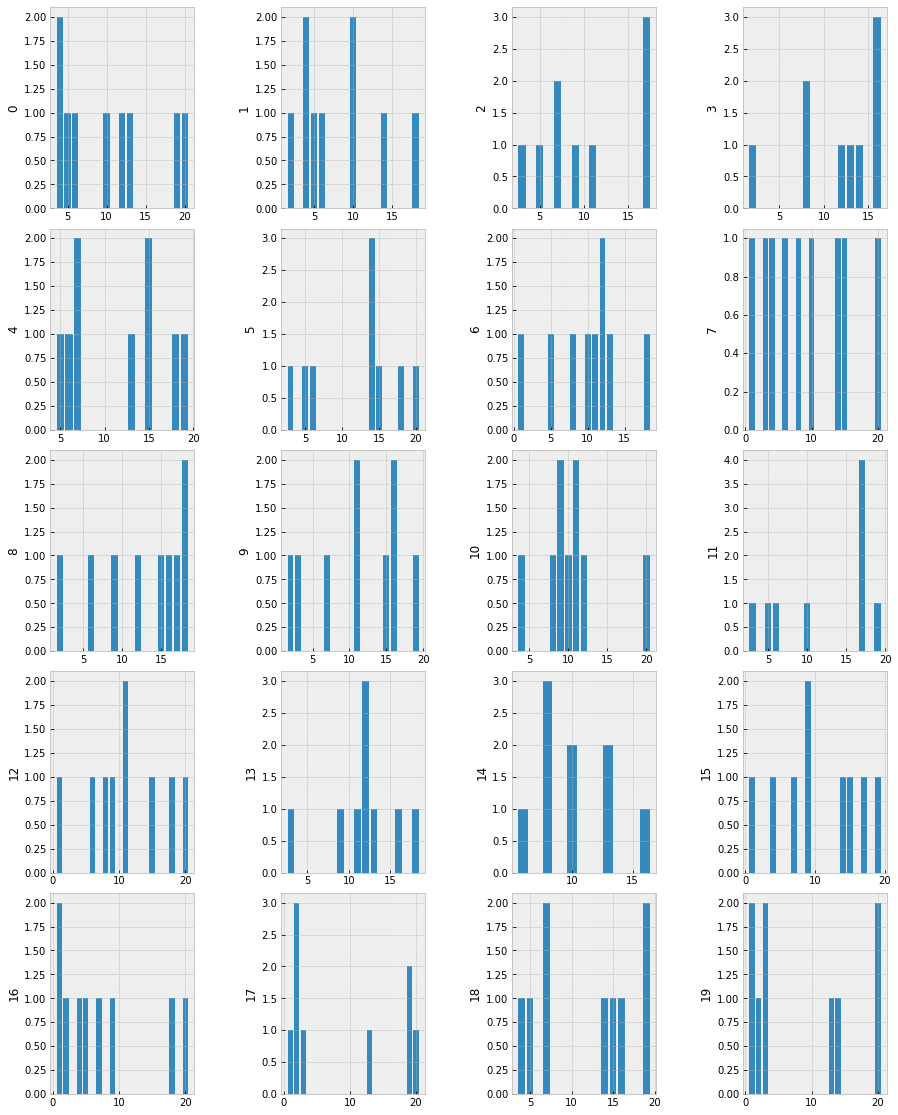

In [86]:
list_level = ['Class','Family', 'Genus', 'Order', 'Phylum']
for col in range(0,len(list_level)):
    level = list_level[col]
    total=results_dic[level]
    total_index = pd.DataFrame(columns=total.columns, index = range(0,20))

    for i, col in enumerate(total.columns):
        idx = np.argsort(total.iloc[:,i].values)
        idx = np.argsort(idx)
        total_index.iloc[:,i] = idx+1

    fig, axs = plt.subplots(5,4, figsize=(15, 20), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace =0.1, wspace=0.6)

    axs = axs.ravel()
    for i in range(0,total.shape[0]):
        unique, counts = np.unique(total_index.iloc[i,:], return_counts=True)
        plt.subplot(5,4,i+1)
        plt.bar(unique,counts)
        plt.ylabel(i)
    plt.savefig(path_figure+level+'comparingNormalizationmethods.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')
    plt.show()   

# Yield_per_meter Response


In [ ]:
#Yield_per_meter
response=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/yield_per_meter.csv")
response=response.drop(columns='Variety2')
response.rename(columns={'Column1':'Link_ID','Yield_per_meter':'y_con','x1':'y_binary'}, inplace=True)


In [ ]:
response

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(response['y_con'].loc[response['y_binary']==0],'o')
plt.plot(response['y_con'].loc[response['y_binary']==1],'o')
plt.legend(['y_c = 0', 'y_c = 1'])
plt.xlabel('Sample')
plt.ylabel('Sample Label')


In [ ]:
response['y_con'].loc[response['y_binary']==0]

# scab_severity response

In [ ]:
#scab_severity response
response=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/scab_severity.csv")
response=response.drop(columns='Variety2')
response.rename(columns={'Column1':'Link_ID','Scab_severity':'y_con','x1':'y_binary'}, inplace=True)
response

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(response['y_con'].loc[response['y_binary']==0],'o')
plt.plot(response['y_con'].loc[response['y_binary']==1],'o')
plt.legend(['y_c = 0', 'y_c = 1'])
plt.xlabel('Sample')
plt.ylabel('Sample Label')

# no_tuber_scab

In [ ]:
#scab_severity response
response=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/no_tuber_scab.csv")
response=response.drop(columns='Variety2')
response.rename(columns={'Column1':'Link_ID','No_tuber_scab':'y_con','x1':'y_binary'}, inplace=True)
response

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(response['y_con'].loc[response['y_binary']==0],'o')
plt.plot(response['y_con'].loc[response['y_binary']==1],'o')
plt.legend(['y_c = 0', 'y_c = 1'])
plt.xlabel('Sample')
plt.ylabel('Sample Label')

# Report Phylum

In [ ]:
df1=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/binary-data.csv")
df2 = pd.read_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/metadata.csv')
df1=df1.drop('Variety2',axis=1)
df1.rename(columns={'Yield_per_plant':"y_binary"}, inplace=True)
df2 = df2[['Unnamed: 0', 'Yield_per_plant']]
df2.rename(columns={'Unnamed: 0':'Link_ID'}, inplace=True)
data_original = pd.merge(df1, df2, on='Link_ID')

In [ ]:
print(df1.shape)
print(df2.shape)
print(data_original.shape)

In [ ]:
data_original.head()

In [ ]:
 pd.DataFrame(data_original.groupby(['y_binary'])['y_binary'].count())

In [ ]:
nsample_OTU=[]
for col in data_original.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).columns:
    I = data_original[col]>0
    nsample_OTU.append(sum(I))

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,1,1)
ax=sns.barplot(x=data_original.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).columns, y=nsample_OTU);
ax.bar_label(ax.containers[0]);
plt.xticks(rotation='vertical');
plt.subplot(2,1,2)
ax=sns.barplot(x=data_original.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).columns, y=data_original.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).sum(0));
ax.bar_label(ax.containers[0]);
plt.xticks(rotation='vertical');
plt.tight_layout()
plt.savefig('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/Frequency.png',bbox_inches = 'tight',pad_inches=0)

In [ ]:
fr_OTU=pd.DataFrame()
fr_OTU['OTU'] = data_original.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).columns
fr_OTU['Fr']  = pd.DataFrame(nsample_OTU)
fr_OTU['value OTU']=data_original.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).sum(0).values
fr_OTU=fr_OTU.set_index('OTU')
fr_OTU=fr_OTU.sort_values('Fr',ascending=False)
fr_OTU.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/fr_OTU.csv', header=True)

# SET the threshold to remove OTU

In [ ]:
th=15
remain_col=fr_OTU[fr_OTU['Fr']>th].index
remain_col=remain_col.insert(0, 'Link_ID')
CountOTU=data_original[remain_col]
CountOTU=CountOTU.set_index('Link_ID')
CountOTU.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/DATA/CountOTU.csv', header=True)
#data_C=pd.read_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/DATA/CountOTU.csv', index_col=0)

In [ ]:
CountOTU.shape

In [ ]:
CountOTU.head()

# Data_after_filering

In [ ]:
data = data_original[remain_col]
data['y_binary']=data_original['y_binary'].values
data['Yield_per_plant']=data_original ['Yield_per_plant'].values

In [ ]:
plt.figure(figsize=(17,13))
plt.subplot(2,1,1)
data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).boxplot()
plt.xticks(rotation='vertical');

plt.subplot(2,1,2)
data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).boxplot()
plt.semilogy()
plt.xticks(rotation='vertical');

plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).max().sort_values(ascending=False),'o')
plt.plot(data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).min(),'.')
plt.xticks(rotation='vertical');
plt.show()

In [ ]:
th=100
#th=0.05
important_features = data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).max().sort_values(ascending=False)[data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).max()>th].index
important_features = [item for item in important_features]
important_features.append('Yield_per_plant')
important_features.append('y_binary')

In [ ]:
data_selected = data[important_features]

In [ ]:
plt.figure(figsize=(12,10))
cor = data_selected.corr()
sns.heatmap(round(cor,1), annot=True, cmap="rainbow")

In [ ]:
# sns.pairplot(data_selected,hue='Yield_per_plant')

In [ ]:
x_column_list= data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).columns

tempList = []
for idx in range(0,data.shape[0]):
    for OTUNum in range(1,10):
        response = data['y_binary'].iloc[idx-1]
        OTUName = data.columns[OTUNum]
        OTUValue = data[OTUName].iloc[idx]
        tempList.append([response,OTUName,OTUValue])

dataForBoxPlot1 = pd.DataFrame(tempList, columns=['response','OTUName','OTUValue'])

tempList = []
for idx in range(0,data.shape[0]):
    for OTUNum in range(10,20):
        response = data['y_binary'].iloc[idx]
        OTUName = data.columns[OTUNum]
        OTUValue = data[OTUName].iloc[idx]
        tempList.append([response,OTUName,OTUValue])

dataForBoxPlot2 = pd.DataFrame(tempList, columns=['response','OTUName','OTUValue'])

tempList = []
for idx in range(0,data.shape[0]):
    for OTUNum in range(20,30):
        response = data['y_binary'].iloc[idx]
        OTUName = data.columns[OTUNum]
        OTUValue = data[OTUName].iloc[idx]
        tempList.append([response,OTUName,OTUValue])

dataForBoxPlot3 = pd.DataFrame(tempList, columns=['response','OTUName','OTUValue'])

tempList = []
for idx in range(0,data.shape[0]):
    for OTUNum in range(30,40):
        response = data['y_binary'].iloc[idx]
        OTUName = data.columns[OTUNum]
        OTUValue = data[OTUName].iloc[idx]
        tempList.append([response,OTUName,OTUValue])

dataForBoxPlot4 = pd.DataFrame(tempList, columns=['response','OTUName','OTUValue'])

tempList = []
for idx in range(0,data.shape[0]):
    for OTUNum in range(40,len(x_column_list)):
        response = data['y_binary'].iloc[idx]
        OTUName = data.columns[OTUNum]
        OTUValue = data[OTUName].iloc[idx]
        tempList.append([response,OTUName,OTUValue])

dataForBoxPlot5 = pd.DataFrame(tempList, columns=['response','OTUName','OTUValue'])

In [ ]:
plt.figure(figsize=(15,25))
plt.subplot(5,1,1)
idx1 = dataForBoxPlot1['OTUName']
ax = sns.boxplot(x="OTUName", y="OTUValue", hue="response",data=dataForBoxPlot1, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.grid()

plt.subplot(5,1,2)
idx1 = dataForBoxPlot2['OTUName']
ax = sns.boxplot(x="OTUName", y="OTUValue", hue="response",data=dataForBoxPlot2, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.grid()

plt.subplot(5,1,3)
idx1 = dataForBoxPlot3['OTUName']
ax = sns.boxplot(x="OTUName", y="OTUValue", hue="response",data=dataForBoxPlot3, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.grid()

plt.subplot(5,1,4)
idx1 = dataForBoxPlot4['OTUName']
ax = sns.boxplot(x="OTUName", y="OTUValue", hue="response",data=dataForBoxPlot4, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.grid()

plt.subplot(5,1,5)
idx1 = dataForBoxPlot5['OTUName']
ax = sns.boxplot(x="OTUName", y="OTUValue", hue="response",data=dataForBoxPlot5, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.grid()
plt.tight_layout()
plt.savefig('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/Box-plot.png',facecolor='white')



In [ ]:
# path1 = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/filter_data/'
# for file in os.listdir(path1):
#     if (file[0] == 'P')& (file[-4:] != '.csv'):
#         p=file
#         path = path1+p
#         os.chdir(path)
#         file_list = []
#         for file in os.listdir(path):
#             if (file[0] != 'R') & (file[-4:] == '.csv'):
#                 file_list.append(file) 
#         output_dic = dict.fromkeys(file_list)
#         for file in os.listdir(path):
#             if file[-4:] == '.csv':
#                 print(file)
#                 data_temp = pd.read_csv(file)
#                 output = process_data(response,data_temp,cv,q)
#                 output_dic[file] = [output[0],output[1], output[2],output[3]]
                
#         tRF=pd.DataFrame()
#         tALL=pd.DataFrame()
#         k=0
#         for key in output_dic.keys():
#             if key != '.csv':
#                 print(key)
#                 tRF[k]=pd.DataFrame(output_dic[key][3]['f1_RF'].values)
#                 tALL[k]=pd.DataFrame(output_dic[key][3]['f1_All'].values)
#                 k=k+1
#         tRF.index=output_dic[key][3].index
#         tALL.index=output_dic[key][3].index
#         tRF.to_csv('f1-score/result_f1_RF.csv')
#         tALL.to_csv('f1-score/result_f1_ALL.csv')